# SEMINAR Cross_Sectional_Momentum
## **Introduction**
### **Overview:**
In 1990, Jegadeesh introduced the concept of momentum in his paper ***Evidence of Predictable Behavior of Security Returns.*** Jegadeesh provided empirical evidence showing a correlation between stock returns over longer periods, thus proving the predictability of stock returns. After Jegadeesh’s publication in 1990, **Jegadeesh and Titman (1993)** further developed the concept of momentum by introducing cross-sectional momentum. 
In their studies, Jegadeesh and Titman examined the relationship between past and future stock returns in the U.S. stock market. According to the findings of Jegadeesh and Titman (1993), this strategy yielded significant positive returns, even after accounting for standard risk factors and transaction costs.

The CSM strategy has become one of the most important and influential topics in finance, particularly in portfolio management. CSM focuses on selecting and comparing the performance of assets within the same time period, optimizing returns by buying high-performing assets and short-selling underperforming ones. This strategy not only delivers superior returns but has also been proven to be effective even when considering risk factors and transaction costs.

These studies not only provide insight into how CSM works but also help investors better understand the relationship between past performance and future returns. With a solid theoretical foundation and strong empirical evidence, CSM has become an essential element in asset allocation and effective portfolio construction.

This research will delve deeper into Cross-Sectional Momentum, from basic theory to practical applications, as well as evaluate the effectiveness of this strategy in the context of modern investing.
### **Research prolem**:
The momentum effect has been recognized as one of the most important financial phenomena and has been extensively studied across many stock markets, particularly in the context of major events such as the U.S. presidential election. However, the applicability and effectiveness of momentum strategies can vary significantly when markets are influenced by political and economic factors related to elections. The U.S. stock market, one of the largest and most liquid markets in the world, often experiences strong volatility around elections due to changes in fiscal, trade, and regulatory policies.

Previous studies have shown that the uncertainty surrounding elections can create significant short-term volatility, affecting the trends in stock returns. Therefore, the momentum effect—which relies on past performance trends to predict future outcomes—can become distorted or difficult to predict during this period. Specifically, the cross-sectional momentum strategy, which focuses on comparing the relative performance of stocks over the same period, may face significant challenges in maintaining stable performance as policy changes and market expectations resulting from elections impact the fundamental factors of individual stocks.

## **Import Thư viện**

In [5]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers, Variable
import ccxt
import asyncio
import nest_asyncio

## **Get data**

Dữ liệu nến cho **20 cặp tiền điện tử từ API của Bybit trong khoảng thời gian trong vòng 1 năm. Dữ liệu sẽ được lấy với khoảng thời gian nến là 1 ngày**.

Mỗi cặp tiền được xác định bằng mã cặp tiền, **ví dụ như BTCUSDT cho Bitcoin và USDT, ETHUSDT cho Ethereum và USDT, và các cặp khác như BNBUSDT, XRPUSDT, LTCUSDT, và nhiều cặp khác.**

Thời gian bắt đầu và kết thúc được chuyển đổi từ định dạng chuỗi sang định dạng datetime, và sau đó được chuyển đổi thành timestamptheo đơn vị milliseconds để phù hợp với yêu cầu của API. Đoạn mã cũng tính toán số milliseconds trong một tuần, điều này có thể hữu ích khi thực hiện các cuộc gọi API để lấy dữ liệu theo khoảng thời gian cụ thể.

Dữ liệu nến sẽ bao gồm các thông tin quan trọng như sau:
+ Open Price 
+ Highest Price
+ Lowest close 
+ Close close
+ Trade Volume




### **Khởi tạo môi trường làm việc**

In [2]:
nest_asyncio.apply()

async def get_top_volume_symbols(top=10):
    bybit = ccxt.bybit()
    markets = bybit.fetch_markets()
    
    # Lọc các thị trường có loại 'spot', không cần kiểm tra 'USDT'
    spot_markets = [
        market['symbol'] for market in markets 
        if market['type'] == 'spot'
    ]
    
    volumes = []
    for symbol in spot_markets:
        try:
            ticker = bybit.fetch_ticker(symbol)
            volumes.append({
                'symbol': symbol,
                'volume': ticker['quoteVolume'] if ticker['quoteVolume'] else 0
            })
            await asyncio.sleep(0.1)  # Rate limiting
        except Exception as e:
            print(f"Error fetching volume for {symbol}: {e}")
            continue
    
    # Sắp xếp các cặp giao dịch theo khối lượng giảm dần và lấy top N
    top_symbols = sorted(volumes, key=lambda x: x['volume'], reverse=True)[:top]
    return [v['symbol'] for v in top_symbols]

### **Get data**

In [ ]:
async def fetch_ohlcv_data():
    bybit = ccxt.bybit()
    data_directory = "data_2022_2024"
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    global_start_time = datetime(2022, 1, 1)
    global_end_time = datetime(2024, 1, 1)

    try:
        all_symbols = await get_top_volume_symbols(500)
        symbols_to_process = []
        skipped_symbols = []

        # Fetch dữ liệu cho mã đầu tiên để lấy khoảng thời gian chuẩn
        first_symbol = all_symbols[0]
        print(f"Fetching data for the first symbol: {first_symbol}")
        since = int(global_start_time.timestamp() * 1000)
        first_symbol_data = []

        try:
            while since < int(global_end_time.timestamp() * 1000):
                ohlcv = await bybit.fetch_ohlcv(
                    symbol=first_symbol,
                    timeframe='1d',
                    since=since,
                    limit=1000
                )
                if not ohlcv:
                    break
                first_symbol_data.extend(ohlcv)
                since = ohlcv[-1][0] + 86400000
                await asyncio.sleep(0.5)

            if len(first_symbol_data) < 360:
                raise ValueError("First symbol does not have sufficient data for alignment.")

            first_symbol_df = pd.DataFrame(
                first_symbol_data,
                columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
            )
            first_symbol_df['timestamp'] = pd.to_datetime(first_symbol_df['timestamp'], unit='ms')
            start_time = first_symbol_df['timestamp'].min()
            end_time = first_symbol_df['timestamp'].max()
            print(f"Aligned time range: {start_time} to {end_time}")

        except Exception as e:
            print(f"Error fetching data for the first symbol {first_symbol}: {e}")
            return

        # Fetch dữ liệu cho các mã khác
        for symbol in all_symbols:
            if len(symbols_to_process) >= 300:
                break

            print(f"\nFetching data for {symbol}")
            since = int(start_time.timestamp() * 1000)
            all_ohlcv = []

            try:
                while since < int(end_time.timestamp() * 1000):
                    ohlcv = await bybit.fetch_ohlcv(
                        symbol=symbol,
                        timeframe='1d',
                        since=since,
                        limit=1000
                    )

                    if not ohlcv:
                        break

                    all_ohlcv.extend(ohlcv)
                    since = ohlcv[-1][0] + 86400000
                    await asyncio.sleep(0.5)

                df = pd.DataFrame(
                    all_ohlcv,
                    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
                )

                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

                if df['timestamp'].min() <= start_time and df['timestamp'].max() >= end_time and len(df) >= 360:
                    symbols_to_process.append(symbol)
                    filename = f"{data_directory}/{symbol.replace('/', '_')}.csv"
                    df.to_csv(filename, index=False)
                    print(f"Saved data to {filename}")
                else:
                    print(f"Skipping {symbol}, data does not align with the required time range or is insufficient.")
                    skipped_symbols.append(symbol)

            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
                skipped_symbols.append(symbol)

        print("\nFinal list of processed symbols:", symbols_to_process)
        print("Skipped symbols:", skipped_symbols)

        if len(symbols_to_process) < 300:
            print(f"\nOnly {len(symbols_to_process)} symbols were processed. Consider increasing the buffer size of top volume symbols.")

    except Exception as e:
        print(f"Error fetching OHLCV data: {e}")

async def main():
    await fetch_ohlcv_data()
if __name__ == "__main__":
    asyncio.run(main())

### **Merge data**

In [4]:
# Thư mục chứa các tệp CSV
data_dir = 'data_2022_2024'

# Danh sách để lưu DataFrames
dataframes = []

# Duyệt qua tất cả các tệp CSV trong thư mục
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)
        df['symbol'] = filename.split('_')[0]  # Thêm cột 'symbol' để nhận diện
        dataframes.append(df)

# Gộp tất cả DataFrames thành một DataFrame duy nhất
merged_df = pd.concat(dataframes, ignore_index=True)

# Lưu DataFrame đã gộp thành một tệp CSV
merged_filename = 'merged_ohlcv_data.csv'
merged_df.to_csv(merged_filename, index=False)

### **Tranform Data để tính MACD và Momentum**

In [15]:
data = pd.read_csv("merged_ohlcv_data.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

duplicates = data[data.duplicated(subset=['timestamp', 'symbol'], keep=False)]
if not duplicates.empty:
    print("Các bản ghi trùng lặp:")
    print(duplicates)

data = data.drop_duplicates(subset=['timestamp', 'symbol'], keep='last')

pivoted_data = data.pivot(index='timestamp', columns='symbol', values='close')

pivoted_data.reset_index(inplace=True)

pivoted_data.to_csv("data_raw.csv", index=False)

Các bản ghi trùng lặp:
        timestamp      open      high       low     close       volume symbol
5000   2022-01-01  0.000036  0.000037  0.000035  0.000037     23929.00   ALGO
5001   2022-01-02  0.000037  0.000037  0.000035  0.000035     22127.20   ALGO
5002   2022-01-03  0.000035  0.000040  0.000035  0.000039     34001.10   ALGO
5003   2022-01-04  0.000039  0.000040  0.000036  0.000036     80753.10   ALGO
5004   2022-01-05  0.000036  0.000039  0.000034  0.000036     44227.40   ALGO
...           ...       ...       ...       ...       ...          ...    ...
100995 2024-09-22  0.597600  0.605300  0.577600  0.587200  71129637.56    XRP
100996 2024-09-23  0.587200  0.595800  0.578700  0.584800  78314644.88    XRP
100997 2024-09-24  0.584800  0.592700  0.581400  0.591100  70234229.89    XRP
100998 2024-09-25  0.591100  0.595700  0.582500  0.583100  60431486.45    XRP
100999 2024-09-26  0.583100  0.596400  0.574100  0.590400  87039374.71    XRP

[16000 rows x 7 columns]


## **EDA Data**

### **Đọc Data**

In [6]:
df = pd.read_csv('merged_ohlcv_data.csv')
df

timestamp    open    high     low   close      volume symbol
0       2022-01-01  2.4017  2.5490  2.3997  2.5468    26891.29  1INCH
1       2022-01-02  2.5468  2.5883  2.4764  2.5667    14621.38  1INCH
2       2022-01-03  2.5667  2.6676  2.4892  2.5702    28679.86  1INCH
3       2022-01-04  2.5702  2.6191  2.5003  2.5221    40704.42  1INCH
4       2022-01-05  2.5221  2.6227  2.2500  2.3574   269926.48  1INCH
...            ...     ...     ...     ...     ...         ...    ...
106995  2024-09-22  0.3452  0.3578  0.3149  0.3240   914325.92    ZRX
106996  2024-09-23  0.3240  0.3347  0.3166  0.3332  1001325.71    ZRX
106997  2024-09-24  0.3332  0.3400  0.3253  0.3399  1041553.30    ZRX
106998  2024-09-25  0.3399  0.3721  0.3399  0.3470  6460667.57    ZRX
106999  2024-09-26  0.3470  0.3577  0.3394  0.3559  1238651.90    ZRX

[107000 rows x 7 columns]

### **Data processing**

In [14]:
# Chuyển đổi cột 'Time' về kiểu datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
# 1. Kiểm tra thông tin cơ bản của DataFrame
print("Thông tin cơ bản của DataFrame:")
print(df.info())

# 2. Kiểm tra các giá trị bị thiếu
print("\nGiá trị bị thiếu trong các cột:")
print(df.isnull().sum())


Thông tin cơ bản của DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107000 entries, 0 to 106999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  107000 non-null  datetime64[ns]
 1   open       107000 non-null  float64       
 2   high       107000 non-null  float64       
 3   low        107000 non-null  float64       
 4   close      107000 non-null  float64       
 5   volume     107000 non-null  float64       
 6   symbol     107000 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.7+ MB
None

Giá trị bị thiếu trong các cột:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
symbol       0
dtype: int64


In [15]:
# 3. Kiểm tra dữ liệu trùng lặp
print("\nDữ liệu trùng lặp:")
print(df.duplicated().sum())  
# Loại bỏ các hàng trùng lặp
df_no_duplicates = df.drop_duplicates()
print("\nDataFrame sau khi loại bỏ trùng lặp:")
print(df_no_duplicates.info())


Dữ liệu trùng lặp:
0

DataFrame sau khi loại bỏ trùng lặp:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107000 entries, 0 to 106999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  107000 non-null  datetime64[ns]
 1   open       107000 non-null  float64       
 2   high       107000 non-null  float64       
 3   low        107000 non-null  float64       
 4   close      107000 non-null  float64       
 5   volume     107000 non-null  float64       
 6   symbol     107000 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.7+ MB
None


In [16]:
# 4. Kiểm tra dữ liệu ngoại lai (outliers) bằng phương pháp IQR
# Chọn cột volume để kiểm tra ngoại lai
volume_col = 'volume'

# Tính toán Q1, Q3 và IQR cho cột volume
Q1_volume = df[volume_col].quantile(0.25)
Q3_volume = df[volume_col].quantile(0.75)
IQR_volume = Q3_volume - Q1_volume

# Xác định các ngoại lai trong cột volume
outliers_volume = (df[volume_col] < (Q1_volume - 1.5 * IQR_volume)) | (df[volume_col] > (Q3_volume + 1.5 * IQR_volume))

# In ra số lượng ngoại lai trong cột volume
print("\nSố lượng ngoại lai trong cột volume:")
print(outliers_volume.sum())

# Loại bỏ các hàng có ngoại lai trong cột volume
df_no_outliers_volume = df[~outliers_volume]
print("\nDataFrame sau khi loại bỏ ngoại lai trong cột volume:")
print(df_no_outliers_volume.info())



Số lượng ngoại lai trong cột volume:
18647

DataFrame sau khi loại bỏ ngoại lai trong cột volume:
<class 'pandas.core.frame.DataFrame'>
Index: 88353 entries, 0 to 106999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  88353 non-null  datetime64[ns]
 1   open       88353 non-null  float64       
 2   high       88353 non-null  float64       
 3   low        88353 non-null  float64       
 4   close      88353 non-null  float64       
 5   volume     88353 non-null  float64       
 6   symbol     88353 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.4+ MB
None


### **Thống kê mô tả**

In [17]:
# 1.Nhóm dữ liệu theo cặp tiền và tính thống kê mô tả cho mỗi nhóm
grouped_stats = df.groupby('symbol').describe()

# Hiển thị thống kê mô tả
print("\nThống kê mô tả theo cặp tiền:")
print(grouped_stats)


Thống kê mô tả theo cặp tiền:
       timestamp                                            \
           count                 mean                  min   
symbol                                                       
1INCH       1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
1SOL        1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
AAVE        1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
ADA         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
AGLD        1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
...          ...                  ...                  ...   
XYM         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
YFI         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
ZEN         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
ZIL         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   
ZRX         1000  2023-05-15 12:00:00  2022-01-01 00:00:00   

                                                                       \
                        25%

### **Visualization**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17740\2686384120.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


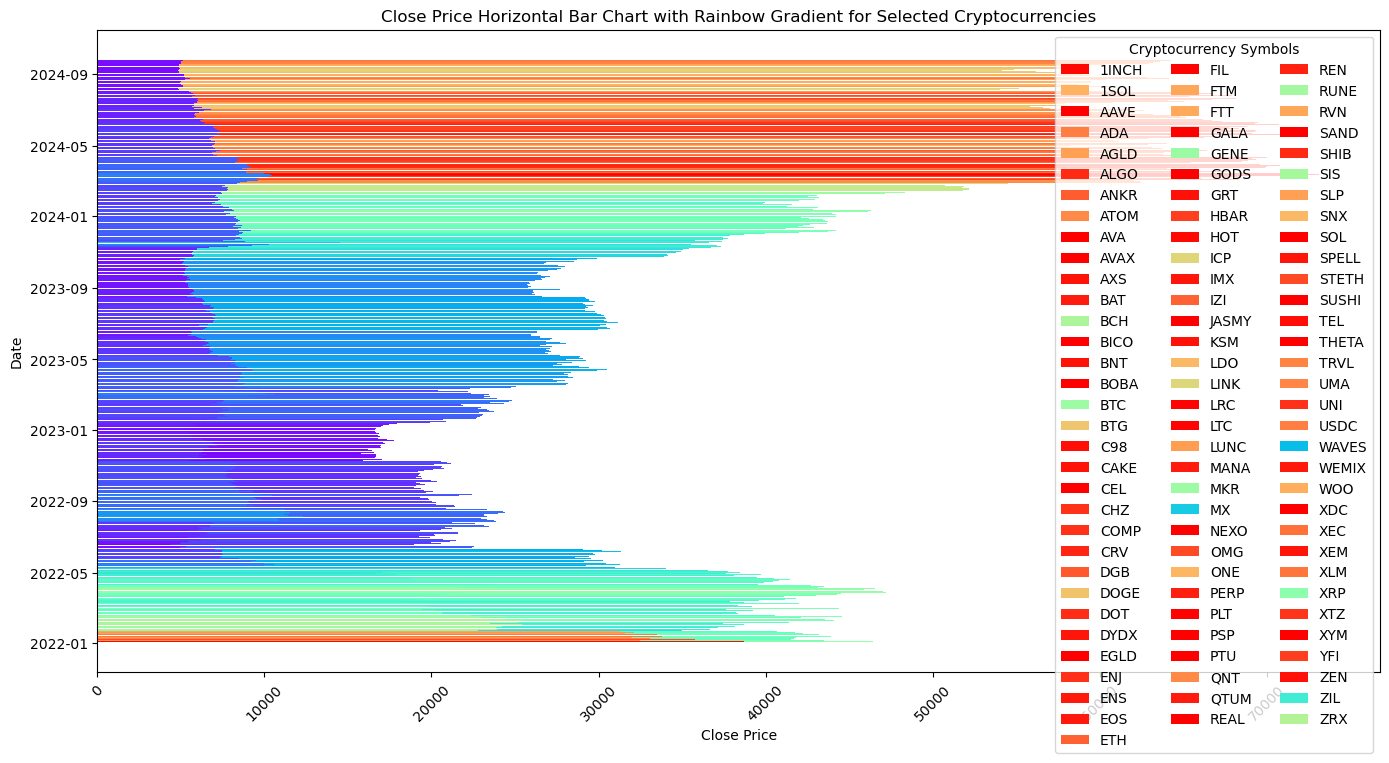

In [5]:

df = pd.read_csv('merged_ohlcv_data.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])

symbols_to_plot = df['symbol'].unique()

df_filtered = df[df['symbol'].isin(symbols_to_plot)]

df_filtered = df_filtered.drop_duplicates(subset=['timestamp', 'symbol'], keep='first')
pivot_df = df_filtered.pivot(index='timestamp', columns='symbol', values='close')

plt.figure(figsize=(14, 8))

for i, symbol in enumerate(pivot_df.columns):
    norm = plt.Normalize(vmin=pivot_df[symbol].min(), vmax=pivot_df[symbol].max())  
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm) 
    colors = sm.to_rgba(pivot_df[symbol])  
    plt.barh(pivot_df.index, pivot_df[symbol], color=colors, height=0.8, label=symbol)

plt.title('Close Price Horizontal Bar Chart with Rainbow Gradient for Selected Cryptocurrencies')
plt.xlabel('Close Price')
plt.ylabel('Date')
plt.legend(title='Cryptocurrency Symbols', ncol=3)

# Hiển thị đồ thị
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


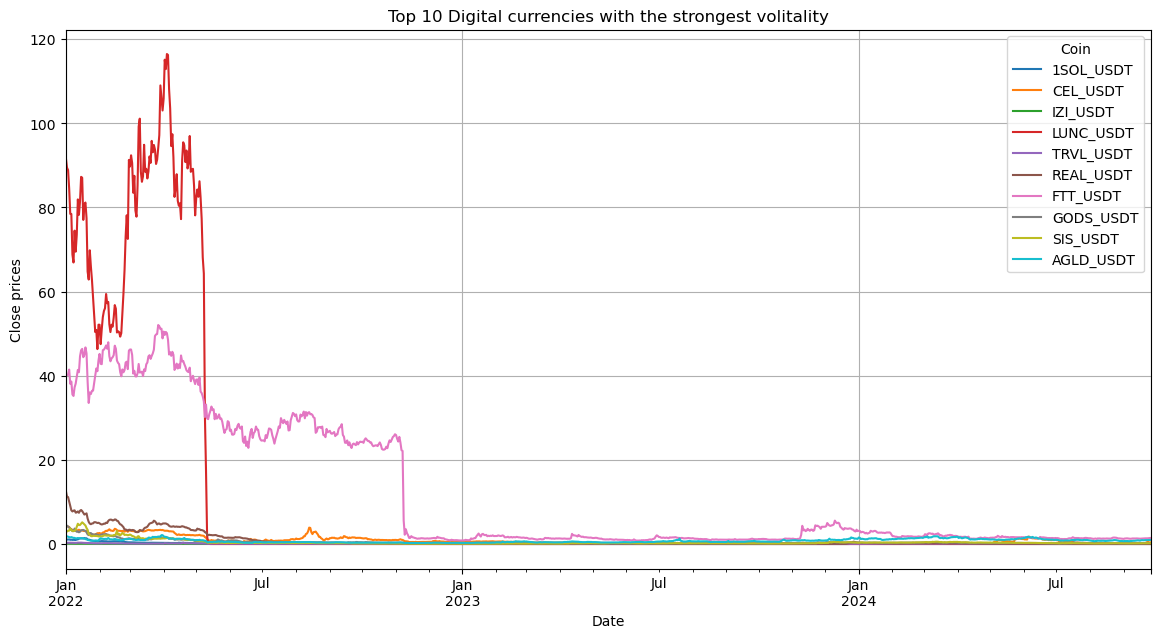

In [ ]:
volatility = df_returns.std()
top_volatility_coins = volatility.nlargest(10).index

# Vẽ biểu đồ cho top 10 mã biến động lớn
df_prices[top_volatility_coins].plot(figsize=(14, 7))
plt.title('Top 10 Digital currencies with the strongest volitality')
plt.ylabel('Close prices')
plt.legend(title='Coin', loc='upper right')
plt.grid()
plt.show()

Trực quan sơ bộ ta thấy đường màu đỏ (top 4) và đường màu hồng (top 7) có độ biến động mạnh nhưng chúng đều không phải là những mã tiền có volatility lớn nhất do:
- Close prices cao dẫn đến biến động lớn về giá trị tuyệt đối. Ví dụ, nếu một mã có giá đóng là 10,000 và biến động 1%, giá của nó có thể thay đổi khoảng 100. Ngược lại, nếu một mã chỉ có giá 100 và biến động 10% thì sự thay đổi chỉ tương đương với 10.

Điều này có thể gây nhầm lẫn nếu không phân tích toàn diện.


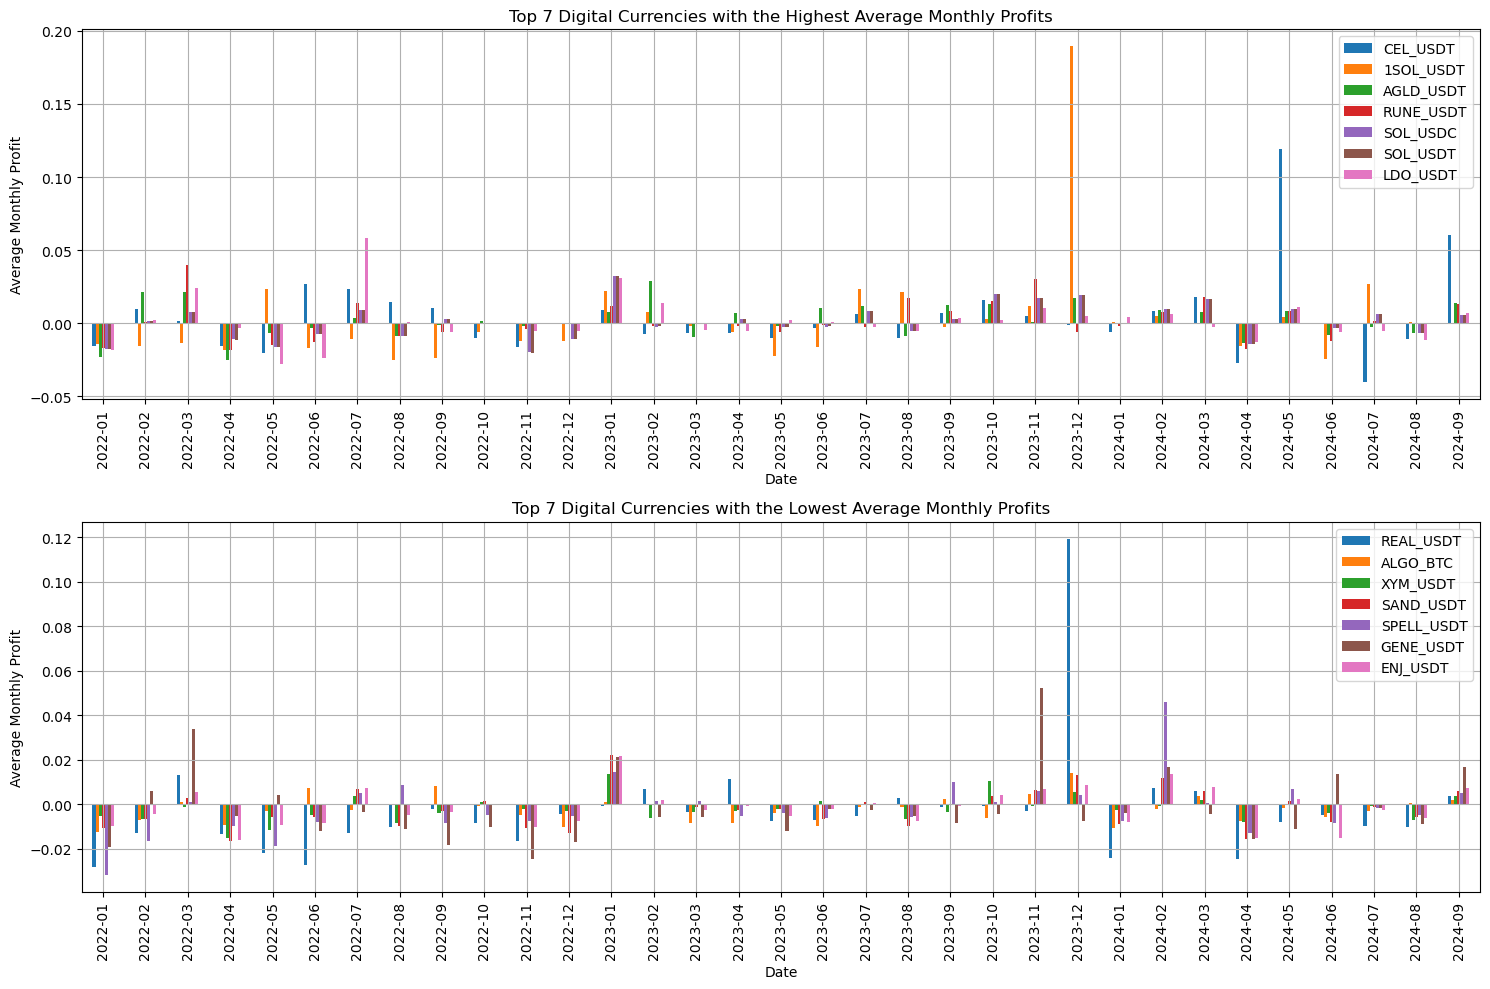

In [ ]:
monthly_returns = df_prices.pct_change().resample('M').mean()
monthly_returns.index = monthly_returns.index.strftime('%Y-%m')

top_returns = monthly_returns.mean().nlargest(7).index
bottom_returns = monthly_returns.mean().nsmallest(7).index

# Tạo hình và các subplot
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Vẽ biểu đồ cho top 7 mã lợi nhuận cao nhất
monthly_returns[top_returns].plot(kind='bar', ax=axs[0])
axs[0].set_title('Top 7 Digital Currencies with the Highest Average Monthly Profits')
axs[0].set_ylabel('Average Monthly Profit')
axs[0].grid()

# Vẽ biểu đồ cho top 7 mã lợi nhuận thấp nhất
monthly_returns[bottom_returns].plot(kind='bar', ax=axs[1])
axs[1].set_title('Top 7 Digital Currencies with the Lowest Average Monthly Profits')
axs[1].set_ylabel('Average Monthly Profit')
axs[1].grid()

plt.tight_layout()
plt.show()

Tháng 11 và 12 năm 2023, dữ liệu cho thấy rằng hầu hết các mã tiền điện tử đều ghi nhận lợi nhuận cao và tăng trưởng đồng loạt có thể do sự tác động toàn cầu của các sự kiện kinh tế hoặc chính trị quan trọng diễn ra trong khoảng thời gian này.

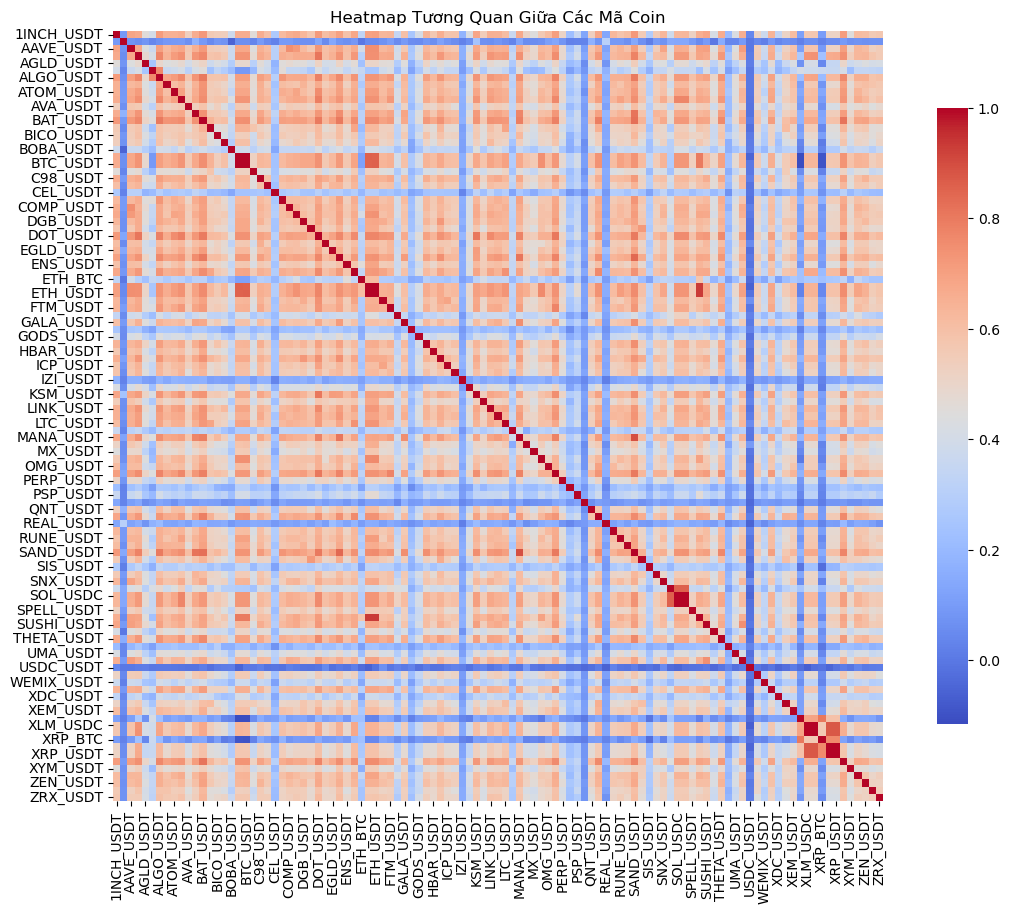

In [ ]:

# Tính toán ma trận tương quan
correlation_matrix = df_prices.pct_change().corr()

# Vẽ heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap Tương Quan Giữa Các Mã Coin')
plt.show()

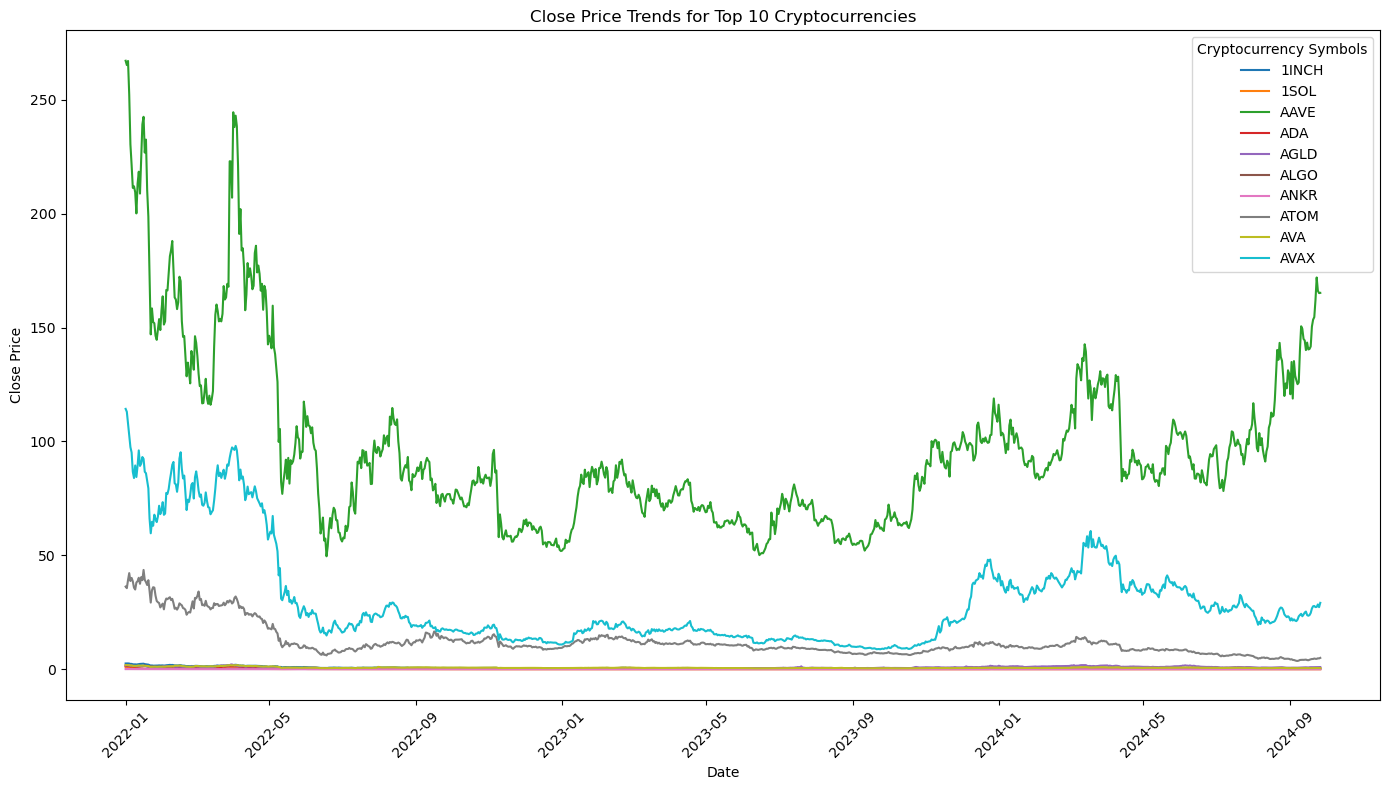

In [6]:

# Đọc dữ liệu từ file CSV
df = pd.read_csv('data/feature/merged_ohlcv_data.csv')

# Chuyển đổi cột 'timestamp' thành datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Lấy danh sách các mã tiền tệ duy nhất
symbols_to_plot = df['symbol'].unique()[:10]  # Lấy 10 mã đầu tiên

# Lọc dữ liệu cho các mã tiền tệ trong danh sách
df_filtered = df[df['symbol'].isin(symbols_to_plot)]

# Loại bỏ các dòng trùng lặp (giữ giá trị đầu tiên)
df_filtered = df_filtered.drop_duplicates(subset=['timestamp', 'symbol'], keep='first')

# Tạo ma trận giá đóng cửa cho các mã tiền tệ
pivot_df = df_filtered.pivot(index='timestamp', columns='symbol', values='close')

# Vẽ biểu đồ xu hướng giá
plt.figure(figsize=(14, 8))

# Duyệt qua từng cột (từng mã tiền tệ) và vẽ đường xu hướng
for symbol in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[symbol], label=symbol)

# Thêm tiêu đề và nhãn
plt.title('Close Price Trends for Top 10 Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Hiển thị legend
plt.legend(title='Cryptocurrency Symbols')

# Hiển thị biểu đồ
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


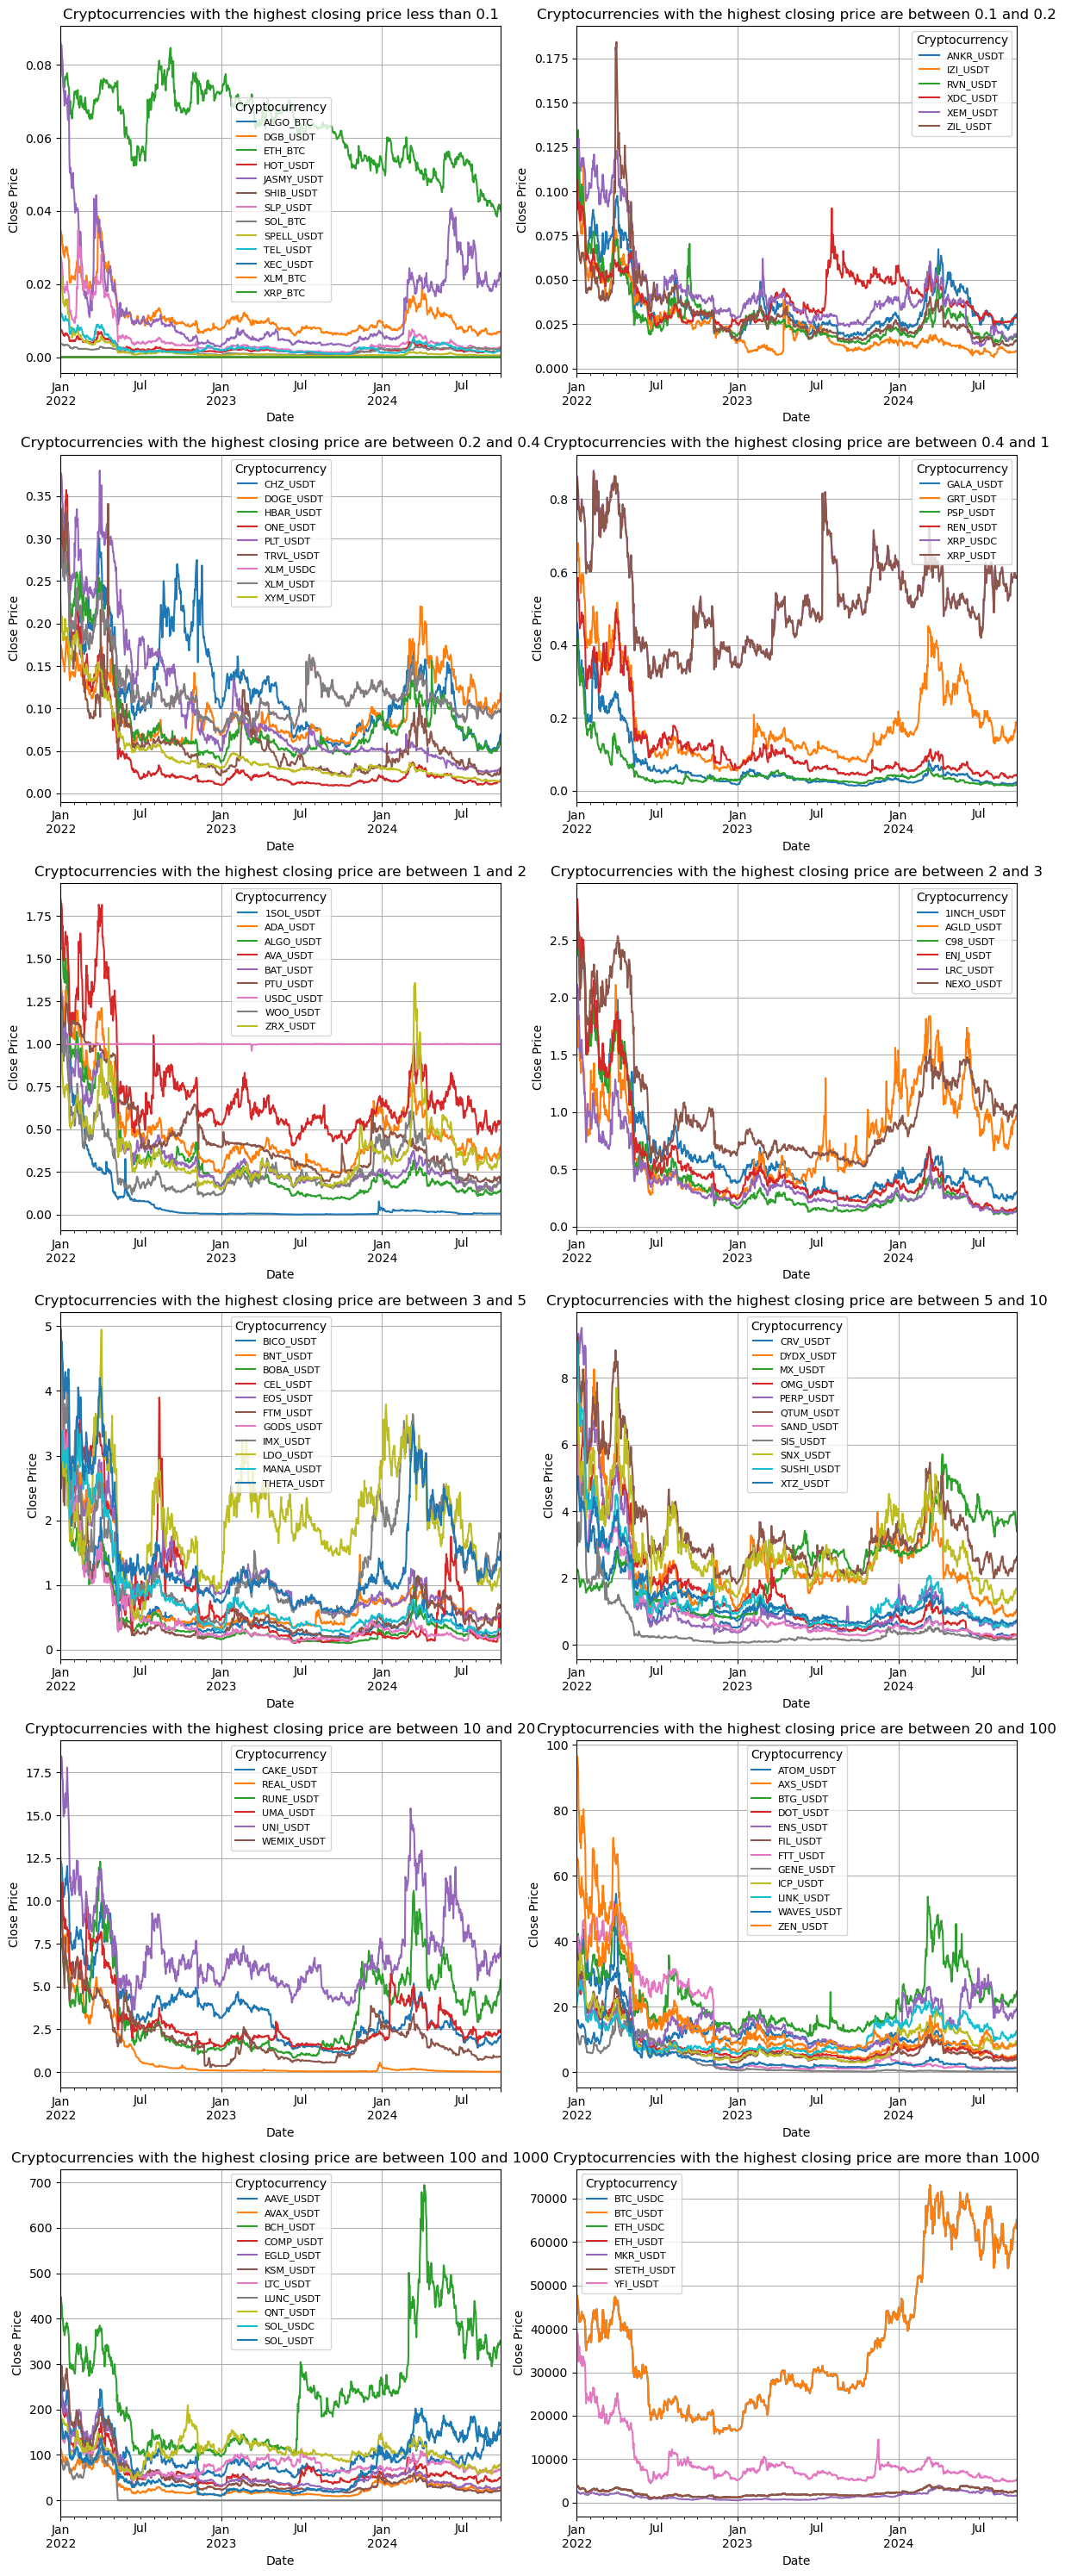

In [ ]:
selected_indices = [df[df['max'] < 0.1].index,
                    df[(df['max'] < 0.2) & (df['max'] >= 0.1)].index,
                    df[(df['max'] < 0.4) & (df['max'] >= 0.2)].index,
                    df[(df['max'] < 1) & (df['max'] >= 0.4)].index,
                    df[(df['max'] < 2) & (df['max'] >= 1)].index,
                    df[(df['max'] < 3) & (df['max'] >= 2)].index,
                    df[(df['max'] < 5) & (df['max'] >= 3)].index,
                    df[(df['max'] < 10) & (df['max'] >= 5)].index,
                    df[(df['max'] < 20) & (df['max'] >= 10)].index,
                    df[(df['max'] < 100) & (df['max'] >= 20)].index,
                    df[(df['max'] < 1000) & (df['max'] >= 100)].index,
                    df[df['max'] >= 1000].index]

fig, axs = plt.subplots(6, 2, figsize=(12, 30))  # Thay đổi chiều cao cho phù hợp

# Duyệt qua từng chỉ số và vẽ biểu đồ
for i, indices in enumerate(selected_indices):
    ax = axs[i // 2, i % 2]  # Tìm vị trí hàng và cột
    if not indices.empty:  # Kiểm tra nếu có dữ liệu
        df_prices[indices].plot(ax=ax)
        ax.set_ylabel("Close Price", fontsize=10)
        ax.legend(title="Cryptocurrency", fontsize=8, loc='best')
        ax.grid(True)
axs[0, 0].set_title("Cryptocurrencies with the highest closing price less than 0.1", fontsize=12)
axs[0, 1].set_title("Cryptocurrencies with the highest closing price are between 0.1 and 0.2", fontsize=12)
axs[1, 0].set_title("Cryptocurrencies with the highest closing price are between 0.2 and 0.4", fontsize=12)
axs[1, 1].set_title("Cryptocurrencies with the highest closing price are between 0.4 and 1", fontsize=12)
axs[2, 0].set_title("Cryptocurrencies with the highest closing price are between 1 and 2", fontsize=12)
axs[2, 1].set_title("Cryptocurrencies with the highest closing price are between 2 and 3", fontsize=12)
axs[3, 0].set_title("Cryptocurrencies with the highest closing price are between 3 and 5", fontsize=12)
axs[3, 1].set_title("Cryptocurrencies with the highest closing price are between 5 and 10", fontsize=12)
axs[4, 0].set_title("Cryptocurrencies with the highest closing price are between 10 and 20", fontsize=12)
axs[4, 1].set_title("Cryptocurrencies with the highest closing price are between 20 and 100", fontsize=12)
axs[5, 0].set_title("Cryptocurrencies with the highest closing price are between 100 and 1000", fontsize=12)
axs[5, 1].set_title("Cryptocurrencies with the highest closing price are more than 1000", fontsize=12)
plt.tight_layout()
plt.show()

Tỷ Lệ Tiền Điện Tử Theo Gía đóng cửa cao nhất:
- Khoảng Giá Thấp (<1): Với 34/107 đồng tiền điện tử chiếm khoảng 31.8% tổng số đồng tiền. Điều này cho thấy sự hiện diện tương đối lớn của các đồng tiền có giá thấp.
- Khoảng Giá Cao (>100): Chỉ có 18/107 đồng tiền (khoảng 16.8%). Điều này cho thấy rằng các đồng tiền có giá trị cao hơn là ít phổ biến hơn trong danh sách tổng thể

Nhận xét:
- Nhiều loại tiền điện tử có xu hướng biến động mạnh trong các khoảng giá khác nhau, đặc biệt là ở các mức giá thấp hơn (dưới 1) so với các mức giá cao hơn. 
- Ở các khoảng giá cao hơn (trên 10), sự biến động có thể ít hơn, cho thấy rằng các đồng tiền này có thể đã đạt được sự ổn định hơn hoặc có giá trị thị trường lớn hơn. 
- Các đồng tiền có giá thấp có thể mang lại cơ hội lớn, nhưng cũng đi kèm với rủi ro cao hơn do sự biến động lớn. Ngược lại, các đồng tiền có giá cao hơn có sự ổn định hơn.

### **Chia dữ liệu**

In [10]:
df_tf = pd.read_csv('data_raw.csv')
df_tf['timestamp'] = pd.to_datetime(df_tf['timestamp'])
train = df_tf[(df_tf['timestamp'] >= '2022-01-01') & (df_tf['timestamp'] < '2023-01-01')]
val = df_tf[(df_tf['timestamp'] >= '2023-01-01') & (df_tf['timestamp'] < '2023-07-01')]
test = df_tf[(df_tf['timestamp'] >= '2023-07-01') & (df_tf['timestamp'] < '2024-07-01')]



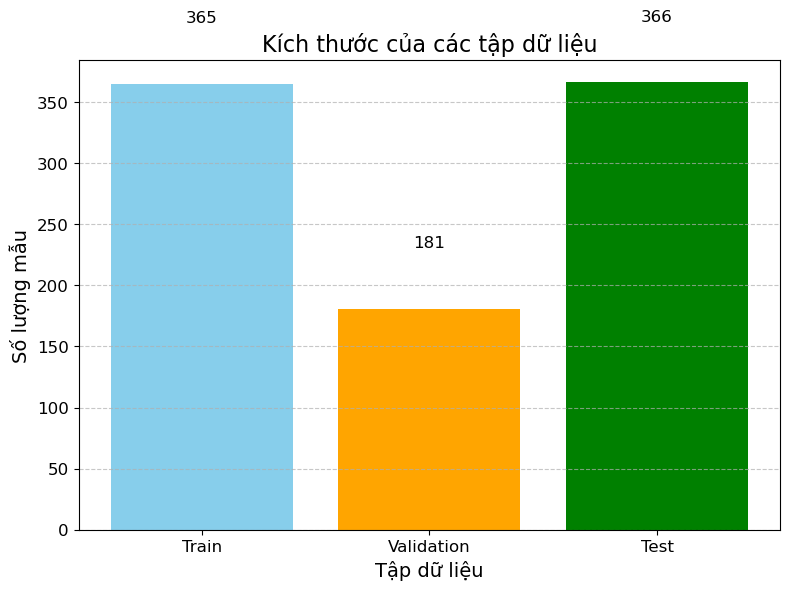

In [8]:

# Số lượng mẫu trong mỗi tập dữ liệu
sizes = [len(train), len(val), len(test)]
labels = ['Train', 'Validation', 'Test']

# Tạo biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['skyblue', 'orange', 'green'])
plt.title('Kích thước của các tập dữ liệu', fontsize=16)
plt.ylabel('Số lượng mẫu', fontsize=14)
plt.xlabel('Tập dữ liệu', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Hiển thị số lượng trên từng cột
for i, v in enumerate(sizes):
    plt.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **Chia tập dữ liệu gốc**

In [9]:
df_original = pd.read_csv('merged_ohlcv_data.csv')
df_original['timestamp'] = pd.to_datetime(df_original['timestamp'])
train_or = df_original[(df_original['timestamp'] >= '2022-01-01') & (df_original['timestamp'] < '2023-01-01')]
val_or = df_original[(df_original['timestamp'] >= '2023-01-01') & (df_original['timestamp'] < '2023-07-01')]
test_or = df_original[(df_original['timestamp'] >= '2023-07-01') & (df_original['timestamp'] < '2024-07-01')]


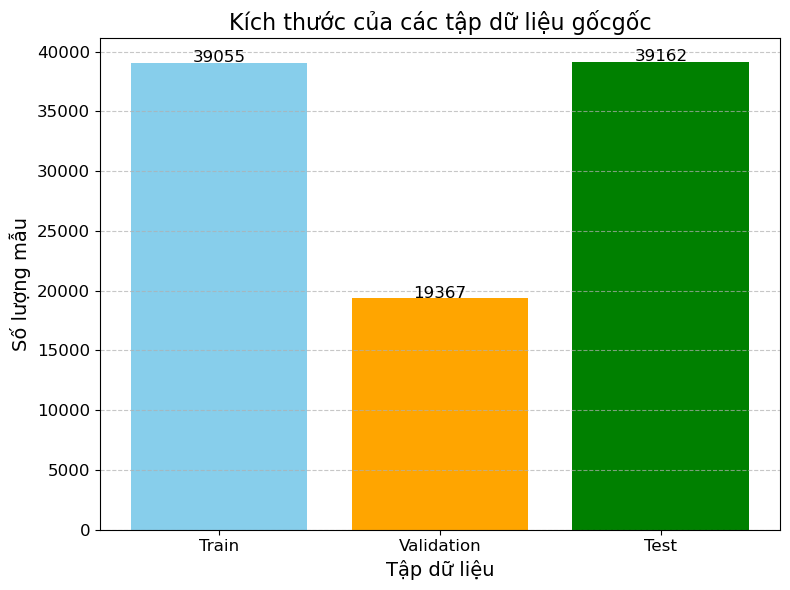

In [10]:

# Số lượng mẫu trong mỗi tập dữ liệu
sizes = [len(train_or), len(val_or), len(test_or)]
labels = ['Train', 'Validation', 'Test']

# Tạo biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['skyblue', 'orange', 'green'])
plt.title('Kích thước của các tập dữ liệu gốcgốc', fontsize=16)
plt.ylabel('Số lượng mẫu', fontsize=14)
plt.xlabel('Tập dữ liệu', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Hiển thị số lượng trên từng cột
for i, v in enumerate(sizes):
    plt.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **Lợi suất tích lũy trong khung thời gian 3,6,9,12 tháng**

In [ ]:
def calculate_cumulative_returns(df, period, coin_column):
    # Tính lợi nhuận thay đổi (returns)
    df['Returns'] = df[coin_column].pct_change()
    
    # Tính lợi nhuận tích lũy
    df['Cumulative_Returns'] =df['Returns'].rolling(period).apply(lambda x: (1+x).prod()-1) 
    return df

# Hàm tính toán lợi nhuận tích lũy cho tất cả các mã tiền điện tử và lưu thành các file CSV cho từng kỳ hạn
def calculate_and_save_cumulative_returns(df, periods, prefix=''):
    # Tạo thư mục 'return' nếu chưa tồn tại
    if not os.path.exists('data/return'):
        os.makedirs('data/return')
    
    # Tạo một DataFrame mới với timestamp làm chỉ mục
    result_df = pd.DataFrame()

    # Duyệt qua các cột tiền điện tử trong dataframe
    for period in periods:
        temp_df = pd.DataFrame()  # DataFrame tạm thời để chứa kết quả của từng kỳ hạn
        temp_df['timestamp'] = df['timestamp']  # Thêm cột timestamp vào kết quả
        
        # Duyệt qua tất cả các mã tiền điện tử và tính toán lợi nhuận tích lũy
        for coin_column in df.columns:
            if coin_column != 'timestamp':  # Bỏ qua cột timestamp
                df_copy = df.copy()  # Tạo bản sao của df để tránh ghi đè dữ liệu
                df_copy = calculate_cumulative_returns(df_copy, period, coin_column)  # Tính lợi nhuận tích lũy cho từng mã tiền điện tử
                temp_df[coin_column] = df_copy['Cumulative_Returns']  # Thêm cột lợi nhuận tích lũy của mã tiền điện tử vào temp_df
                
        # Lưu kết quả thành file CSV trong thư mục 'return' cho từng kỳ hạn
        temp_df.to_csv(f'data/return/{prefix}_cumulative_returns_{period}m.csv', index=False)
        print(f"Đã lưu file return/{prefix}_cumulative_returns_{period}m.csv")

# Danh sách các kỳ hạn cần tính toán
periods = [1, 3, 6, 9, 12]

# Giả sử bạn đã có các DataFrame train, val, test
# Tính toán và lưu cho các tập dữ liệu
calculate_and_save_cumulative_returns(train, periods, prefix='train')
calculate_and_save_cumulative_returns(val, periods, prefix='val')
calculate_and_save_cumulative_returns(test, periods, prefix='test')



Đã lưu file return/train_cumulative_returns_1m.csv
Đã lưu file return/train_cumulative_returns_3m.csv
Đã lưu file return/train_cumulative_returns_6m.csv
Đã lưu file return/train_cumulative_returns_9m.csv
Đã lưu file return/train_cumulative_returns_12m.csv


#### **Chỉ số MACD**

In [27]:
import pandas as pd
import os

# Hàm tính MACD
def compute_macd(df_column, short_period, long_period):
    ema_short = df_column.ewm(span=short_period, adjust=False).mean()
    ema_long = df_column.ewm(span=long_period, adjust=False).mean()
    macd = ema_short - ema_long 
    return macd

# Hàm tính độ biến động
def compute_volatility(df_column, window=20):
    return df_column.rolling(window=window).std()

# Hàm tính toán tín hiệu MACD chuẩn hóa cho một DataFrame
def compute_macd_signals(df, short_periods, long_periods, window=20):
    macd_signals_df = pd.DataFrame()

    # Tính MACD và chuẩn hóa cho từng mã tiền điện tử
    for Sk, Lk in zip(short_periods, long_periods):
        for column in df.columns:  # Lặp qua các cột trong DataFrame
            if column != 'timestamp':  # Không tính trên cột timestamp
                macd = compute_macd(df[column], Sk, Lk)
                volatility = compute_volatility(df[column], window)
                normalized_macd = macd / volatility

                # Tạo tên cột tín hiệu
                signal_name = f'MACD_{Sk}_{Lk}_{column}'

                # Thêm tín hiệu vào DataFrame
                macd_signals_df[signal_name] = normalized_macd

    # Đảm bảo rằng 'timestamp' là kiểu dữ liệu datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Thêm cột 'timestamp' vào DataFrame chứa các tín hiệu MACD
    macd_signals_df['timestamp'] = df['timestamp']

    # Chuyển đổi dữ liệu thành dạng dài (long format)
    macd_signals_long = pd.melt(macd_signals_df, id_vars=['timestamp'], var_name='symbol_column', value_name='macd')

    # Tách 'symbol_column' thành 'MACD_Sk_Lk' và 'symbol'
    macd_signals_long['symbol'] = macd_signals_long['symbol_column'].apply(lambda x: x.split('_')[-1])
    macd_signals_long['MACD_Sk_Lk'] = macd_signals_long['symbol_column'].apply(lambda x: '_'.join(x.split('_')[:3]))

    # Xóa cột 'symbol_column' sau khi tách ra các cột riêng
    macd_signals_long = macd_signals_long.drop(columns=['symbol_column'])

    return macd_signals_long

# Hàm tính toán và lưu tín hiệu MACD cho các tập dữ liệu
def calculate_and_save_macd_signals(dfs, periods, prefix=''):
    # Tạo thư mục 'return' nếu chưa tồn tại
    if not os.path.exists('data/return'):
        os.makedirs('data/return')

    # Duyệt qua các DataFrame và tính toán tín hiệu MACD
    for name, df in dfs.items():
        macd_signals = compute_macd_signals(df, periods['short'], periods['long'])
        macd_signals.to_csv(f'data/return/normalized_macd_{prefix}_{name}.csv', index=False)
        print(f"Đã lưu file data/return/normalized_macd_{prefix}_{name}.csv")

# Các khoảng thời gian ngắn và dài (chỉ tính ba cặp 8-24, 16-48, 32-96)
periods = {
    'short': [8, 16, 32],
    'long': [24, 48, 96]
}

# Giả sử bạn đã có các DataFrame 'train', 'val', 'test'
# Dữ liệu này cần có cột 'timestamp' và các cột giá trị của các mã tiền điện tử (không có cột 'timestamp' trùng lặp)
# Ví dụ: train = pd.read_csv('train.csv'), val = pd.read_csv('val.csv'), test = pd.read_csv('test.csv')

dfs = {
    'train': train,
    'val': val,
    'test': test
}

# Tính toán và lưu tín hiệu MACD cho các tập dữ liệu
calculate_and_save_macd_signals(dfs, periods, prefix='crypto')


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Đã lưu file data/return/normalized_macd_crypto_train.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Đã lưu file data/return/normalized_macd_crypto_val.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macd_signals_df[signal_name] = normalized_macd
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\892645379.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Đã lưu file data/return/normalized_macd_crypto_test.csv


## **Predict Long Short thông qua các phương pháp xếp hạng**

### **Chỉ số MACD và Momentum Cổ điển**

#### **Chỉ số MACD**

In [8]:
class MACD:
    def __init__(self, prices, params, rebalance_months):
        self.prices = prices
        self.params = params
        self.rebalance_months = rebalance_months

    def macd(self):
        macds = []
        for span_short, span_long in zip(self.params["macd_span_short"], self.params["macd_span_long"]):
            halflife_short = np.log(0.5) / np.log(1 - 1 / span_short)
            halflife_long = np.log(0.5) / np.log(1 - 1 / span_long)

            macd_indicator_short = self.prices.ewm(halflife=halflife_short).mean()
            macd_indicator_long = self.prices.ewm(halflife=halflife_long).mean()

            macd_indicator = macd_indicator_short - macd_indicator_long
            macd_indicator /= self.prices.rolling(window=self.params["macd_std_short"]).std()
            macd_indicator /= self.prices.rolling(window=self.params["macd_std_long"]).std()

            macds.append(macd_indicator)

        macd_combined = sum(macds) / len(macds)
        return macd_combined

    def weights(self, n):
        n_top, n_bottom = n // 2, n // 2
        macd_combined = self.macd()
        macd_combined = macd_combined[macd_combined.index.isin(self.rebalance_months)]

        weights = pd.DataFrame(0, index=macd_combined.index, columns=self.prices.columns)

        for date in macd_combined.index:
            weights_monthly = macd_combined.loc[date].to_numpy()
            largest_indices = np.argpartition(weights_monthly, -n_top)[-n_top:]
            smallest_indices = np.argpartition(weights_monthly, n_bottom)[:n_bottom]

            weights.loc[date, self.prices.columns[largest_indices]] = 1
            weights.loc[date, self.prices.columns[smallest_indices]] = -1

        weights.to_csv(f"data/predictions/csmom_macd_weights_monthly.csv", header=True)

        long_positions = weights[weights == 1].stack().reset_index()
        long_positions.columns = ['date', 'symbol', 'weight']
        long_positions = long_positions[['date', 'symbol']]

        short_positions = weights[weights == -1].stack().reset_index()
        short_positions.columns = ['date', 'symbol', 'weight']
        short_positions = short_positions[['date', 'symbol']]
        if not os.path.exists('data/weights'):
            os.makedirs('data/weights')

        long_positions.to_csv(f"data/weights/long_MACD.csv", index=False)
        short_positions.to_csv(f"data/weights/short_MACD.csv", index=False)
        # Tạo file long_short.csv chứa cả long và short
        long_short_positions = pd.concat([long_positions, short_positions])
        long_short_positions['position'] = long_short_positions.apply(lambda x: 1 if x['symbol'] in long_positions['symbol'].values else -1, axis=1)

        # Lưu file long_short
        long_short_positions.to_csv(f"data/weights/long_short_MACD.csv", index=False)
        return weights


In [9]:

def calculate_macd_weights(train_data, params, top_n):
    """
    Tính toán trọng số MACD dựa trên dữ liệu đầu vào, tham số MACD và số lượng tài sản top N.

    Args:
        train_data (pd.DataFrame): Dữ liệu OHLCV với cột timestamp.
        params (dict): Tham số MACD bao gồm:
            - macd_span_short: Danh sách các khoảng thời gian ngắn.
            - macd_span_long: Danh sách các khoảng thời gian dài.
            - macd_std_short: Giá trị chuẩn ngắn hạn.
            - macd_std_long: Giá trị chuẩn dài hạn.
        top_n (int): Số lượng tài sản để lấy trọng số.

    Returns:
        pd.DataFrame: DataFrame chứa timestamp, symbols, và weights.
    """
    # Đảm bảo timestamp được xử lý đúng định dạng
    train_data["timestamp"] = pd.to_datetime(train_data["timestamp"])
    train_data = train_data.set_index("timestamp")

    # Xác định ngày tái cân bằng
    start_date = train_data.index.min().strftime('%Y-%m-%d')
    end_date = train_data.index.max().strftime('%Y-%m-%d')
    rebalance_days = pd.date_range(start=start_date, end=end_date, freq='MS')

    # Khởi tạo MACD và tính toán trọng số (giả định MACD là một lớp đã được định nghĩa)
    macd = MACD(train_data, params, rebalance_days)
    weights_df = macd.weights(top_n)

    # Tạo DataFrame mới chứa các cột timestamp, symbols và weights
    result = []
    for idx, row in weights_df.iterrows():
        timestamp = row.name  # Timestamp từ chỉ số hàng
        symbols = [col for col in weights_df.columns if row[col] != 0]  # Lọc các symbol có trọng số khác 0
        weights = [row[symbol] for symbol in symbols]  # Lấy danh sách trọng số tương ứng

        # Thêm dòng dữ liệu vào danh sách kết quả
        result.append([timestamp, symbols, weights])

    # Tạo DataFrame kết quả
    result_df = pd.DataFrame(result, columns=["timestamp", "symbols", "weights"])

    return result_df

# Thiết lập tham số MACD
params = {
    "macd_span_short": [12, 24, 48],
    "macd_span_long": [26, 52, 104],
    "macd_std_short": 9,
    "macd_std_long": 21
}

# Giả định lớp MACD đã được định nghĩa và train là DataFrame dữ liệu
# Tính toán trọng số cho top 40 tài sản
weights = calculate_macd_weights(train, params, top_n=20)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9580\366108260.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["timestamp"] = pd.to_datetime(train_data["timestamp"])


#### **Momentum cổ điển**

**1. Lợi suất tích lũy (Cumulative Return)**

Lợi suất tích lũy cho mỗi tài sản trong khoảng thời gian **lookback** được tính bằng cách sử dụng hàm **rolling()** của Pandas. Lợi suất tích lũy tại thời điểm \( t \) cho tài sản \( i \) trong khoảng thời gian **lookback** là:

$$
r_{t - \text{lookback}, t}^{i} = \prod_{k=t-\text{lookback}+1}^{t} (1 + r_k^{i}) - 1
$$

Trong đó:
- $( r_k^{i} $) là lợi suất hàng ngày của tài sản \( i \) tại ngày \( k \).
- **lookback** là số ngày giao dịch trong khoảng thời gian xem xét (ví dụ, 21 ngày cho 1 tháng, 63 ngày cho 3 tháng, v.v.).

**2. Tính trọng số (Weight Calculation)**

Trọng số được tính dựa trên lợi suất tích lũy trong khoảng thời gian **lookback**. Sau khi tính toán lợi suất tích lũy cho tất cả các tài sản trong danh sách, phương thức **weights** sẽ phân loại các tài sản và tính trọng số cho các tài sản mạnh nhất và yếu nhất:

- **Top-n tài sản mạnh nhất** (tài sản có lợi suất tích lũy cao nhất) sẽ được gán trọng số **1** (tức là tham gia vào danh mục mua).
- **Bottom-n tài sản yếu nhất** (tài sản có lợi suất tích lũy thấp nhất) sẽ được gán trọng số **-1** (tức là tham gia vào danh mục bán).
- Các tài sản còn lại sẽ được gán trọng số **0** (tức là không tham gia).

Trọng số của mỗi tài sản trong khoảng thời gian \( t \) được tính theo công thức:
$$
w_{t}^{\text{CS},i} =
\begin{cases}
1 & \text{nếu tài sản } i \text{ nằm trong top-n tài sản mạnh nhất} \\
-1 & \text{nếu tài sản } i \text{ nằm trong bottom-n tài sản yếu nhất} \\
0 & \text{nếu tài sản } i \text{ không nằm trong top-n hoặc bottom-n}
\end{cases}
$$


In [36]:
class CSMOM:
    def __init__(self, returns, rebalance_days):
        self.returns = returns
        self.rebalance_days = rebalance_days

    def weights(self, lookback, n, data_type):
        n_top, n_bottom = int(n / 2), int(n / 2)

        if lookback > 1:
            cumulative_returns = self.returns.rolling(lookback).apply(lambda x: (1 + x).prod() - 1)
        else:
            cumulative_returns = self.returns.copy()

        cumulative_returns = cumulative_returns[cumulative_returns.index.isin(self.rebalance_days)]

        long_weights = pd.DataFrame(0, index=cumulative_returns.index, columns=self.returns.columns)
        short_weights = pd.DataFrame(0, index=cumulative_returns.index, columns=self.returns.columns)

        for date in cumulative_returns.index:
            weights_daily = cumulative_returns.loc[date].to_numpy()

            largest_indices = np.argpartition(weights_daily, -n_top)[-n_top:]
            smallest_indices = np.argpartition(weights_daily, n_bottom)[:n_bottom:]

            long_weights.loc[date, self.returns.columns[largest_indices]] = 1
            short_weights.loc[date, self.returns.columns[smallest_indices]] = -1

        signals = []

        for date in cumulative_returns.index:
            long_today = long_weights.loc[date][long_weights.loc[date] == 1].index.tolist()
            short_today = short_weights.loc[date][short_weights.loc[date] == -1].index.tolist()

            combined_symbols = long_today + short_today
            weights_today = [1] * len(long_today) + [-1] * len(short_today)

            signals.append([date, combined_symbols, weights_today])

        signals_df = pd.DataFrame(signals, columns=["date", "symbols", "weights"])

        # Tạo tên file CSV theo loại tập dữ liệu
        file_name = f"data/predictions/classic_momentum_{data_type}_{int(lookback / 21)}m.csv"
        signals_df.to_csv(file_name, index=False)

        return signals_df



#### **Rank từ MACD và Classic Momentum**

In [44]:
def save_dataframe_to_csv(df, output_file):
    """
    Lưu DataFrame vào file CSV, tạo thư mục nếu chưa tồn tại.

    Args:
        df (pd.DataFrame): DataFrame cần lưu.
        output_file (str): Đường dẫn file CSV để lưu.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    df.to_csv(output_file, index=False)
    print(f"Kết quả đã được lưu tại: {output_file}")


def calculate_macd_weights(data, params, top_n, output_file=None):
    """
    Tính toán trọng số MACD dựa trên dữ liệu đầu vào, tham số MACD và số lượng tài sản top N.

    Args:
        data (pd.DataFrame): Dữ liệu OHLCV với cột timestamp.
        params (dict): Tham số MACD bao gồm:
            - macd_span_short: Danh sách các khoảng thời gian ngắn.
            - macd_span_long: Danh sách các khoảng thời gian dài.
            - macd_std_short: Giá trị chuẩn ngắn hạn.
            - macd_std_long: Giá trị chuẩn dài hạn.
        top_n (int): Số lượng tài sản để lấy trọng số.
        output_file (str, optional): Đường dẫn file để lưu kết quả CSV. Nếu không, chỉ trả về DataFrame.

    Returns:
        pd.DataFrame: DataFrame chứa timestamp, symbols, và weights.
    """
    # Đảm bảo timestamp được xử lý đúng định dạng
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.set_index("timestamp")

    # Xác định ngày tái cân bằng dựa trên khoảng thời gian của dữ liệu
    rebalance_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')

    # Khởi tạo MACD và tính toán trọng số
    macd = MACD(data, params, rebalance_days)
    weights_df = macd.weights(top_n)

    # Tạo DataFrame chứa timestamp, symbols, và weights
    result = [
        {"timestamp": row.name, "symbols": [col for col in weights_df.columns if row[col] != 0], 
         "weights": [row[col] for col in weights_df.columns if row[col] != 0]}
        for _, row in weights_df.iterrows()
    ]
    result_df = pd.DataFrame(result)

    # Lưu file nếu có đường dẫn
    if output_file:
        save_dataframe_to_csv(result_df, output_file)

    return result_df


def calculate_csmom_weights(data, lookbacks, top_n, output_dir=None, data_type=None):
    """
    Tính toán trọng số CSMOM dựa trên dữ liệu đầu vào và các khoảng lookback.

    Args:
        data (pd.DataFrame): Dữ liệu OHLCV với cột timestamp.
        lookbacks (list): Danh sách các khoảng lookback tính bằng ngày.
        top_n (int): Số lượng tài sản để lấy trọng số.
        output_dir (str, optional): Thư mục để lưu kết quả. Nếu không, chỉ trả về dictionary.
        data_type (str, optional): Loại dữ liệu (train, val, test) để tạo tên cho file.

    Returns:
        dict: Dictionary chứa DataFrame trọng số cho từng khoảng lookback.
    """
    # Đảm bảo timestamp được xử lý đúng định dạng
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.set_index("timestamp")

    # Xác định ngày tái cân bằng dựa trên khoảng thời gian của dữ liệu
    rebalance_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')

    # Tính toán lợi nhuận
    returns = data.pct_change()

    # Khởi tạo CSMOM và tính toán trọng số
    csmom = CSMOM(returns, rebalance_days)
    weights_dict = {}

    for lookback in lookbacks:
        signals_df = csmom.weights(lookback, top_n, data_type)

        # Lưu DataFrame vào weights_dict
        weights_dict[lookback] = signals_df

        # Lưu kết quả vào thư mục nếu có output_dir
        if output_dir:
            output_file = os.path.join(output_dir, f"{data_type}_csmom_weights_{lookback}_days.csv")
            save_dataframe_to_csv(signals_df, output_file)

    return weights_dict


# Thiết lập tham số và cấu hình
params = {
    "macd_span_short": [12, 24, 48],
    "macd_span_long": [26, 52, 104],
    "macd_std_short": 9,
    "macd_std_long": 21
}

lookbacks = [21]

# Tính toán trọng số MACD và CSMOM cho các tập dữ liệu
datasets = {
    "train": train,
    "val": val,
    "test": test
}

for name, dataset in datasets.items():
    # Tính trọng số MACD
    macd_output_path = f"data/predictions/{name}_macd_weights.csv"
    calculate_macd_weights(dataset, params, top_n=20, output_file=macd_output_path)

    # Tính trọng số CSMOM
    csmom_output_dir = f"data/predictions/{name}_csmom_weights"
    calculate_csmom_weights(dataset, lookbacks, top_n=20, output_dir=csmom_output_dir,data_type=name)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


Kết quả đã được lưu tại: data/predictions/train_macd_weights.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


Kết quả đã được lưu tại: data/predictions/train_csmom_weights\train_csmom_weights_21_days.csv
Kết quả đã được lưu tại: data/predictions/val_macd_weights.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


Kết quả đã được lưu tại: data/predictions/val_csmom_weights\val_csmom_weights_21_days.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


Kết quả đã được lưu tại: data/predictions/test_macd_weights.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24760\43416466.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


Kết quả đã được lưu tại: data/predictions/test_csmom_weights\test_csmom_weights_21_days.csv


### **Porfolio được xây dựng theo các chiến lược theo thông số cơ bản**

#### **Only Long**

Lợi nhuận của chiến lược Long-Only có thể tính theo công thức:

$$
R_{\text{long}} = \sum_{i=1}^{N} w_i R_i
$$

Trong đó:
- $( R_{\text{long}} $) là lợi nhuận của chiến lược Long-Only.
- $( w_i $) là trọng số của tài sản thứ $( i $), được xác định dựa trên các tín hiệu đầu tư.
- $( R_i $) là lợi nhuận của tài sản thứ $( i $).

##### **Porfolio Return**

In [15]:
def only_long_data(momentum_files, macd_file, return_files, train_or, output_file):
    """
    Xử lý dữ liệu momentum, MACD, và return, sau đó lưu kết quả vào file CSV.

    Args:
        momentum_files (list): Danh sách đường dẫn đến các file momentum.
        macd_file (str): Đường dẫn đến file MACD.
        return_files (list): Danh sách đường dẫn đến các file return.
        train_or (pd.DataFrame): Dữ liệu gốc chứa thông tin symbol.
        output_file (str): Đường dẫn để lưu kết quả.

    Returns:
        None
    """
    # Xử lý file momentum
    monthly_data = []
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)
            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)
                for _, row in df_momentum.iterrows():
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == 1]
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")
    df_monthly = pd.DataFrame(monthly_data)

    # Lọc dữ liệu theo symbols
    df_filtered = train_or.copy()
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day
    df_final_list = []
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) &
                (df_filtered['month'] == row['month']) &
                (df_filtered['year'] == row['year']) &
                (df_filtered['day'] == 1)
            ]
            df_final_list.append(df_month)
    df_final = pd.concat(df_final_list, ignore_index=True)

    # Đọc và merge dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()
        macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')
        macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
        for col in macd_columns:
            if col not in df_final.columns:
                df_final[col] = 0
        df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

 # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
        else:
            print(f"File {return_file} không tồn tại!")
    # Điền giá trị NaN thành 0
    df_final.fillna(0, inplace=True)
    df_final = df_final.drop_duplicates(subset=['timestamp', 'symbol'])

    # Lưu kết quả vào file CSV
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Train,Test and Valid**

In [16]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}

momentum_files = {
    "train": 'data/predictions/classic_momentum_train_1m.csv',
    "val": 'data/predictions/classic_momentum_val_1m.csv',
    "test": 'data/predictions/classic_momentum_test_1m.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}


output_dir = 'data/processed/'
# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_data_only_long_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    only_long_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )


Dữ liệu đã được lưu tại: data/processed/processed_data_only_long_train.csv
Dữ liệu đã được lưu tại: data/processed/processed_data_only_long_val.csv
Dữ liệu đã được lưu tại: data/processed/processed_data_only_long_test.csv


##### **Porfolio MACD**

In [17]:
def only_long_MACD(momentum_files, train_or, macd_file, return_files, output_file):
    print(f"Processing dataset: {output_file}")
    """
    Xử lý dữ liệu 'only long' dựa trên danh sách file momentum, dữ liệu gốc, và dữ liệu MACD.

    Args:
        momentum_files (list): Danh sách đường dẫn file momentum.
        train_or (pd.DataFrame): Dữ liệu gốc chứa timestamp và symbol.
        macd_file (str): Đường dẫn đến file MACD.
        return_files (list): Danh sách các file chứa dữ liệu return theo tháng.
        output_file (str): Đường dẫn để lưu kết quả xử lý.

    Returns:
        None
    """
    # Khởi tạo danh sách lưu dữ liệu theo tháng
    monthly_data = []

    # Đọc dữ liệu momentum và lọc mã có trọng số bằng 1 theo tháng
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)

            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                # Chuyển đổi cột symbols và weights từ chuỗi sang danh sách
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)

                for _, row in df_momentum.iterrows():
                    # Lọc các symbol có trọng số bằng 1
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == 1]
                    # Lấy thông tin tháng và năm từ timestamp
                    timestamp = pd.to_datetime(row['timestamp'])
                    month = timestamp.month
                    year = timestamp.year
                    # Lưu dữ liệu theo tháng vào danh sách
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi danh sách monthly_data thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Lọc dữ liệu gốc (train_or) cho một khoảng thời gian cụ thể
    df_filtered = train_or.copy()
    
    # Đảm bảo cột timestamp có kiểu datetime và symbol in hoa
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Lấy ngày đầu tháng từ dữ liệu gốc
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Khởi tạo danh sách để chứa dữ liệu đã merge
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và chỉ lấy ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:  # Kiểm tra xem có mã nào trong danh sách
            # Lọc dữ liệu cho tháng hiện tại theo symbol và ngày đầu tháng
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) & 
                (df_filtered['month'] == row['month']) & 
                (df_filtered['year'] == row['year']) & 
                (df_filtered['day'] == 1)  # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Gộp tất cả dữ liệu đã lọc lại thành một dataframe
    df_final = pd.concat(df_final_list, ignore_index=True)
    print("Data after merging with monthly symbols:")
    print(df_final.head())  # In ra dữ liệu sau khi merge

    # Đọc dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()

        # Pivot dữ liệu MACD
        macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

        # Merge dữ liệu MACD vào df_final
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')
        print("Data after merging with MACD:")
        print(df_final.head())  # In ra dữ liệu sau khi merge với MACD
    else:
        print(f"File MACD không tồn tại!")

    # Tính tổng các cột MACD: 8_24, 16_48, 32_96
    macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
    for col in macd_columns:
        if col not in df_final.columns:
            df_final[col] = 0  # Điền giá trị 0 nếu cột không tồn tại
    df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

    # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
            print(f"Data after merging with return data for {month} month:")
            print(df_final.head())  # In ra dữ liệu sau khi merge với return dữ liệu theo tháng
        else:
            print(f"File {return_file} không tồn tại!")
    df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='inner')
    # Điền giá trị NaN thành 0
    df_final.fillna(0, inplace=True)
    df_final = df_final.drop_duplicates(subset=['timestamp', 'symbol'])

    # Lưu kết quả vào file CSV
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Train,Test and Valid**

In [18]:
import os  # Đảm bảo import os

# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}
momentum_files = {
    "train": 'data/predictions/train_macd_weights.csv',
    "val": 'data/predictions/val_macd_weights.csv',
    "test": 'data/predictions/test_macd_weights.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for name, dataset in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file = momentum_files[name]
    macd_file_for_dataset = macd_file[name]
    return_files_for_dataset = return_files[name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file = os.path.join(output_dir, f"processed_MACD_only_long_{name}.csv")
    
    files_to_check = [momentum_file, macd_file_for_dataset] + [f[1] for f in return_files_for_dataset]
    if all(os.path.exists(f) for f in files_to_check):
        only_long_MACD([momentum_file], dataset, macd_file_for_dataset, return_files_for_dataset, output_file)
    else:
        print(f"One or more files for {name} dataset not found.")


Processing dataset: data/processed/processed_MACD_only_long_train.csv
Data after merging with monthly symbols:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT   
2 2022-01-01  238.23000  245.71000  235.78000  245.71000  5.577810e+02   EGLD   
3 2022-01-01    2.57602    2.69756    2.56275    2.68635  1.150765e+05    ENJ   
4 2022-01-01   39.02800   40.42500   38.62600   40.01100  5.580420e+03    ENS   

   month  year  day  
0      1  2022    1  
1      1  2022    1  
2      1  2022    1  
3      1  2022    1  
4      1  2022    1  
Data after merging with MACD:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT 

#### **Only Short**

Lợi nhuận của chiến lược Short-Only có thể tính theo công thức:

$$
R_{\text{long}} = \sum_{i=1}^{N} w_i R_i
$$

Trong đó:
- $( R_{\text{long}} $) là lợi nhuận của chiến lược Short-Only.
- $( w_i $) là trọng số của tài sản thứ $( i $), được xác định dựa trên các tín hiệu đầu tư.
- $( R_i $) là lợi nhuận của tài sản thứ $( i $).

##### **Porfolio Return**

In [19]:

def only_short_data(momentum_files, macd_file, return_files, train_or, output_file):
    """
    Xử lý dữ liệu momentum, MACD, và return, sau đó lưu kết quả vào file CSV.

    Args:
        momentum_files (list): Danh sách đường dẫn đến các file momentum.
        macd_file (str): Đường dẫn đến file MACD.
        return_files (list): Danh sách đường dẫn đến các file return.
        train_or (pd.DataFrame): Dữ liệu gốc chứa thông tin symbol.
        output_file (str): Đường dẫn để lưu kết quả.

    Returns:
        None
    """
    # Xử lý file momentum
    monthly_data = []
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)
            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)
                for _, row in df_momentum.iterrows():
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == -1]
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")
    df_monthly = pd.DataFrame(monthly_data)

    # Lọc dữ liệu theo symbols
    df_filtered = train_or.copy()
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    df_final_list = []
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) &
                (df_filtered['month'] == row['month']) &
                (df_filtered['year'] == row['year']) &
                (df_filtered['day'] == 1)
            ]
            df_final_list.append(df_month)
    df_final = pd.concat(df_final_list, ignore_index=True)

    # Đọc và merge dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()
        macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')
        macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
        for col in macd_columns:
            if col not in df_final.columns:
                df_final[col] = 0
        df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

 # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
            # Nhân với -1 vào return của tháng
            df_final[f'return_{month}_month'] = df_final[f'return_{month}_month'] * -1
        else:
            print(f"File {return_file} không tồn tại!")
    
    # Điền giá trị NaN thành 0
    df_final.fillna(0, inplace=True)

    # Lưu kết quả vào file CSV
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Test, train and valid**

In [20]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}

momentum_files = {
    "train": 'data/predictions/classic_momentum_train_1m.csv',
    "val": 'data/predictions/classic_momentum_val_1m.csv',
    "test": 'data/predictions/classic_momentum_test_1m.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

import os

# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_data_only_short_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    only_short_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )


Dữ liệu đã được lưu tại: data/processed/processed_data_only_short_train.csv
Dữ liệu đã được lưu tại: data/processed/processed_data_only_short_val.csv
Dữ liệu đã được lưu tại: data/processed/processed_data_only_short_test.csv


##### **Porfolio MACD**

In [21]:


def only_short_MACD(momentum_files, train_or, macd_file, months, output_file):
    # Khởi tạo danh sách lưu dữ liệu theo tháng
    monthly_data = []

    # Đọc dữ liệu momentum và lọc mã có trọng số bằng 1 theo tháng
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)

            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                # Chuyển đổi cột symbols và weights từ chuỗi sang danh sách
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)

                for _, row in df_momentum.iterrows():
                    # Lọc các symbol có trọng số bằng 1
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == -1]
                    # Lấy thông tin tháng và năm từ timestamp
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    # Lưu dữ liệu theo tháng vào danh sách
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi danh sách monthly_data thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Đọc dữ liệu gốc để lọc theo các symbol
    df_filtered = train_or.copy()  # Assuming `train_or` is the dataframe containing symbol data

    # Đảm bảo cột timestamp có kiểu datetime và symbol in hoa
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Lấy ngày đầu tháng từ dữ liệu gốc
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Khởi tạo danh sách để chứa dữ liệu đã merge
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và chỉ lấy ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:  # Kiểm tra xem có mã nào trong danh sách
            # Lọc dữ liệu cho tháng hiện tại theo symbol và ngày đầu tháng
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) &
                (df_filtered['month'] == row['month']) &
                (df_filtered['year'] == row['year']) &
                (df_filtered['day'] == 1)  # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Gộp tất cả dữ liệu đã lọc lại thành một dataframe
    df_final = pd.concat(df_final_list, ignore_index=True)

    # Đọc dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()

        # Pivot dữ liệu MACD
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

        # Merge dữ liệu MACD vào df_final
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')

    # Tính tổng các cột MACD: 8_24, 16_48, 32_96
    macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
    for col in macd_columns:
        if col not in df_final.columns:
            df_final[col] = 0  # Điền giá trị 0 nếu cột không tồn tại
    df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

    # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
            print(f"Data after merging with return data for {month} month:")
            print(df_final.head())  # In ra dữ liệu sau khi merge với return dữ liệu theo tháng
        else:
            print(f"File {return_file} không tồn tại!")
    # Điền giá trị NaN thành 0
    df_final.fillna(0, inplace=True)
    
    # Lưu kết quả vào file CSV
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Train,Test and Valid**

In [22]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}
momentum_files = {
    "train": 'data/predictions/train_macd_weights.csv',
    "val": 'data/predictions/val_macd_weights.csv',
    "test": 'data/predictions/test_macd_weights.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for name, dataset in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file = momentum_files[name]
    macd_file_for_dataset = macd_file[name]
    return_files_for_dataset = return_files[name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file = os.path.join(output_dir, f"processed_MACD_only_short_{name}.csv")
    
    files_to_check = [momentum_file, macd_file_for_dataset] + [f[1] for f in return_files_for_dataset]
    if all(os.path.exists(f) for f in files_to_check):
        only_long_MACD([momentum_file], dataset, macd_file_for_dataset, return_files_for_dataset, output_file)
    else:
        print(f"One or more files for {name} dataset not found.")


Processing dataset: data/processed/processed_MACD_only_short_train.csv
Data after merging with monthly symbols:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT   
2 2022-01-01  238.23000  245.71000  235.78000  245.71000  5.577810e+02   EGLD   
3 2022-01-01    2.57602    2.69756    2.56275    2.68635  1.150765e+05    ENJ   
4 2022-01-01   39.02800   40.42500   38.62600   40.01100  5.580420e+03    ENS   

   month  year  day  
0      1  2022    1  
1      1  2022    1  
2      1  2022    1  
3      1  2022    1  
4      1  2022    1  
Data after merging with MACD:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT

#### **Long-Short**

Lợi nhuận của chiến lược Long-Short có thể tính theo công thức:

$$
R_{\text{long-short}} = \sum_{i=1}^{N} w_i^L R_i^L - \sum_{i=1}^{N} w_i^S R_i^S
$$

Trong đó:
- $( R_{\text{long-short}} $) là lợi nhuận của chiến lược Long-Short.
- $( w_i^L $) là trọng số của tài sản dài hạn (long position) thứ $( i $).
- $( R_i^L $) là lợi nhuận của tài sản dài hạn thứ $( i $).
- $( w_i^S $) là trọng số của tài sản bán khống (short position) thứ $( i $).
- $( R_i^S $) là lợi nhuận của tài sản bán khống thứ $( i $).

##### **Porfolio Return**

In [25]:
def long_short_data(momentum_files, train_or, macd_file, return_files, output_file):
    print(f"Processing dataset: {output_file}")
    """
    Xử lý dữ liệu 'only long' dựa trên danh sách file momentum, dữ liệu gốc, và dữ liệu MACD.

    Args:
        momentum_files (list): Danh sách đường dẫn file momentum.
        train_or (pd.DataFrame): Dữ liệu gốc chứa timestamp và symbol.
        macd_file (str): Đường dẫn đến file MACD.
        return_files (list): Danh sách các file chứa dữ liệu return theo tháng.
        output_file (str): Đường dẫn để lưu kết quả xử lý.

    Returns:
        None
    """
    # Khởi tạo danh sách lưu dữ liệu theo tháng
    monthly_data = []

    # Đọc dữ liệu momentum và lọc mã có trọng số bằng 1 theo tháng
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)

            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                # Chuyển đổi cột symbols và weights từ chuỗi sang danh sách
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)

                for _, row in df_momentum.iterrows():
                    # Lọc các symbol có trọng số bằng 1
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == 1 or weight == -1 ]
                    # Lấy thông tin tháng và năm từ timestamp
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    # Lưu dữ liệu theo tháng vào danh sách
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi danh sách monthly_data thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Lọc dữ liệu gốc (train_or) cho một khoảng thời gian cụ thể
    df_filtered = train_or.copy()
    
    # Đảm bảo cột timestamp có kiểu datetime và symbol in hoa
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Lấy ngày đầu tháng từ dữ liệu gốc
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Khởi tạo danh sách để chứa dữ liệu đã merge
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và chỉ lấy ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:  # Kiểm tra xem có mã nào trong danh sách
            # Lọc dữ liệu cho tháng hiện tại theo symbol và ngày đầu tháng
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) & 
                (df_filtered['month'] == row['month']) & 
                (df_filtered['year'] == row['year']) & 
                (df_filtered['day'] == 1)  # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Gộp tất cả dữ liệu đã lọc lại thành một dataframe
    df_final = pd.concat(df_final_list, ignore_index=True)
    print("Data after merging with monthly symbols:")
    print(df_final.head())  # In ra dữ liệu sau khi merge

    # Đọc dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()

        # Pivot dữ liệu MACD
        macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

        # Merge dữ liệu MACD vào df_final
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')
        print("Data after merging with MACD:")
        print(df_final.head())  # In ra dữ liệu sau khi merge với MACD
    else:
        print(f"File MACD không tồn tại!")

    # Tính tổng các cột MACD: 8_24, 16_48, 32_96
    macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
    for col in macd_columns:
        if col not in df_final.columns:
            df_final[col] = 0  # Điền giá trị 0 nếu cột không tồn tại
    df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

    # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
            print(f"Data after merging with return data for {month} month:")
            print(df_final.head())  # In ra dữ liệu sau khi merge với return dữ liệu theo tháng
        else:
            print(f"File {return_file} không tồn tại!")

    # Nhân giá trị với -1 nếu weight là -1
    for _, row in df_momentum.iterrows():
        for symbol, weight in zip(row['symbols'], row['weights']):
            if weight == -1:
                for month in ['3', '6', '9', '12']:  # Đảm bảo là list các tháng
                    df_final.loc[df_final['symbol'] == symbol, f'return_{month}_month'] *= -1
    # Lấp đầy các giá trị NaN bằng 0
    df_final.fillna(0, inplace=True)

    # Lưu kết quả vào file
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Test, train and valid**

In [26]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}

momentum_files = {
    "train": 'data/predictions/classic_momentum_train_1m.csv',
    "val": 'data/predictions/classic_momentum_val_1m.csv',
    "test": 'data/predictions/classic_momentum_test_1m.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}
output_dir = 'data/processed/'
# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_data_long_short_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    long_short_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )


Processing dataset: data/processed/processed_data_long_short_train.csv
Data after merging with monthly symbols:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT   
2 2022-01-01  238.23000  245.71000  235.78000  245.71000  5.577810e+02   EGLD   
3 2022-01-01    2.57602    2.69756    2.56275    2.68635  1.150765e+05    ENJ   
4 2022-01-01   39.02800   40.42500   38.62600   40.01100  5.580420e+03    ENS   

   month  year  day  
0      1  2022    1  
1      1  2022    1  
2      1  2022    1  
3      1  2022    1  
4      1  2022    1  
Data after merging with MACD:
   timestamp       open       high        low      close        volume symbol  \
0 2022-01-01    0.17026    0.17365    0.16987    0.17314  1.187360e+07   DOGE   
1 2022-01-01   26.60600   28.62300   26.60600   28.59300  1.309526e+05    DOT

##### **Porfolio MACD**

In [27]:
def long_short_MACD(momentum_files, train_or, macd_file, return_files, output_file):
    # Khởi tạo các set để lưu các symbol và ngày hợp lệ
    valid_dates = set()
    all_symbols = set()

    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)

            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)

                for _, row in df_momentum.iterrows():
                    date = pd.to_datetime(row['timestamp'], errors='coerce')
                    if pd.isna(date):
                        continue

                    for symbol, weight in zip(row['symbols'], row['weights']):
                        if weight == 1 or weight == -1:
                            all_symbols.add(symbol)
                            valid_dates.add(date)
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi cột timestamp và chuẩn hóa các symbol
    train_or.loc[:, 'timestamp'] = pd.to_datetime(train_or['timestamp'], errors='coerce')
    train_or.loc[:, 'symbol'] = train_or['symbol'].str.upper()

    # Lọc dữ liệu
    df_filtered = train_or[train_or['symbol'].isin(all_symbols)]
    df_filtered = df_filtered[df_filtered['timestamp'].isin(valid_dates)]

    # Đọc dữ liệu MACD
    macd_data = pd.read_csv(macd_file)
    macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
    macd_data['symbol'] = macd_data['symbol'].str.upper()

    # Pivot dữ liệu MACD
    macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
    macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

    # Merge dữ liệu MACD vào df_filtered
    df_filtered = pd.merge(df_filtered, macd_pivot, on=['timestamp', 'symbol'], how='left')

    # Khởi tạo df_final để merge với return data
    df_final = df_filtered.copy()

    # Xử lý dữ liệu return cho các tháng
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
        else:
            print(f"File {return_file} không tồn tại!")

    # Nhân giá trị với -1 nếu weight là -1
    for _, row in df_momentum.iterrows():
        for symbol, weight in zip(row['symbols'], row['weights']):
            if weight == -1:
                for month in ['3', '6', '9', '12']:  # Sửa lại cho đúng danh sách tháng
                    df_final.loc[df_final['symbol'] == symbol, f'return_{month}_month'] *= -1
    
    # Lấp đầy các giá trị NaN bằng 0
    df_final.fillna(0, inplace=True)

    # Lưu kết quả vào file
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Test, train and valid**

In [28]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}
momentum_files = {
    "train": 'data/predictions/train_macd_weights.csv',
    "val": 'data/predictions/val_macd_weights.csv',
    "test": 'data/predictions/test_macd_weights.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for name, dataset in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file = momentum_files[name]
    macd_file_for_dataset = macd_file[name]
    return_files_for_dataset = return_files[name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file = os.path.join(output_dir, f"processed_MACD_long_short_{name}.csv")
    
    files_to_check = [momentum_file, macd_file_for_dataset] + [f[1] for f in return_files_for_dataset]
    if all(os.path.exists(f) for f in files_to_check):
        long_short_MACD([momentum_file], dataset, macd_file_for_dataset, return_files_for_dataset, output_file)
    else:
        print(f"One or more files for {name} dataset not found.")


Dữ liệu đã được lưu tại: data/processed/processed_MACD_long_short_train.csv
Dữ liệu đã được lưu tại: data/processed/processed_MACD_long_short_val.csv
Dữ liệu đã được lưu tại: data/processed/processed_MACD_long_short_test.csv


#### **Equal weights**


$$
w_{t}^{\text{CS},i} = \frac{1}{N} \left( r_{t-12,t}^{i} - r_{t-12,t}^{\text{EW}} \right)
$$

Trong đó:
- $w_{t}^{\text{CS},i}$: Trọng số của tài sản $i$ trong danh mục đầu tư tại thời điểm $t$. Trọng số này phản ánh sự phân bổ của tài sản $i$ trong danh mục dựa trên lợi suất của nó so với lợi suất trung bình của toàn bộ danh mục.
- $N$: Số lượng tài sản trong danh mục đầu tư (cả tài sản mua và bán).
- $r_{t-12,t}^{i}$: Lợi suất của tài sản $i$ trong khoảng thời gian từ $t-12$ đến $t$, tức là lợi suất của tài sản này trong 12 tháng qua.
- $r_{t-12,t}^{\text{EW}}$: Lợi suất trung bình của toàn bộ danh mục đầu tư trong khoảng thời gian từ $t-12$ đến $t$. Được tính bằng trung bình cộng của lợi suất của tất cả các tài sản trong danh mục đầu tư:


Lợi nhuận của chỉ số trọng số đều có thể tính theo công thức:

$$
R_{\text{EW}} = \sum_{i=1}^{N} w_{t}^{\text{CS},i}R_i
$$

Trong đó:
- $( R_{\text{EW}} $) là lợi nhuận của chỉ số trọng số đều.
- $w_{t}^{\text{CS},i}$: Trọng số của tài sản $i$ trong danh mục đầu tư tại thời điểm $t$. Trọng số này phản ánh sự phân bổ của tài sản $i$ trong danh mục dựa trên lợi suất của nó so với lợi suất trung bình của toàn bộ danh mục.
- $( R_i $) là lợi nhuận của tài sản thứ $( i $).

##### **Porfolio Return**

In [29]:
def equal_weights_data(momentum_files, train_or, macd_file, return_files, output_file): 
    # Khởi tạo danh sách lưu dữ liệu theo tháng
    monthly_data = []

    # Đọc dữ liệu momentum và lọc mã có trọng số bằng 1 theo tháng
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)

            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                # Chuyển đổi cột symbols và weights từ chuỗi sang danh sách
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)

                for _, row in df_momentum.iterrows():
                    # Lọc các symbol có trọng số bằng 1
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == 1 or weight == -1]
                    # Lấy thông tin tháng và năm từ timestamp
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    # Lưu dữ liệu theo tháng vào danh sách
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi danh sách monthly_data thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Đọc dữ liệu gốc để lọc theo các symbol
    df_filtered = train_or.copy()  # Assuming `train_or` is the dataframe containing symbol data

    # Đảm bảo cột timestamp có kiểu datetime và symbol in hoa
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Lấy ngày đầu tháng từ dữ liệu gốc
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Khởi tạo danh sách để chứa dữ liệu đã merge
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và chỉ lấy ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:  # Kiểm tra xem có mã nào trong danh sách
            # Lọc dữ liệu cho tháng hiện tại theo symbol và ngày đầu tháng
            df_month = df_filtered[(
                df_filtered['symbol'].isin(symbols)) &
                (df_filtered['month'] == row['month']) &
                (df_filtered['year'] == row['year']) &
                (df_filtered['day'] == 1)  # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Đọc dữ liệu MACD
    macd_data = pd.read_csv(macd_file)
    macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
    macd_data['symbol'] = macd_data['symbol'].str.upper()

    # Pivot dữ liệu MACD
    macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])

    macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

    # Tạo DataFrame cuối cùng chứa dữ liệu ngày đầu tháng
    df_final = pd.concat(df_final_list, ignore_index=True)

    # Đọc dữ liệu MACD và merge
    df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')

    # Xử lý dữ liệu return cho các tháng từ return_files
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
        else:
            print(f"File {return_file} không tồn tại!")


    # Tính lợi suất trung bình cộng cho toàn bộ danh mục trong 12 tháng qua
    df_final['EW_return'] = df_final.groupby('timestamp')['return_12_month'].transform('mean')

    # Tính trọng số cho từng tài sản
    df_final['CS_weight'] = (df_final['return_12_month'] - df_final['EW_return']) / len(df_final['symbol'].unique())
    
    # Áp dụng trọng số vào lợi suất cho các tháng
    for month in ['1','3', '6', '9', '12']:
        return_col = f'return_{month}_month'
        df_final[return_col] = df_final[return_col] * df_final['CS_weight']

    # Điền giá trị NaN bằng 0
    df_final.fillna(0, inplace=True)

    # Lưu kết quả vào file
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Test, train and valid**

In [30]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}

momentum_files = {
    "train": 'data/predictions/classic_momentum_train_1m.csv',
    "val": 'data/predictions/classic_momentum_val_1m.csv',
    "test": 'data/predictions/classic_momentum_test_1m.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm equal_weights_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_equal_weights_data_{dataset_name}.csv")
    
    # Gọi hàm equal_weights_data cho từng tập
    equal_weights_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )


Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_data_train.csv
Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_data_val.csv
Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_data_test.csv


##### **Porfolio MACD**

In [31]:
def equal_weights_MACD(momentum_files, train_or, macd_file, return_files, output_file):
    # Khởi tạo danh sách lưu dữ liệu theo tháng
    monthly_data = []

    # Đọc dữ liệu momentum và lọc mã có trọng số bằng 1 theo tháng
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)
            
            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                # Chuyển đổi cột symbols và weights từ chuỗi sang danh sách
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)
                
                for _, row in df_momentum.iterrows():
                    # Lọc các symbol có trọng số bằng 1 hoặc -1
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == 1 or weight == -1]
                    # Lấy thông tin tháng và năm từ timestamp
                    timestamp = pd.to_datetime(row['timestamp'])
                    month = timestamp.month
                    year = timestamp.year
                    # Lưu dữ liệu theo tháng vào danh sách
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")

    # Chuyển đổi danh sách monthly_data thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Đọc dữ liệu gốc để lọc theo các symbol
    df_filtered = train_or.copy()  # Assuming `train_or` is the dataframe containing symbol data

    # Đảm bảo cột timestamp có kiểu datetime và symbol in hoa
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Lấy ngày đầu tháng từ dữ liệu gốc
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Khởi tạo danh sách để chứa dữ liệu đã merge
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và chỉ lấy ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']
        if len(symbols) > 0:  # Kiểm tra xem có mã nào trong danh sách
            # Lọc dữ liệu cho tháng hiện tại theo symbol và ngày đầu tháng
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) &
                (df_filtered['month'] == row['month']) &
                (df_filtered['year'] == row['year']) &
                (df_filtered['day'] == 1)  # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Đọc dữ liệu MACD
    macd_data = pd.read_csv(macd_file)
    macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
    macd_data['symbol'] = macd_data['symbol'].str.upper()

    # Pivot dữ liệu MACD
    macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])

    macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()

    # Tạo DataFrame cuối cùng chứa dữ liệu ngày đầu tháng
    df_final = pd.concat(df_final_list, ignore_index=True)

    # Merge dữ liệu MACD
    df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')

    # Xử lý dữ liệu return cho các tháng
    # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
        else:
            print(f"File {return_file} không tồn tại!")

    # Tính lợi suất trung bình cộng cho toàn bộ danh mục trong 12 tháng qua
    df_final['EW_return'] = df_final.groupby('timestamp')['return_12_month'].transform('mean')

    # Tính trọng số cho từng tài sản
    df_final['CS_weight'] = (df_final['return_12_month'] - df_final['EW_return']) / len(df_final['symbol'].unique())
    
    # Áp dụng trọng số vào lợi suất cho các tháng
    for month in ['3', '6', '9', '12']:
        return_col = f'return_{month}_month'
        df_final[return_col] = df_final[return_col] * df_final['CS_weight']

    # Điền giá trị NaN bằng 0
    df_final.fillna(0, inplace=True)

    # Lưu kết quả vào file
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


###### **Test, train and valid**

In [32]:
# Các tập dữ liệu và tệp liên quan
datasets = {
    "train": train_or,
    "val": val_or,
    "test": test_or
}
momentum_files = {
    "train": 'data/predictions/train_macd_weights.csv',
    "val": 'data/predictions/val_macd_weights.csv',
    "test": 'data/predictions/test_macd_weights.csv'
}

macd_file = {
    "train": 'data/return/normalized_macd_crypto_train.csv',
    "val": 'data/return/normalized_macd_crypto_val.csv',
    "test": 'data/return/normalized_macd_crypto_test.csv'
}

return_files = {
    "train": [
        ('1', 'data/return/train_cumulative_returns_1m.csv'),
        ('3', 'data/return/train_cumulative_returns_3m.csv'),
        ('6', 'data/return/train_cumulative_returns_6m.csv'),
        ('9', 'data/return/train_cumulative_returns_9m.csv'),
        ('12', 'data/return/train_cumulative_returns_12m.csv')
    ],
    "val": [
        ('1', 'data/return/val_cumulative_returns_1m.csv'),
        ('3', 'data/return/val_cumulative_returns_3m.csv'),
        ('6', 'data/return/val_cumulative_returns_6m.csv'),
        ('9', 'data/return/val_cumulative_returns_9m.csv'),
        ('12', 'data/return/val_cumulative_returns_12m.csv')
    ],
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}

output_dir = 'data/processed/'

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for name, dataset in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file = momentum_files[name]
    macd_file_for_dataset = macd_file[name]
    return_files_for_dataset = return_files[name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file = os.path.join(output_dir, f"processed_equal_weights_MACD_{name}.csv")
    
    files_to_check = [momentum_file, macd_file_for_dataset] + [f[1] for f in return_files_for_dataset]
    if all(os.path.exists(f) for f in files_to_check):
        equal_weights_MACD([momentum_file], dataset, macd_file_for_dataset, return_files_for_dataset, output_file)
    else:
        print(f"One or more files for {name} dataset not found.")


Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_MACD_train.csv
Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_MACD_val.csv
Dữ liệu đã được lưu tại: data/processed/processed_equal_weights_MACD_test.csv


### **Porfolio được xây dựng theo các chiến lược theo Mô hình học máy**

#### **Input Data Modeling**

In [ ]:
data = pd.read_csv("data/feature/merged_ohlcv_data.csv", parse_dates=['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp',inplace=True)
def resample_by_asset(group):
    return group.resample('1M').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'symbol':'first'
    })
data = data.groupby('symbol', group_keys=False).apply(resample_by_asset)
data.reset_index(inplace=True)
data


C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\3643239013.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return group.resample('1M').agg({
C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\3643239013.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('symbol', group_keys=False).apply(resample_by_asset)


timestamp    open    high     low   close       volume symbol
0    2022-01-31  2.4017  2.6676  1.4255  1.6878   2035337.84  1INCH
1    2022-02-28  1.6878  1.9789  1.1818  1.5028   1978996.33  1INCH
2    2022-03-31  1.5028  1.9314  1.2332  1.7767   8220685.23  1INCH
3    2022-04-30  1.7767  2.0959  1.0709  1.1186   6821987.78  1INCH
4    2022-05-31  1.1186  1.3759  0.7100  0.9660   8584883.78  1INCH
...         ...     ...     ...     ...     ...          ...    ...
3196 2024-05-31  0.4628  0.6129  0.4240  0.5198  35529010.03    ZRX
3197 2024-06-30  0.5198  0.5513  0.3150  0.3683  30565330.61    ZRX
3198 2024-07-31  0.3683  0.4096  0.2606  0.3661  33944651.04    ZRX
3199 2024-08-31  0.3661  0.3682  0.2261  0.2901  43370705.75    ZRX
3200 2024-09-30  0.2901  0.3721  0.2548  0.3559  26594283.01    ZRX

[3201 rows x 7 columns]

In [ ]:
# Read the data
# data = pd.read_csv("merged_ohlcv_data.csv", parse_dates=['timestamp'])
data = data.drop_duplicates(subset=['timestamp', 'symbol'])
# Function to calculate cumulative returns over a specified period
def calculate_cumulative_returns(df, period):
    df[f'cumulative_return_{period}m'] = df['close'].pct_change(periods=period).add(1).cumprod().sub(1)
    return df

# Function to calculate normalized returns
def calculate_normalized_returns(df, period):
    daily_volatility = df['close'].pct_change().rolling(window=period).std()  # Assuming 21 trading days in a month
    df[f'normalized_return_{period}m'] = (df['close'].pct_change(periods=period) / daily_volatility).rolling(window=period).std()
    return df

# Function to calculate MACD and signal line

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df['EMA12'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_forward_return(df, month):
    df['raw_return'] =df['close'].pct_change()
    df[f'future_return'] = df['close'].pct_change().shift(-month)
    df['log_return'] = np.log(df['close'] / df['close'].shift(month))
    return df

# Process data by symbol
def process_by_symbol(group):
    for period in [3, 6, 12]:
        group = calculate_cumulative_returns(group, period)
        group = calculate_normalized_returns(group, period)
    group = calculate_forward_return(group, 1)
    group = calculate_macd(group)
    return group

# Apply calculations to each symbol
data_modeling = data.groupby('symbol', group_keys=False).apply(process_by_symbol)

# Fill NaN values with 0
data_modeling.fillna(0, inplace=True)

data_modeling = data_modeling.groupby('symbol').apply(lambda x: x.iloc[:-1])
data_modeling.reset_index(drop=True, inplace=True)
data_modeling.to_csv('model__data.csv')
data_modeling

C:\Users\tranm\AppData\Local\Temp\ipykernel_39548\493377776.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_modeling = data.groupby('symbol', group_keys=False).apply(process_by_symbol)
C:\Users\tranm\AppData\Local\Temp\ipykernel_39548\493377776.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_modeling = data_modeling.groupby('symbol').apply(lambda x: x.iloc[:-1])


timestamp    open    high     low   close        volume symbol  \
0    2022-01-31  2.4017  2.6676  1.4255  1.6878  2.035338e+06  1INCH   
1    2022-02-28  1.6878  1.9789  1.1818  1.5028  1.978996e+06  1INCH   
2    2022-03-31  1.5028  1.9314  1.2332  1.7767  8.220685e+06  1INCH   
3    2022-04-30  1.7767  2.0959  1.0709  1.1186  6.821988e+06  1INCH   
4    2022-05-31  1.1186  1.3759  0.7100  0.9660  8.584884e+06  1INCH   
...         ...     ...     ...     ...     ...           ...    ...   
3002 2024-03-31  0.3806  1.4443  0.3204  0.7604  2.492027e+08    ZRX   
3003 2024-04-30  0.7604  0.7629  0.3926  0.4628  9.513770e+07    ZRX   
3004 2024-05-31  0.4628  0.6129  0.4240  0.5198  3.552901e+07    ZRX   
3005 2024-06-30  0.5198  0.5513  0.3150  0.3683  3.056533e+07    ZRX   
3006 2024-07-31  0.3683  0.4096  0.2606  0.3661  3.394465e+07    ZRX   

      cumulative_return_3m  normalized_return_3m  cumulative_return_6m  \
0                 0.000000              0.000000              0.000000   
1                 0.000000              0.000000              0.000000   
2                 0.000000              0.000000              0.000000   
3                -0.337244              0.000000              0.000000   
4                -0.573980              0.000000              0.000000   
...                    ...                   ...                   ...   
3002             -0.638625              0.938581             -0.860830   
3003             -0.471415              0.916882             -0.771034   
3004             -0.278091              0.690252             -0.689334   
3005             -0.650343              1.434892             -0.692092   
3006             -0.723402              1.217732             -0.643726   

      normalized_return_6m  cumulative_return_12m  normalized_return_12m  \
0                 0.000000               0.000000               0.000000   
1                 0.000000               0.000000               0.000000   
2                 0.000000               0.000000               0.000000   
3                 0.000000               0.000000               0.000000   
4                 0.000000               0.000000               0.000000   
...                    ...                    ...                    ...   
3002              2.562795              -0.949686               3.074652   
3003              2.361857              -0.909254               2.924663   
3004              2.621216              -0.790356               2.835427   
3005              2.947896              -0.636650               2.660738   
3006              3.094867              -0.383299               2.361254   

      raw_return  future_return  log_return     EMA12     EMA26      MACD  \
0       0.000000      -0.109610    0.000000  1.687800  1.687800  0.000000   
1      -0.109610       0.182260   -0.116096  1.659338  1.674096 -0.014758   
2       0.182260      -0.370406    0.167428  1.677394  1.681697 -0.004302   
3      -0.370406      -0.136421   -0.462680  1.591426  1.639986 -0.048560   
4      -0.136421      -0.278261   -0.146669  1.495206  1.590061 -0.094854   
...          ...            ...         ...       ...       ...       ...   
3002    0.997898      -0.391373    0.692096  0.375108  0.370073  0.005035   
3003   -0.391373       0.123163   -0.496550  0.388599  0.376942  0.011657   
3004    0.123163      -0.291458    0.116149  0.408784  0.387524  0.021260   
3005   -0.291458      -0.005973   -0.344546  0.402556  0.386100  0.016456   
3006   -0.005973      -0.207594   -0.005991  0.396947  0.384618  0.012329   

      Signal_Line  
0        0.000000  
1       -0.002952  
2       -0.003222  
3       -0.012289  
4       -0.028802  
...           ...  
3002    -0.047803  
3003    -0.035911  
3004    -0.024477  
3005    -0.016290  
3006    -0.010567  

[3007 rows x 20 columns]

#### **Regress Then Rank thông qua Random Forest**

In [ ]:
data = data_modeling.copy()
data = data.rename(columns={"timestamp": "date"})

data = data.groupby(['date', 'symbol'], as_index=False).first()

features = [ 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26',
                 'MACD', 'Signal_Line','raw_return','log_return','open','high','close','low','volume']

X = data[features].values
y = data[['cumulative_return_3m']].values

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train.ravel())

# Đánh giá mô hình trên tập kiểm tra
test_score = model.score(X_test, y_test)
print(f"Test R^2 score: {test_score:.4f}")

# Dự đoán và chuyển về dạng ban đầu
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Chuyển lại dự đoán về dạng ban đầu
y_test = scaler_y.inverse_transform(y_test)

# Đánh giá thêm bằng RMSE hoặc MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Giả sử y_test và y_pred đã được định nghĩa trước đó
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

# Hàm tái cân bằng danh mục đầu tư hàng tháng
def monthly_rebalance(data, model, scaler_X, n=10):

    portfolio = []
    data['month'] = pd.to_datetime(data['date']).dt.to_period('M')
    for month, group in data.groupby('month'):
        # Lấy các cột features đã định nghĩa
        features = [ 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26',
                 'MACD', 'Signal_Line','raw_return','log_return','open','high','close','low','volume']

        # Chuẩn bị dữ liệu đầu vào
        X = group[features].values
        X_scaled = scaler_X.transform(X)
        symbols = group['symbol'].values
        returns = group['raw_return'].values

        # Dự đoán xếp hạng (rank) với mô hình
        y_pred = model.predict(X_scaled)
        y_pred_rank = np.argsort(-y_pred, axis=0).ravel() + 1  # Sắp xếp thứ hạng giảm dần

        # Tạo DataFrame lưu kết quả
        results = pd.DataFrame({
            'Symbol': symbols,
            'PredictedRank': y_pred_rank,
            'Returns': returns,
            'Month': str(month)
        })

        # Lấy top n symbol có thứ hạng cao nhất và thấp nhất
        top_n_highest = results.sort_values('PredictedRank').head(n)
        top_n_lowest = results.sort_values('PredictedRank', ascending=False).head(n)

        # Gán giá trị PredictedRank = 1 cho top n cao nhất và -1 cho top n thấp nhất
        top_n_highest['PredictedRank'] = 1
        top_n_lowest['PredictedRank'] = -1

        # Thêm vào danh mục đầu tư
        portfolio.append(top_n_highest)
        portfolio.append(top_n_lowest)

    # Kết hợp tất cả các tháng lại thành một DataFrame
    return pd.concat(portfolio)

# Tái cân bằng danh mục với n = 10
n = 10
rebalanced_portfolio = monthly_rebalance(data, model, scaler_X, n)
rebalanced_portfolio.to_csv('RandomForest_rank.csv', index=False)

# Đánh giá hiệu suất danh mục đầu tư
def evaluate_portfolio(rebalanced_portfolio):
    # Tính lợi nhuận hàng tháng bằng cách cộng lợi nhuận của các mã PredictedRank = 1 và trừ các mã PredictedRank = -1
    monthly_returns = rebalanced_portfolio.groupby('Month').apply(
    lambda group: group.drop(columns='Month').loc[group['PredictedRank'] == 1, 'Returns'].sum() -
                  group.drop(columns='Month').loc[group['PredictedRank'] == -1, 'Returns'].sum()
    )

    # Tính lợi nhuận trung bình hàng tháng
    avg_monthly_return = monthly_returns.mean() / 100

    print(f"Lợi nhuận trung bình hàng tháng: {avg_monthly_return}")
    return avg_monthly_return

evaluate_portfolio(rebalanced_portfolio)

Test R^2 score: 0.8525
Test RMSE: 0.1802
Test MAE: 0.0609
Lợi nhuận trung bình hàng tháng: -0.0011208069774398405


<ipython-input-4-6d89c15be60e>:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_returns = rebalanced_portfolio.groupby('Month').apply(


-0.0011208069774398405

In [103]:


def long_short_data(momentum_files, macd_file, return_files, train_or, output_file):
    """
    Xử lý dữ liệu momentum, MACD, và return, sau đó lưu kết quả vào file CSV.

    Args:
        momentum_files (list): Danh sách đường dẫn đến các file momentum.
        macd_file (str): Đường dẫn đến file MACD.
        return_files (list): Danh sách đường dẫn đến các file return.
        train_or (pd.DataFrame): Dữ liệu gốc chứa thông tin symbol.
        output_file (str): Đường dẫn để lưu kết quả.

    Returns:
        None
    """
    # Xử lý file momentum
    monthly_data = []
    for file in momentum_files:
        if os.path.exists(file):
            df_momentum = pd.read_csv(file)
            if 'symbols' in df_momentum.columns and 'weights' in df_momentum.columns:
                df_momentum['symbols'] = df_momentum['symbols'].apply(ast.literal_eval)
                df_momentum['weights'] = df_momentum['weights'].apply(ast.literal_eval)
                for _, row in df_momentum.iterrows():
                    selected_symbols = [symbol for symbol, weight in zip(row['symbols'], row['weights']) if weight == -1 or weight == 1 ]
                    timestamp = pd.to_datetime(row['date'])
                    month = timestamp.month
                    year = timestamp.year
                    monthly_data.append({'month': month, 'year': year, 'symbols': selected_symbols})
        else:
            print(f"File {file} không tồn tại!")
    # Chuyển dữ liệu 'monthly_data' thành DataFrame
    df_monthly = pd.DataFrame(monthly_data)
    # Lọc dữ liệu gốc (train_or) và chuẩn bị cho việc merge
    df_filtered = train_or.copy()
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_filtered['symbol'] = df_filtered['symbol'].str.upper()

    # Tạo các cột tháng, năm và ngày
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['year'] = df_filtered['timestamp'].dt.year
    df_filtered['day'] = df_filtered['timestamp'].dt.day

    # Danh sách chứa dữ liệu đã lọc
    df_final_list = []

    # Lọc dữ liệu cho từng tháng và năm trong df_monthly, đồng thời chỉ lấy dữ liệu ngày đầu tháng
    for _, row in df_monthly.iterrows():
        symbols = row['symbols']  # Danh sách các symbol từ df_monthly
        if len(symbols) > 0:  # Kiểm tra xem có symbol nào không
            # Lọc dữ liệu từ df_filtered theo symbol, tháng, năm, và chỉ lấy ngày đầu tháng
            df_month = df_filtered[
                (df_filtered['symbol'].isin(symbols)) &  # Lọc theo symbol
                (df_filtered['month'] == row['month']) &  # Lọc theo tháng
                (df_filtered['year'] == row['year']) &   # Lọc theo năm
                (df_filtered['day'] == 1)                 # Chỉ lấy ngày đầu tháng
            ]
            df_final_list.append(df_month)

    # Gộp tất cả dữ liệu đã lọc lại thành một dataframe
    df_final = pd.concat(df_final_list, ignore_index=True)

    # In kết quả cuối cùng
    print("Data after filtering and merging:")

    # Đọc và merge dữ liệu MACD
    if os.path.exists(macd_file):
        macd_data = pd.read_csv(macd_file)
        macd_data['timestamp'] = pd.to_datetime(macd_data['timestamp'], errors='coerce')
        macd_data['symbol'] = macd_data['symbol'].str.upper()
        macd_data = macd_data.drop_duplicates(subset=['timestamp', 'symbol', 'MACD_Sk_Lk'])
        macd_pivot = macd_data.pivot(index=['timestamp', 'symbol'], columns='MACD_Sk_Lk', values='macd').reset_index()
        df_final = pd.merge(df_final, macd_pivot, on=['timestamp', 'symbol'], how='left')
        macd_columns = ['MACD_8_24', 'MACD_16_48', 'MACD_32_96']
        for col in macd_columns:
            if col not in df_final.columns:
                df_final[col] = 0
        df_final['MACD'] = df_final['MACD_8_24'] + df_final['MACD_16_48'] + df_final['MACD_32_96']

 # Đọc và merge dữ liệu return
    for month, return_file in return_files:  # Lặp qua danh sách tuple
        if os.path.exists(return_file):
            return_data = pd.read_csv(return_file)
            return_data['timestamp'] = pd.to_datetime(return_data['timestamp'], errors='coerce')
            return_data_long = pd.melt(
                return_data,
                id_vars=['timestamp'],
                var_name='symbol',
                value_name=f'return_{month}_month'
            )
            df_final = pd.merge(
                df_final,
                return_data_long[['timestamp', 'symbol', f'return_{month}_month']],
                on=['timestamp', 'symbol'],
                how='left'
            )
    # Nhân giá trị với -1 nếu weight là -1
    for _, row in df_momentum.iterrows():
        for symbol, weight in zip(row['symbols'], row['weights']):
            if weight == -1:
                for month in ['3', '6', '9', '12']:  # Đảm bảo là list các tháng
                    df_final.loc[df_final['symbol'] == symbol, f'return_{month}_month'] *= -1

    # Lấp đầy các giá trị NaN bằng 0
    df_final.fillna(0, inplace=True)
        # Loại bỏ các bản ghi trùng lặp với điều kiện là timestamp và symbol
    df_final = df_final.drop_duplicates(subset=['timestamp', 'symbol'], keep='first')
        
    # Lưu kết quả vào file
    df_final.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu tại: {output_file}")


In [107]:

# Các tập dữ liệu và tệp liên quan
datasets = {
    "test": test_or
}
momentum_files = {
    "test": 'data/predictions/RandomForest_ranking.csv'
}
macd_file = {
    "test": 'data/return/normalized_macd_crypto_test.csv'
}
return_files = {
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}
output_dir = 'data/processed/'

# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_RF_long_short_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    long_short_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )



Data after filtering and merging:
Dữ liệu đã được lưu tại: data/processed/processed_RF_long_short_test.csv


#### **Learning to Rank thông qua ListNet và LamdaMART**

##### **ListNet**

**Phương pháp Listwise: ListNet**

Phương pháp Listwise đầu tiên được đề xuất là **ListNet**. Dưới đây là cách mà nó tiếp cận bài toán xếp hạng.

ListNet dựa trên khái niệm **xác suất hoán vị** của một danh sách xếp hạng. Một lần nữa, ta giả định có một hàm điểm theo điểm (pointwise) $$ f(q, d_i) $$ dùng để chấm điểm và xếp hạng một danh sách các mục. Tuy nhiên, thay vì mô hình hóa xác suất của sự so sánh cặp (pairwise) bằng sự khác biệt trong điểm số, ta sẽ mô hình hóa xác suất của toàn bộ kết quả xếp hạng.

**1. Xác suất Hoán Vị**
Giả sử `π` là một hoán vị cụ thể của một danh sách có độ dài `n`, và `φ(s_i) = f(q, d_i)` là một hàm tăng của điểm số `s_i` đối với truy vấn `q` và tài liệu `d_i`. Xác suất của việc có một hoán vị `π` có thể được viết dưới dạng:


$$
\text{Pr}(\pi) = \prod_{i=1}^{n} \frac{\phi(s_i)}{\sum_{k=i}^{n} \phi(s_k)}
$$

Để minh họa, giả sử có một danh sách 3 mục, xác suất trả về hoán vị $$ s_1, s_2, s_3 $$ được tính như sau:

$$
\text{Pr}(\pi = \{s_1, s_2, s_3\}) = \frac{\phi(s_1)}{\phi(s_1) + \phi(s_2) + \phi(s_3)} \cdot \frac{\phi(s_2)}{\phi(s_2) + \phi(s_3)} \cdot \phi(s_3)
$$

**2. Xác suất Top-One**

Do độ phức tạp tính toán, ListNet đơn giản hóa bài toán bằng cách chỉ xem xét xác suất top-one của một mục. Xác suất top-one của đối tượng `i` bằng tổng xác suất hoán vị của các hoán vị trong đó đối tượng `i`được xếp hạng ở vị trí đầu tiên. Thực tế, xác suất top-one của đối tượng `i` có thể được viết là:

$$
\text{Pr}(i) = \frac{\phi(s_i)}{\sum_{k=1}^{n} \phi(s_k)}
$$

Bây giờ, khi có hai danh sách xếp hạng đại diện bởi các xác suất top-one, ta có thể đo lường sự khác biệt giữa chúng bằng cách sử dụng **entropy chéo** (cross entropy). Sau đó, ta có thể xây dựng một thuật toán học máy nhằm tối thiểu hóa entropy chéo đó.

Đối với lựa chọn hàm `φ(·)`, nó có thể đơn giản là một hàm mũ. Thực tế, khi `φ(·)`là hàm mũ và độ dài danh sách là hai, thì giải pháp sẽ giảm thành mô hình pairwise mà chúng ta vừa mô tả trong phần trước.


In [ ]:
# Mã hóa các tài sản
encoder = LabelEncoder()
data =pd.read_csv('https://drive.google.com/uc?id=1A2MWAob8hWd81AHhpPGE0P7WHU4LouRT')
data= data.sort_values(by='timestamp')
data = data.rename(columns={"timestamp": "Date", "symbol": "Asset"})
data['Asset_Code'] = encoder.fit_transform(data['Asset'])
asset_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
data = data.sort_values(by=['Date', 'Asset_Code'])
data.set_index('Asset_Code',inplace=True)
label_encoder = LabelEncoder()
data['qid'] = label_encoder.fit_transform(data['Date'])
data['future_return_rs'] = (
    data.groupby('Date')['future_return']
    .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop'))
    .reset_index(drop=True)
)

data = data.groupby(['Date', 'Asset'], as_index=False).first()

features = ['cumulative_return_3m', 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26','MACD', 'Signal_Line','open','high',
                'close','low','volume']

X = data[features].values
y = data[['future_return_rs']].values
# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)
print(X.shape[1])  # In số lượng cột trong X (số lượng đặc trưng)

# Kiểm tra số mẫu
print(len(X))  # In ra số mẫu của X
print(len(y))  # In ra số mẫu của y

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình ListNet
class Model(chainer.Chain):
    def __init__(self, n_in, n_units1, n_units2, n_out):
        super(Model, self).__init__(
            l1=L.Linear(n_in, n_units1),
            l2=L.Linear(n_units1, n_units2),
            l3=L.Linear(n_units2, n_out),
        )

    def __call__(self, x, t):
        h1 = self.l1(x)
        y = self.l3(F.relu(self.l2(F.relu(self.l1(x))))).data
        self.loss = self.jsd(t, y)
        return self.loss

    def predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h = F.relu(self.l3(h2))
        return h.data

    def kld(self, vec_true, vec_compare):
        ind = vec_true.data * vec_compare.data > 0
        ind_var = chainer.Variable(ind)
        include_nan = vec_true * F.log(vec_true / vec_compare)
        z = chainer.Variable(np.zeros((len(ind), 1), dtype=np.float32))
        return F.sum(F.where(ind_var, include_nan, z))

    def jsd(self, vec_true, vec_compare):
        vec_mean = 0.5 * (vec_true + vec_compare)
        return 0.5 * self.kld(vec_true, vec_mean) + 0.5 * self.kld(vec_compare, vec_mean)
        
    def ndcg(self, y_true, y_score, k=100):
        y_true = y_true.ravel()
        y_score = y_score.ravel()
        y_true_sorted = sorted(y_true, reverse=True)
        ideal_dcg = 0
        for i in range(k):
            ideal_dcg += (2 ** y_true_sorted[i] - 1.) / np.log2(i + 2)
        dcg = 0
        argsort_indices = np.argsort(y_score)[::-1]
        for i in range(k):
            dcg += (2 ** y_true[argsort_indices[i]] - 1.) / np.log2(i + 2)
        ndcg = dcg / ideal_dcg
        return ndcg

# Huấn luyện mô hình ListNet
n_in = X.shape[1]
n_units1, n_units2, n_out = 64, 32, 1
model = Model(n_in, n_units1, n_units2, n_out)
optimizer = optimizers.Adam()
optimizer.setup(model)

# Huấn luyện
n_epoch = 50
batchsize = 64
import numpy as np
for epoch in range(n_epoch):
    print(f"Epoch {epoch + 1}/{n_epoch}")
    
    perm = np.random.permutation(len(X_train))

    sum_loss = 0
    y_true_all = []
    y_pred_all = []
    
    for i in tqdm(range(0, len(X_train), batchsize)):
        x = chainer.Variable(np.asarray(X_train[perm[i:i + batchsize]], dtype=np.float32))
        t = chainer.Variable(np.asarray(y_train[perm[i:i + batchsize]], dtype=np.float32))
        optimizer.update(model, x, t)
        sum_loss += float(model(x, t).data)
        
        # Dự đoán xếp hạng và lưu trữ true và predicted values
        y_pred = model.predict(x).ravel()
        y_true_all.append(t.data.ravel())  # Sử dụng .data và ravel()
        y_pred_all.append(y_pred)
    
    # Tính toán và in ra chỉ số NDCG
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    
    ndcg_score = model.ndcg(y_true_all, y_pred_all, k=100)
    print(f"Train loss: {sum_loss / len(X_train)}")
    print(f"NDCG at : {ndcg_score}")

# Hàm tái cân bằng danh mục đầu tư hàng tháng
def monthly_rebalance(data, model, scaler_X, n=10):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['month'] = data['Date'].dt.to_period('M')  # Chuyển timestamp thành chu kỳ tháng
    portfolio = []

    for month, group in data.groupby('month'):
        # Lấy các cột features đã định nghĩa
        features = ['cumulative_return_3m', 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26','MACD', 'Signal_Line','open','high',
                'close','low','volume']
        
        # Chuẩn bị dữ liệu đầu vào
        X = group[features].values
        X_scaled = scaler_X.transform(X)
        symbols = group['Asset'].values
        returns = group['raw_return'].values

        # Dự đoán xếp hạng (rank) với mô hình
        x_var = chainer.Variable(np.asarray(X_scaled, dtype=np.float32))
        y_pred = model.predict(x_var)
        y_pred_rank = np.argsort(-y_pred, axis=0).ravel() + 1  # Sắp xếp thứ hạng giảm dần

        # Tạo DataFrame lưu kết quả
        results = pd.DataFrame({
            'Symbol': symbols,
            'PredictedRank': y_pred_rank,
            'Returns': returns,
            'Month': str(month)
        })

        # Lấy top n symbol có thứ hạng cao nhất và thấp nhất
        top_n_highest = results.sort_values('PredictedRank').head(n)
        top_n_lowest = results.sort_values('PredictedRank', ascending=False).head(n)

        # Gán giá trị PredictedRank = 1 cho top n cao nhất và -1 cho top n thấp nhất
        top_n_highest['PredictedRank'] = 1
        top_n_lowest['PredictedRank'] = -1

        # Thêm vào danh mục đầu tư
        portfolio.append(top_n_highest)
        portfolio.append(top_n_lowest)

    # Kết hợp tất cả các tháng lại thành một DataFrame
    return pd.concat(portfolio)

# Tái cân bằng danh mục với n = 10
n = 10
rebalanced_portfolio = monthly_rebalance(data, model, scaler_X, n)
rebalanced_portfolio.to_csv('//output/ListNet_rank.csv', index=False)

# Đánh giá hiệu suất danh mục đầu tư
# Đánh giá hiệu suất danh mục đầu tư (Lợi suất tích lũy với 1 và -1)
def evaluate_portfolio(rebalanced_portfolio):
    # Tính lợi nhuận hàng tháng bằng cách cộng lợi nhuận của các mã PredictedRank = 1 và trừ các mã PredictedRank = -1
    monthly_returns = rebalanced_portfolio.groupby('Month').apply(
        lambda group: (group.loc[group['PredictedRank'] == 1, 'Returns'] * 1).sum() -
                      (group.loc[group['PredictedRank'] == -1, 'Returns'] * -1).sum()
    )

    # Tính lợi suất tích lũy ngay trong quá trình tính lợi nhuận hàng tháng
    cumulative_return = (1 + monthly_returns / 100).cumprod() - 1  # Tính lợi suất tích lũy

    # Tính lợi nhuận trung bình hàng tháng
    avg_monthly_return = monthly_returns.mean() / 100

    # Hiển thị kết quả
    print(f"Lợi nhuận trung bình hàng tháng: {avg_monthly_return}")
    print(f"Lợi suất tích lũy: {cumulative_return.iloc[-1]}")
    return cumulative_return.iloc[-1], avg_monthly_return

evaluate_portfolio(rebalanced_portfolio)


15
3104
3104
Epoch 1/50


  0%|          | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/chainer/functions/math/exponential.py:66: RuntimeWarning: invalid value encountered in log
  return utils.force_array(numpy.log(x[0])),
100%|██████████| 39/39 [00:00<00:00, 159.99it/s]


Train loss: -0.03646986301128681
NDCG at : 0.48820106187402224
Epoch 2/50


100%|██████████| 39/39 [00:00<00:00, 161.41it/s]


Train loss: -0.03646986205108311
NDCG at : 0.48820106187402224
Epoch 3/50


100%|██████████| 39/39 [00:00<00:00, 160.73it/s]


Train loss: -0.03646994179600052
NDCG at : 0.48820106187402224
Epoch 4/50


100%|██████████| 39/39 [00:00<00:00, 159.71it/s]


Train loss: -0.03646990110736867
NDCG at : 0.48820106187402224
Epoch 5/50


100%|██████████| 39/39 [00:00<00:00, 158.65it/s]


Train loss: -0.0364698607788132
NDCG at : 0.48820106187402224
Epoch 6/50


100%|██████████| 39/39 [00:00<00:00, 163.25it/s]


Train loss: -0.03646994309227552
NDCG at : 0.48820106187402224
Epoch 7/50


100%|██████████| 39/39 [00:00<00:00, 164.47it/s]


Train loss: -0.03646986299328299
NDCG at : 0.48820106187402224
Epoch 8/50


100%|██████████| 39/39 [00:00<00:00, 161.02it/s]


Train loss: -0.03646994162796487
NDCG at : 0.48820106187402224
Epoch 9/50


100%|██████████| 39/39 [00:00<00:00, 160.93it/s]


Train loss: -0.036469863863467594
NDCG at : 0.48820106187402224
Epoch 10/50


100%|██████████| 39/39 [00:00<00:00, 164.00it/s]


Train loss: -0.036469941315898674
NDCG at : 0.48820106187402224
Epoch 11/50


100%|██████████| 39/39 [00:00<00:00, 163.69it/s]


Train loss: -0.03646994153194451
NDCG at : 0.48820106187402224
Epoch 12/50


100%|██████████| 39/39 [00:00<00:00, 160.71it/s]


Train loss: -0.03646990125139923
NDCG at : 0.48820106187402224
Epoch 13/50


100%|██████████| 39/39 [00:00<00:00, 163.42it/s]


Train loss: -0.03646994097982738
NDCG at : 0.48820106187402224
Epoch 14/50


100%|██████████| 39/39 [00:00<00:00, 161.36it/s]


Train loss: -0.03646994112385793
NDCG at : 0.48820106187402224
Epoch 15/50


100%|██████████| 39/39 [00:00<00:00, 162.16it/s]


Train loss: -0.03646994048772298
NDCG at : 0.48820106187402224
Epoch 16/50


100%|██████████| 39/39 [00:00<00:00, 158.43it/s]


Train loss: -0.03646994132189994
NDCG at : 0.48820106187402224
Epoch 17/50


100%|██████████| 39/39 [00:00<00:00, 160.15it/s]


Train loss: -0.036469862699220604
NDCG at : 0.48820106187402224
Epoch 18/50


100%|██████████| 39/39 [00:00<00:00, 162.90it/s]


Train loss: -0.036469943116280615
NDCG at : 0.48820106187402224
Epoch 19/50


100%|██████████| 39/39 [00:00<00:00, 162.74it/s]


Train loss: -0.036469862939271534
NDCG at : 0.48820106187402224
Epoch 20/50


100%|██████████| 39/39 [00:00<00:00, 160.12it/s]


Train loss: -0.0364699415559496
NDCG at : 0.48820106187402224
Epoch 21/50


100%|██████████| 39/39 [00:00<00:00, 158.90it/s]


Train loss: -0.03646994273219913
NDCG at : 0.48820106187402224
Epoch 22/50


100%|██████████| 39/39 [00:00<00:00, 158.64it/s]


Train loss: -0.036469941723985246
NDCG at : 0.48820106187402224
Epoch 23/50


100%|██████████| 39/39 [00:00<00:00, 161.78it/s]


Train loss: -0.036469940859801916
NDCG at : 0.48820106187402224
Epoch 24/50


100%|██████████| 39/39 [00:00<00:00, 158.52it/s]


Train loss: -0.03646986284325116
NDCG at : 0.48820106187402224
Epoch 25/50


100%|██████████| 39/39 [00:00<00:00, 160.54it/s]


Train loss: -0.036469861955062736
NDCG at : 0.48820106187402224
Epoch 26/50


100%|██████████| 39/39 [00:00<00:00, 161.85it/s]


Train loss: -0.036469941027837564
NDCG at : 0.48820106187402224
Epoch 27/50


100%|██████████| 39/39 [00:00<00:00, 161.33it/s]


Train loss: -0.0364698614269507
NDCG at : 0.48820106187402224
Epoch 28/50


100%|██████████| 39/39 [00:00<00:00, 158.41it/s]


Train loss: -0.03646986094684885
NDCG at : 0.48820106187402224
Epoch 29/50


100%|██████████| 39/39 [00:00<00:00, 161.00it/s]


Train loss: -0.03646993941949636
NDCG at : 0.48820106187402224
Epoch 30/50


100%|██████████| 39/39 [00:00<00:00, 165.16it/s]


Train loss: -0.03646994066776117
NDCG at : 0.48820106187402224
Epoch 31/50


100%|██████████| 39/39 [00:00<00:00, 162.24it/s]


Train loss: -0.036469940331689876
NDCG at : 0.48820106187402224
Epoch 32/50


100%|██████████| 39/39 [00:00<00:00, 159.69it/s]


Train loss: -0.036469940763781544
NDCG at : 0.48820106187402224
Epoch 33/50


100%|██████████| 39/39 [00:00<00:00, 161.44it/s]


Train loss: -0.036469939611537106
NDCG at : 0.48820106187402224
Epoch 34/50


100%|██████████| 39/39 [00:00<00:00, 161.01it/s]


Train loss: -0.0364698636834294
NDCG at : 0.48820106187402224
Epoch 35/50


100%|██████████| 39/39 [00:00<00:00, 162.34it/s]


Train loss: -0.03646986310730718
NDCG at : 0.48820106187402224
Epoch 36/50


100%|██████████| 39/39 [00:00<00:00, 160.85it/s]


Train loss: -0.03646986291526644
NDCG at : 0.48820106187402224
Epoch 37/50


100%|██████████| 39/39 [00:00<00:00, 162.12it/s]


Train loss: -0.03646994126788849
NDCG at : 0.48820106187402224
Epoch 38/50


100%|██████████| 39/39 [00:00<00:00, 164.13it/s]


Train loss: -0.03646986145095579
NDCG at : 0.48820106187402224
Epoch 39/50


100%|██████████| 39/39 [00:00<00:00, 154.14it/s]


Train loss: -0.03646986200307292
NDCG at : 0.48820106187402224
Epoch 40/50


100%|██████████| 39/39 [00:00<00:00, 151.35it/s]


Train loss: -0.036469900891322835
NDCG at : 0.48820106187402224
Epoch 41/50


 87%|████████▋ | 34/39 [00:00<00:00, 159.12it/s]

In [106]:

# Các tập dữ liệu và tệp liên quan
datasets = {
    "test": test_or
}
momentum_files = {
    "test": 'data/predictions/listnet_ranking.csv'
}
macd_file = {
    "test": 'data/return/normalized_macd_crypto_test.csv'
}
return_files = {
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}
output_dir = 'data/processed/'

# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_LN_long_short_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    long_short_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )



Data after filtering and merging:
Dữ liệu đã được lưu tại: data/processed/processed_LN_long_short_test.csv


##### **LamdaMART**

In [ ]:


# Mã hóa các tài sản
encoder = LabelEncoder()
data = data_modeling.copy()
#
data= data.sort_values(by='timestamp')
# Chuyển tên cột
data = data.rename(columns={"timestamp": "Date", "symbol": "Asset"})
# Đặt asset_code đưa vào train test val
data['Asset_Code'] = encoder.fit_transform(data['Asset'])
asset_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
data = data.sort_values(by=['Date', 'Asset_Code'])
# Đặt asset code thành index
data.set_index('Asset_Code',inplace=True)
label_encoder = LabelEncoder()
# label encoder qid thành số
data['qid'] = label_encoder.fit_transform(data['Date'])
# tạo biến lợi nhuận tương lai thành 10 nhóm
data['future_return_rs'] = (
    data.groupby('Date')['future_return']
    .apply(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))
    .reset_index(drop=True)
)
train = data[(data['Date'] >= '2022-01-01') & (data['Date'] < '2023-03-01')]
val = data[(data['Date'] >= '2023-03-01') & (data['Date'] < '2023-06-01')]
test =data[data['Date'] >= '2023-06-01']




In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train = train[['cumulative_return_3m', 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26','MACD', 'Signal_Line','raw_return',
                'log_return','open','high','close','low','volume']]

X_test =test[['cumulative_return_3m', 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26','MACD', 'Signal_Line','raw_return',
                'log_return','open','high','close','low','volume']]

X_val =val[['cumulative_return_3m', 'normalized_return_3m',
                 'cumulative_return_6m', 'normalized_return_6m',
                 'cumulative_return_12m', 'normalized_return_12m',
                'EMA12', 'EMA26','MACD', 'Signal_Line','raw_return',
                'log_return','open','high','close','low','volume']]

y_train = train[['future_return_rs']]
y_test= test[['future_return_rs']]
y_val= val[['future_return_rs']]

label_encoder = LabelEncoder()
qid_train = train['qid']
qid_test = test['qid']
qid_val = val['qid']

print(X_train.shape)
print(y_train.shape)
print(qid_train.shape)

(1358, 17)
(1358, 1)
(1358,)


In [ ]:
# Khởi tạo mô hình XGBRanker
import xgboost as xgb
ranker = xgb.XGBRanker( objective='rank:pairwise', eval_metric='ndcg',
                       tree_method='hist', eta=1, max_depth=8, n_estimators=50, device='gpu' )

ranker.fit( X=X_train, y=y_train, qid=qid_train, eval_set=[(X_val, y_val)], eval_qid=[qid_val], verbose=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRanker or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='gpu',
          early_stopping_rounds=None, enable_categorical=False, eta=1,
          eval_metric='ndcg', feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
scores = ranker.predict(X_test)
test['diem'] = scores
test['Rank'] = test.groupby('Date')['diem'].rank(ascending=False, method='dense')
# Lấy 10% đứng đầu và 10% đứng cuối theo từng tháng
data=test


# Lấy 10% đứng đầu và 10% đứng cuối theo từng tháng
top_10_percent = data.groupby('Date').apply(lambda x: x.nlargest(int(len(x) * 0.1), 'diem')).reset_index(drop=True)
bottom_10_percent = data.groupby('Date').apply(lambda x: x.nsmallest(int(len(x) * 0.1), 'diem')).reset_index(drop=True)

# Tạo DataFrame chứa các tháng, danh sách các asset top 10% và bottom 10%
result = []

# Lặp qua từng nhóm ngày và tạo danh sách asset cho top 10% và bottom 10%
for date in data['Date'].unique():
    top_assets = top_10_percent[top_10_percent['Date'] == date]['Asset'].tolist()
    bottom_assets = bottom_10_percent[bottom_10_percent['Date'] == date]['Asset'].tolist()

    result.append(pd.DataFrame({'Date': [date],
                                'Top_10%_Assets': [top_assets],
                                'Bottom_10%_Assets': [bottom_assets]}))

final_result = pd.concat(result, ignore_index=True)
final_result.to_csv('LamdaMART_rank.csv')
final_result.head()

<ipython-input-7-4bc6d1c83db6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['diem'] = scores
<ipython-input-7-4bc6d1c83db6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Rank'] = test.groupby('Date')['diem'].rank(ascending=False, method='dense')
<ipython-input-7-4bc6d1c83db6>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `inc

Date                                     Top_10%_Assets  \
0 2023-06-30   [NEXO, AVAX, QTUM, ETH, MX, SHIB, XRP, LTC, BCH]   
1 2023-07-31  [JASMY, AVAX, WAVES, SHIB, XRP, LUNC, HBAR, ET...   
2 2023-08-31  [BTG, SHIB, AVAX, XRP, FTT, QNT, JASMY, GALA, ...   
3 2023-09-30  [REN, SHIB, AVAX, XRP, QNT, PERP, GALA, FTT, W...   
4 2023-10-31    [AVAX, ETH, SHIB, BCH, XRP, C98, QNT, PLT, BTG]   

                                   Bottom_10%_Assets  
0  [MANA, SAND, BAT, LRC, LINK, ANKR, XEM, FTM, P...  
1  [FTM, MANA, SUSHI, DYDX, BAT, SAND, LRC, LINK,...  
2  [XEM, CRV, SUSHI, ADA, MANA, LINK, FTM, ANKR, ...  
3  [CRV, SUSHI, ADA, PSP, EOS, LINK, IMX, 1INCH, ...  
4   [IMX, CRV, SUSHI, PSP, EOS, ADA, WOO, ZRX, QTUM]

In [ ]:
from sklearn import metrics
# Assuming X_test is your test set and ranker is already trained
predictions = ranker.predict(X_test)  # Predictions from the model

# Make sure that you have the actual 'qid' in the DataFrame (it's important for grouping)
# Create a DataFrame with 'qid' and predictions, assuming you have qid_test (query ids for test data)
testdf = pd.DataFrame({
    'qid': qid_test,  # Replace qid_test with your actual query ID for the test set
    'future_return_rs': y_test['future_return_rs'],  # Actual risk weight or true values
    'weighted_pred': predictions  # Predicted values
})
testdf['future_return_rs'] = testdf['future_return_rs'].clip(lower=0)

# Compute NDCG score
score = testdf.groupby('qid').apply(
    lambda x: metrics.ndcg_score([x['future_return_rs']], [x['weighted_pred']], k=3)
).mean()


print(f'NDCG@{3} Score: {score}')

# Tính NDCG@10
ndcg_at_10 = testdf.groupby('qid').apply(
    lambda x: metrics.ndcg_score([x['future_return_rs']], [x['weighted_pred']], k=10)
).mean()


print(f'NDCG@{10} Score: {ndcg_at_10 }')
# Tính NDCG cho toàn bộ danh sách (k=None)
ndcg_full = testdf.groupby('qid').apply(
    lambda x: metrics.ndcg_score([x['future_return_rs']], [x['weighted_pred']], k=None)
).mean()
print(f'NDCG@(Full) Score: {ndcg_full}')

NDCG@3 Score: 0.7468223317112701
NDCG@10 Score: 0.7648765863696002
NDCG@(Full) Score: 0.9125738626389526


<ipython-input-8-552c985eb0da>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score = testdf.groupby('qid').apply(
<ipython-input-8-552c985eb0da>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_10 = testdf.groupby('qid').apply(
<ipython-input-8-552c985eb0da>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

In [ ]:
scores = ranker.predict(X_test)
test['diem'] = scores
test['Rank'] = test.groupby('Date')['diem'].rank(ascending=False, method='dense')
# Lấy 10% đứng đầu và 10% đứng cuối theo từng tháng
data=test


# Lấy 10% đứng đầu và 10% đứng cuối theo từng tháng
top_10_percent = data.groupby('Date').apply(lambda x: x.nlargest(int(len(x) * 0.1), 'diem')).reset_index(drop=True)
bottom_10_percent = data.groupby('Date').apply(lambda x: x.nsmallest(int(len(x) * 0.1), 'diem')).reset_index(drop=True)

# Tạo DataFrame chứa các tháng, danh sách các asset top 10% và bottom 10%
result = []

# Lặp qua từng nhóm ngày và tạo danh sách asset cho top 10% và bottom 10%
for date in data['Date'].unique():
    top_assets = top_10_percent[top_10_percent['Date'] == date]['Asset'].tolist()
    bottom_assets = bottom_10_percent[bottom_10_percent['Date'] == date]['Asset'].tolist()

    result.append(pd.DataFrame({'Date': [date],
                                'Top_10%_Assets': [top_assets],
                                'Bottom_10%_Assets': [bottom_assets]}))

final_result = pd.concat(result, ignore_index=True)
final_result.to_csv('LamdaMART_rank.csv')
final_result.head()

<ipython-input-7-4bc6d1c83db6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['diem'] = scores
<ipython-input-7-4bc6d1c83db6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Rank'] = test.groupby('Date')['diem'].rank(ascending=False, method='dense')
<ipython-input-7-4bc6d1c83db6>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `inc

Date                                     Top_10%_Assets  \
0 2023-06-30   [NEXO, AVAX, QTUM, ETH, MX, SHIB, XRP, LTC, BCH]   
1 2023-07-31  [JASMY, AVAX, WAVES, SHIB, XRP, LUNC, HBAR, ET...   
2 2023-08-31  [BTG, SHIB, AVAX, XRP, FTT, QNT, JASMY, GALA, ...   
3 2023-09-30  [REN, SHIB, AVAX, XRP, QNT, PERP, GALA, FTT, W...   
4 2023-10-31    [AVAX, ETH, SHIB, BCH, XRP, C98, QNT, PLT, BTG]   

                                   Bottom_10%_Assets  
0  [MANA, SAND, BAT, LRC, LINK, ANKR, XEM, FTM, P...  
1  [FTM, MANA, SUSHI, DYDX, BAT, SAND, LRC, LINK,...  
2  [XEM, CRV, SUSHI, ADA, MANA, LINK, FTM, ANKR, ...  
3  [CRV, SUSHI, ADA, PSP, EOS, LINK, IMX, 1INCH, ...  
4   [IMX, CRV, SUSHI, PSP, EOS, ADA, WOO, ZRX, QTUM]

In [108]:

# Các tập dữ liệu và tệp liên quan
datasets = {
    "test": test_or
}
momentum_files = {
    "test": 'data/predictions/lambda_ranking.csv'
}
macd_file = {
    "test": 'data/return/normalized_macd_crypto_test.csv'
}
return_files = {
    "test": [
        ('1', 'data/return/test_cumulative_returns_1m.csv'),
        ('3', 'data/return/test_cumulative_returns_3m.csv'),
        ('6', 'data/return/test_cumulative_returns_6m.csv'),
        ('9', 'data/return/test_cumulative_returns_9m.csv'),
        ('12', 'data/return/test_cumulative_returns_12m.csv')
    ]
}
output_dir = 'data/processed/'

# Kiểm tra và tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lặp qua các tập dữ liệu và gọi hàm only_long_data cho mỗi tập
for dataset_name, dataset_content in datasets.items():
    # Lấy các tệp tương ứng cho từng tập dữ liệu
    momentum_file_path = momentum_files[dataset_name]
    macd_file_path = macd_file[dataset_name]
    return_files_list = return_files[dataset_name]
    
    # Đặt tên file output cho mỗi tập dữ liệu
    output_file_path = os.path.join(output_dir, f"processed_LDM_long_short_{dataset_name}.csv")
    
    # Gọi hàm only_long_data cho từng tập
    long_short_data(
        momentum_files=[momentum_file_path],  # Đảm bảo truyền danh sách momentum
        macd_file=macd_file_path,
        return_files=return_files_list,
        train_or=dataset_content,
        output_file=output_file_path
    )



Data after filtering and merging:
Dữ liệu đã được lưu tại: data/processed/processed_LDM_long_short_test.csv


### **So sánh chiến lược**

#### **So sánh các phương phức chiến lược** 

##### **Return**

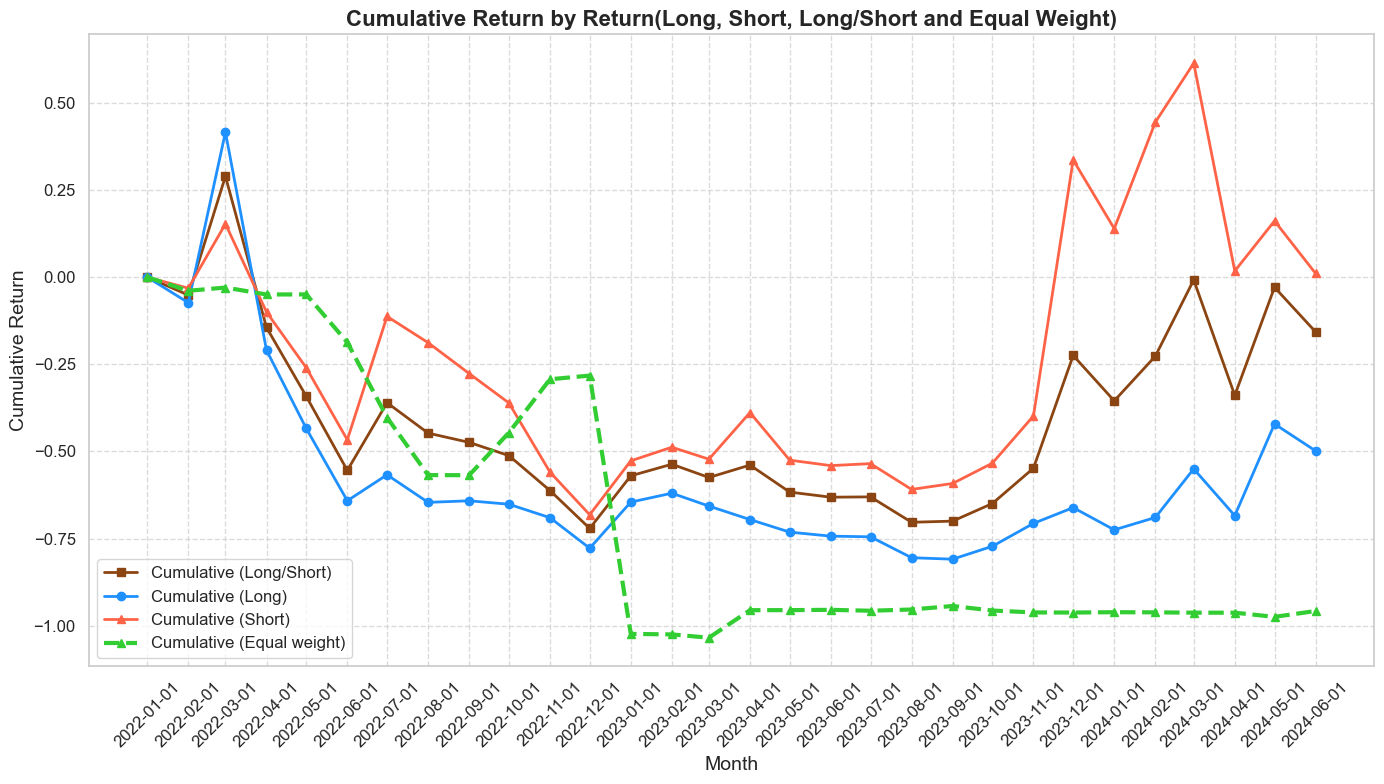

In [ ]:
# Tạo các DataFrame cho Cumulative_long_short, Cumulative_long, và Cumulative_short
import pandas as pd 
import matplotlib.pyplot as plt
Returns =pd.read_csv('profit_CR/Return.csv')
Cumulative =Returns.copy()

# Tính lợi nhuận tích lũy cho từng nhóm
# Cumulative_long_short: Dữ liệu gốc
Cumulative['profit']= (Cumulative['weight'] *  Cumulative['raw_return'])

Cumulative['profit']= (Cumulative['raw_return'])

Cumulative_long_short = Cumulative.copy() 
Cumulative_long_short['symbol_count'] = Cumulative_long_short.groupby('Month')['symbol'].transform('nunique')
Cumulative_long_short = Cumulative_long_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long_short['profit_t'] = Cumulative_long_short['profit'] / Cumulative_long_short['symbol_count']
Cumulative_long_short['Cumulative'] = (1 + Cumulative_long_short['profit_t']).cumprod() - 1

# Cumulative_long: Dữ liệu với weight == 1
Cumulative_long = Cumulative[Cumulative['weight'] == 1].copy() 
Cumulative_long['symbol_count'] = Cumulative_long.groupby('Month')['symbol'].transform('nunique')
Cumulative_long = Cumulative_long.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long['profit_t'] = Cumulative_long['profit'] / Cumulative_long['symbol_count']
Cumulative_long['Cumulative'] = (1 + Cumulative_long['profit_t']).cumprod() - 1

# Cumulative_short: Dữ liệu với weight == -1
Cumulative_short = Cumulative[Cumulative['weight'] == -1].copy() 
Cumulative_short['symbol_count'] = Cumulative_short.groupby('Month')['symbol'].transform('nunique')
Cumulative_short = Cumulative_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_short['profit_t'] = Cumulative_short['profit'] / Cumulative_short['symbol_count']
Cumulative_short['Cumulative'] = (1 + Cumulative_short['profit_t']).cumprod() - 1


#Cumulative_equal_weight
Cumulative_equal_weight = pd.read_csv('profit_CR/equal_weights_return.csv')



# Đảm bảo cột 'Month' có định dạng datetime 
Cumulative_long_short['Month'] = pd.to_datetime(Cumulative_long_short['Month'])
Cumulative_long['Month'] = pd.to_datetime(Cumulative_long['Month'])
Cumulative_short['Month'] = pd.to_datetime(Cumulative_short['Month'])
Cumulative_equal_weight['Month']= pd.to_datetime(Cumulative_equal_weight['Month'])

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tăng kích thước biểu đồ

# Vẽ Cumulative_long_short
plt.plot(Cumulative_long_short['Month'], Cumulative_long_short['Cumulative'], marker='s', linestyle='-', color='#8B4513', linewidth=2, label='Cumulative (Long/Short)')

# Vẽ Cumulative_long
plt.plot(Cumulative_long['Month'], Cumulative_long['Cumulative'], marker='o', linestyle='-', color='#1E90FF', linewidth=2, label='Cumulative (Long)')

# Vẽ Cumulative_short
plt.plot(Cumulative_short['Month'], Cumulative_short['Cumulative'], marker='^', linestyle='-', color='#FF6347', linewidth=2, label='Cumulative (Short)')

# Vẽ Equal weight với thay đổi nét và màu
plt.plot(Cumulative_equal_weight['Month'], Cumulative_equal_weight['Cumulative'], marker='^', linestyle='--', color='#32CD32', linewidth=3, label='Cumulative (Equal weight)')

# Thêm tiêu đề và nhãn với kích thước font lớn hơn
plt.title('Cumulative Return by Return(Long, Short, Long/Short and Equal Weight)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# Tùy chỉnh trục x và hiển thị nhãn trục x là tháng với khoảng cách hợp lý
plt.xticks(pd.date_range(start=Cumulative['Month'].min(), end=Cumulative['Month'].max(), freq='MS'), rotation=45, fontsize=12)

# Tăng cỡ chữ cho nhãn trục y và hiển thị các số liệu dễ đọc hơn
plt.yticks(fontsize=12)

# Hiển thị lưới và legend với font chữ dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Điều chỉnh khoảng cách giữa các điểm trên đồ thị để rõ ràng hơn
plt.tight_layout()

# Lưu và hiển thị biểu đồ
# plt.savefig(f'Profit_CR/CR_Return.png', dpi=300, bbox_inches='tight')
plt.show()


##### **MACD**

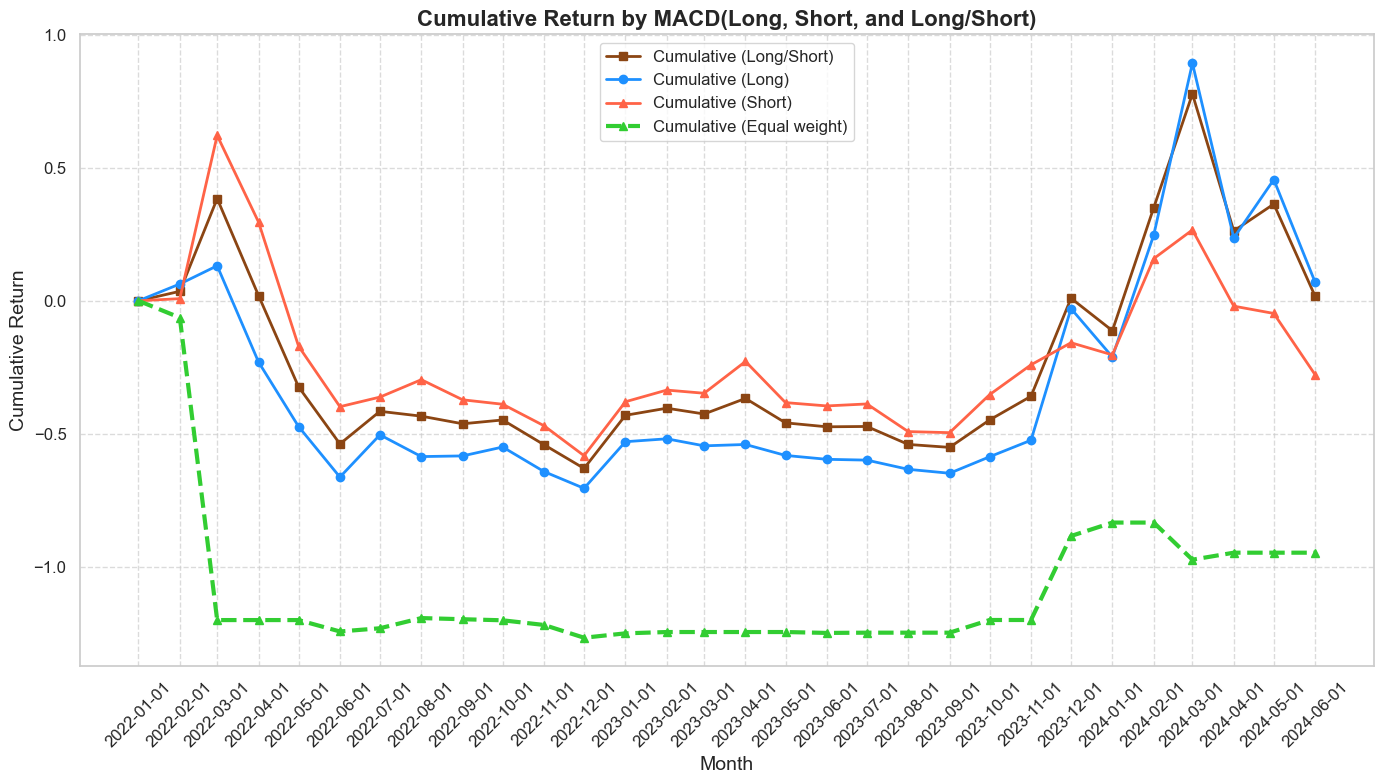

In [ ]:
# Tạo các DataFrame cho Cumulative_long_short, Cumulative_long, và Cumulative_short
MACD =pd.read_csv('profit_CR/MACD.csv')
Cumulative =MACD.copy()
# Tính lợi nhuận tích lũy cho từng nhóm
# Cumulative_long_short: Dữ liệu gốc
# Cumulative['profit']= (Cumulative['weight'] *  Cumulative['raw_return'])
Cumulative['profit']=  Cumulative['raw_return']

Cumulative_long_short = Cumulative.copy() 
Cumulative_long_short['symbol_count'] = Cumulative_long_short.groupby('Month')['symbol'].transform('nunique')
Cumulative_long_short = Cumulative_long_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long_short['profit_t'] = Cumulative_long_short['profit'] / Cumulative_long_short['symbol_count']
Cumulative_long_short['Cumulative'] = (1 + Cumulative_long_short['profit_t']).cumprod() - 1

# Cumulative_long: Dữ liệu với weight == 1
Cumulative_long = Cumulative[Cumulative['weight'] == 1].copy() 
Cumulative_long['symbol_count'] = Cumulative_long.groupby('Month')['symbol'].transform('nunique')
Cumulative_long = Cumulative_long.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long['profit_t'] = Cumulative_long['profit'] / Cumulative_long['symbol_count']
Cumulative_long['Cumulative'] = (1 + Cumulative_long['profit_t']).cumprod() - 1

# Cumulative_short: Dữ liệu với weight == -1
Cumulative_short = Cumulative[Cumulative['weight'] == -1].copy() 
Cumulative_short['symbol_count'] = Cumulative_short.groupby('Month')['symbol'].transform('nunique')
Cumulative_short = Cumulative_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_short['profit_t'] = Cumulative_short['profit'] / Cumulative_short['symbol_count']
Cumulative_short['Cumulative'] = (1 + Cumulative_short['profit_t']).cumprod() - 1
#Cumulative_equal_weight
Cumulative_equal_weight = pd.read_csv('profit_CR/equal_weight_MACD.csv')

# Đảm bảo cột 'Month' có định dạng datetime
Cumulative_long_short['Month'] = pd.to_datetime(Cumulative_long_short['Month'])
Cumulative_long['Month'] = pd.to_datetime(Cumulative_long['Month'])
Cumulative_short['Month'] = pd.to_datetime(Cumulative_short['Month'])
Cumulative_equal_weight['Month'] = pd.to_datetime(Cumulative_equal_weight['Month'])

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tăng kích thước biểu đồ

# Vẽ Cumulative_long_short
plt.plot(Cumulative_long_short['Month'], Cumulative_long_short['Cumulative'], marker='s', linestyle='-', color='#8B4513', linewidth=2, label='Cumulative (Long/Short)')

# Vẽ Cumulative_long
plt.plot(Cumulative_long['Month'], Cumulative_long['Cumulative'], marker='o', linestyle='-', color='#1E90FF', linewidth=2, label='Cumulative (Long)')

# Vẽ Cumulative_short
plt.plot(Cumulative_short['Month'], Cumulative_short['Cumulative'], marker='^', linestyle='-', color='#FF6347', linewidth=2, label='Cumulative (Short)')

# Vẽ Equal weight với thay đổi nét và màu
plt.plot(Cumulative_equal_weight['Month'], Cumulative_equal_weight['Cumulative'], marker='^', linestyle='--', color='#32CD32', linewidth=3, label='Cumulative (Equal weight)')
# Thêm tiêu đề và nhãn với kích thước font lớn hơn
plt.title('Cumulative Return by MACD(Long, Short, and Long/Short)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# Tùy chỉnh trục x và hiển thị nhãn trục x là tháng với khoảng cách hợp lý
plt.xticks(pd.date_range(start=Cumulative['Month'].min(), end=Cumulative['Month'].max(), freq='MS'), rotation=45, fontsize=12)

# Tăng cỡ chữ cho nhãn trục y và hiển thị các số liệu dễ đọc hơn
plt.yticks(fontsize=12)

# Hiển thị lưới và legend với font chữ dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Điều chỉnh khoảng cách giữa các điểm trên đồ thị để rõ ràng hơn
plt.tight_layout()

# Lưu và hiển thị biểu đồ
plt.savefig(f'Profit_CR/CR_MACD.png', dpi=300, bbox_inches='tight')
plt.show()

##### **LambdaMART**

C:\Users\tranm\AppData\Local\Temp\ipykernel_2704\3895365425.py:59: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Cumulative_long_short["Cumulative"].iloc[0] = 0
C:\Users\tranm\AppData\Local\Temp\ipykernel_2704\3895365425.py:59: SettingWithCo

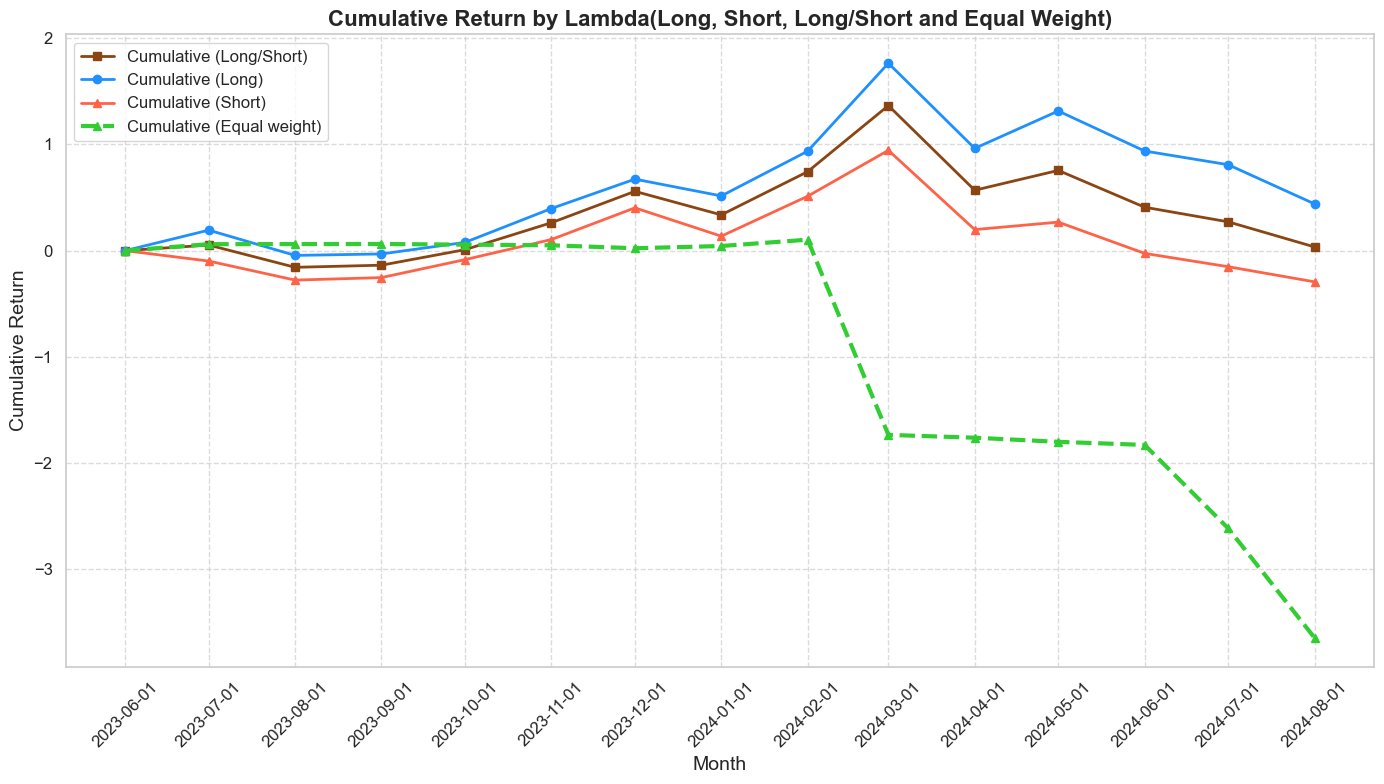

In [ ]:
lambdaa =pd.read_csv('profit_CR/lambda.csv')
lambdaa =lambdaa.copy()
Cumulative_long_short =lambdaa.copy()

Cumulative_long_short= Cumulative_long_short[Cumulative_long_short['predict_rank'] != 0 ]
Cumulative_long_short['Month'] = pd.to_datetime(Cumulative_long_short['Month'])
# Cumulative_long_short['profit']= Cumulative_long_short['predict_rank'] *Cumulative_long_short['raw_return']
Cumulative_long_short['profit']= Cumulative_long_short['raw_return']
Cumulative_long_short['symbol_count'] = Cumulative_long_short.groupby('Month')['symbol'].transform('nunique')

Cumulative_long_short = Cumulative_long_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long_short['profit_t'] = Cumulative_long_short['profit'] / Cumulative_long_short['symbol_count']
Cumulative_long_short['Cumulative'] = (1 + Cumulative_long_short['profit_t']).cumprod() - 1

### long  

Cumulative_long =Cumulative[Cumulative['predict_rank'] == 1 ].copy()


Cumulative_long['Month'] = pd.to_datetime(Cumulative_long['Month'])
# Cumulative_long['profit']= Cumulative_long['predict_rank'] *Cumulative_long['raw_return']
Cumulative_long['profit']= Cumulative_long['raw_return']
Cumulative_long['symbol_count'] = Cumulative_long.groupby('Month')['symbol'].transform('nunique')

Cumulative_long = Cumulative_long.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long['profit_t'] = Cumulative_long['profit'] / Cumulative_long['symbol_count']
Cumulative_long['Cumulative'] = (1 + Cumulative_long['profit_t']).cumprod() - 1
## short



Cumulative_short =Cumulative[Cumulative['predict_rank'] == -1 ].copy()


Cumulative_short['Month'] = pd.to_datetime(Cumulative_short['Month'])
# Cumulative_short['profit']= Cumulative_short['predict_rank'] *Cumulative_short['raw_return']
Cumulative_short['profit']= Cumulative_short['raw_return']
Cumulative_short['symbol_count'] = Cumulative_short.groupby('Month')['symbol'].transform('nunique')

Cumulative_short = Cumulative_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_short['profit_t'] = Cumulative_short['profit'] / Cumulative_short['symbol_count']
Cumulative_short['Cumulative'] = (1 + Cumulative_short['profit_t']).cumprod() - 1
## 
Cumulative_equal_weight = pd.read_csv('profit_CR/EW_LambdaMART.csv')
Cumulative_equal_weight['Month'] = pd.to_datetime(Cumulative_equal_weight['Month'])
# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tăng kích thước biểu đồ


Cumulative_long_short["Cumulative"].iloc[0] = 0
Cumulative_long["Cumulative"].iloc[0] = 0
Cumulative_short["Cumulative"].iloc[0] = 0
Cumulative_equal_weight["Cumulative"].iloc[0] = 0


# Vẽ Cumulative_long_short
plt.plot(Cumulative_long_short['Month'], Cumulative_long_short['Cumulative'], marker='s', linestyle='-', color='#8B4513', linewidth=2, label='Cumulative (Long/Short)')

# Vẽ Cumulative_long
plt.plot(Cumulative_long['Month'], Cumulative_long['Cumulative'], marker='o', linestyle='-', color='#1E90FF', linewidth=2, label='Cumulative (Long)')

# Vẽ Cumulative_short
plt.plot(Cumulative_short['Month'], Cumulative_short['Cumulative'], marker='^', linestyle='-', color='#FF6347', linewidth=2, label='Cumulative (Short)')

# Vẽ Equal weight với thay đổi nét và màu
plt.plot(Cumulative_equal_weight['Month'], Cumulative_equal_weight['Cumulative'], marker='^', linestyle='--', color='#32CD32', linewidth=3, label='Cumulative (Equal weight)')

# Thêm tiêu đề và nhãn với kích thước font lớn hơn
plt.title('Cumulative Return by Lambda(Long, Short, Long/Short and Equal Weight)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# Tùy chỉnh trục x và hiển thị nhãn trục x là tháng với khoảng cách hợp lý
plt.xticks(pd.date_range(start=Cumulative['Month'].min(), end=Cumulative['Month'].max(), freq='MS'), rotation=45, fontsize=12)

# Tăng cỡ chữ cho nhãn trục y và hiển thị các số liệu dễ đọc hơn
plt.yticks(fontsize=12)

# Hiển thị lưới và legend với font chữ dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Điều chỉnh khoảng cách giữa các điểm trên đồ thị để rõ ràng hơn
plt.tight_layout()

# Lưu và hiển thị biểu đồ
plt.savefig(f'Profit_CR/CR_Lambda.png', dpi=300, bbox_inches='tight')
plt.show()

##### **Random Forest**

C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\1406290062.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Cumulative_long_short["Cumulative"].iloc[0] = 0
C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\1406290062.py:65: SettingWith

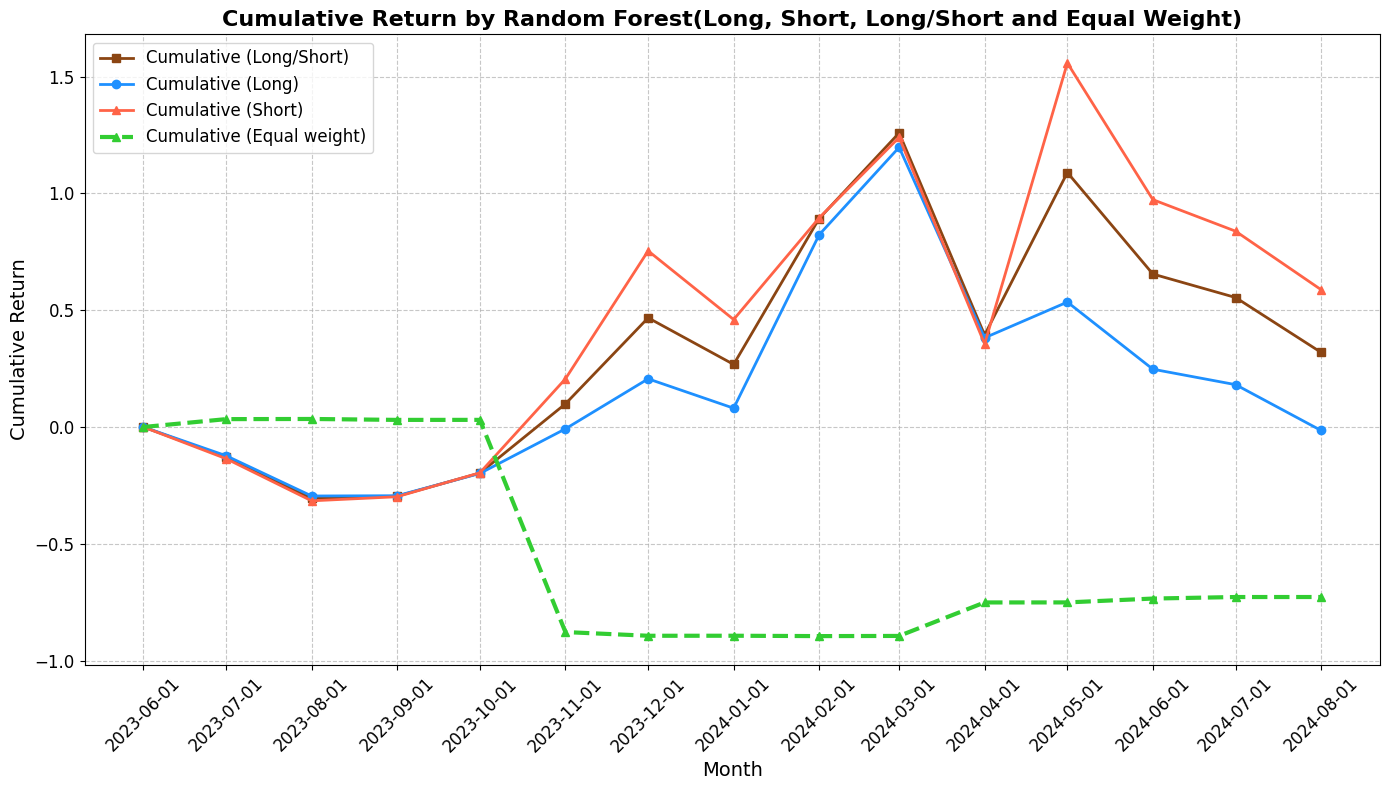

In [ ]:
# Giả sử bạn đã có DataFrame Cumulative với cột 'Month' và 'Cumulative'
randomfr_rank = pd.read_csv('RandomForest_rank.csv')
data2 = randomfr_rank[randomfr_rank['Month']>= '2023-06']
# data2['Month'] = data2['Month'].dt.to_period('M')
Cumulative =data2.copy()

Cumulative_long_short =Cumulative.copy()

Cumulative_long_short= Cumulative_long_short[Cumulative_long_short['PredictedRank'] != 0 ]
Cumulative_long_short['Month'] = pd.to_datetime(Cumulative_long_short['Month'])
# Cumulative_long_short['profit']= Cumulative_long_short['PredictedRank'] *Cumulative_long_short['Returns']
Cumulative_long_short['profit']= Cumulative_long_short['Returns']
Cumulative_long_short['symbol_count'] = Cumulative_long_short.groupby('Month')['Symbol'].transform('nunique')

Cumulative_long_short = Cumulative_long_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long_short['profit_t'] = Cumulative_long_short['profit'] / Cumulative_long_short['symbol_count']
Cumulative_long_short['Cumulative'] = (1 + Cumulative_long_short['profit_t']).cumprod() - 1

### long  

Cumulative_long =Cumulative[Cumulative['PredictedRank'] == 1 ].copy()


Cumulative_long['Month'] = pd.to_datetime(Cumulative_long['Month'])
# Cumulative_long['profit']= Cumulative_long['PredictedRank'] *Cumulative_long['Returns']

Cumulative_long['profit']= Cumulative_long['Returns']
Cumulative_long['symbol_count'] = Cumulative_long.groupby('Month')['Symbol'].transform('nunique')

Cumulative_long = Cumulative_long.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long['profit_t'] = Cumulative_long['profit'] / Cumulative_long['symbol_count']
Cumulative_long['Cumulative'] = (1 + Cumulative_long['profit_t']).cumprod() - 1
## short



Cumulative_short =Cumulative[Cumulative['PredictedRank'] == -1 ].copy()


Cumulative_short['Month'] = pd.to_datetime(Cumulative_short['Month'])
# Cumulative_short['profit']= Cumulative_short['PredictedRank'] *Cumulative_short['Returns']
Cumulative_short['profit']= Cumulative_short['Returns']
Cumulative_short['symbol_count'] = Cumulative_short.groupby('Month')['Symbol'].transform('nunique')

Cumulative_short = Cumulative_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_short['profit_t'] = Cumulative_short['profit'] / Cumulative_short['symbol_count']
Cumulative_short['Cumulative'] = (1 + Cumulative_short['profit_t']).cumprod() - 1


### equal_weight
Cumulative_equal_weight = pd.read_csv('profit_CR/EW_RF.csv')
Cumulative_equal_weight['Month'] = pd.to_datetime(Cumulative_equal_weight['Month'])



Cumulative_long_short["Cumulative"].iloc[0] = 0
Cumulative_long["Cumulative"].iloc[0] = 0
Cumulative_short["Cumulative"].iloc[0] = 0
Cumulative_equal_weight["Cumulative"].iloc[0] = 0

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tăng kích thước biểu đồ

# Vẽ Cumulative_long_short
plt.plot(Cumulative_long_short['Month'], Cumulative_long_short['Cumulative'], marker='s', linestyle='-', color='#8B4513', linewidth=2, label='Cumulative (Long/Short)')

# Vẽ Cumulative_long
plt.plot(Cumulative_long['Month'], Cumulative_long['Cumulative'], marker='o', linestyle='-', color='#1E90FF', linewidth=2, label='Cumulative (Long)')

# Vẽ Cumulative_short
plt.plot(Cumulative_short['Month'], Cumulative_short['Cumulative'], marker='^', linestyle='-', color='#FF6347', linewidth=2, label='Cumulative (Short)')

# Vẽ Equal weight với thay đổi nét và màu
plt.plot(Cumulative_equal_weight['Month'], Cumulative_equal_weight['Cumulative'], marker='^', linestyle='--', color='#32CD32', linewidth=3, label='Cumulative (Equal weight)')

# Thêm tiêu đề và nhãn với kích thước font lớn hơn
plt.title('Cumulative Return by Random Forest(Long, Short, Long/Short and Equal Weight)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# Tùy chỉnh trục x và hiển thị nhãn trục x là tháng với khoảng cách hợp lý
plt.xticks(pd.date_range(start=Cumulative['Month'].min(), end=Cumulative['Month'].max(), freq='MS'), rotation=45, fontsize=12)

# Tăng cỡ chữ cho nhãn trục y và hiển thị các số liệu dễ đọc hơn
plt.yticks(fontsize=12)

# Hiển thị lưới và legend với font chữ dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Điều chỉnh khoảng cách giữa các điểm trên đồ thị để rõ ràng hơn
plt.tight_layout()

# Lưu và hiển thị biểu đồ
plt.savefig(f'Profit_CR/CR_RF.png', dpi=300, bbox_inches='tight')
plt.show()

##### **ListNet**

C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\2451806193.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Cumulative_long_short["Cumulative"].iloc[0] = 0
C:\Users\tranm\AppData\Local\Temp\ipykernel_41288\2451806193.py:62: SettingWith

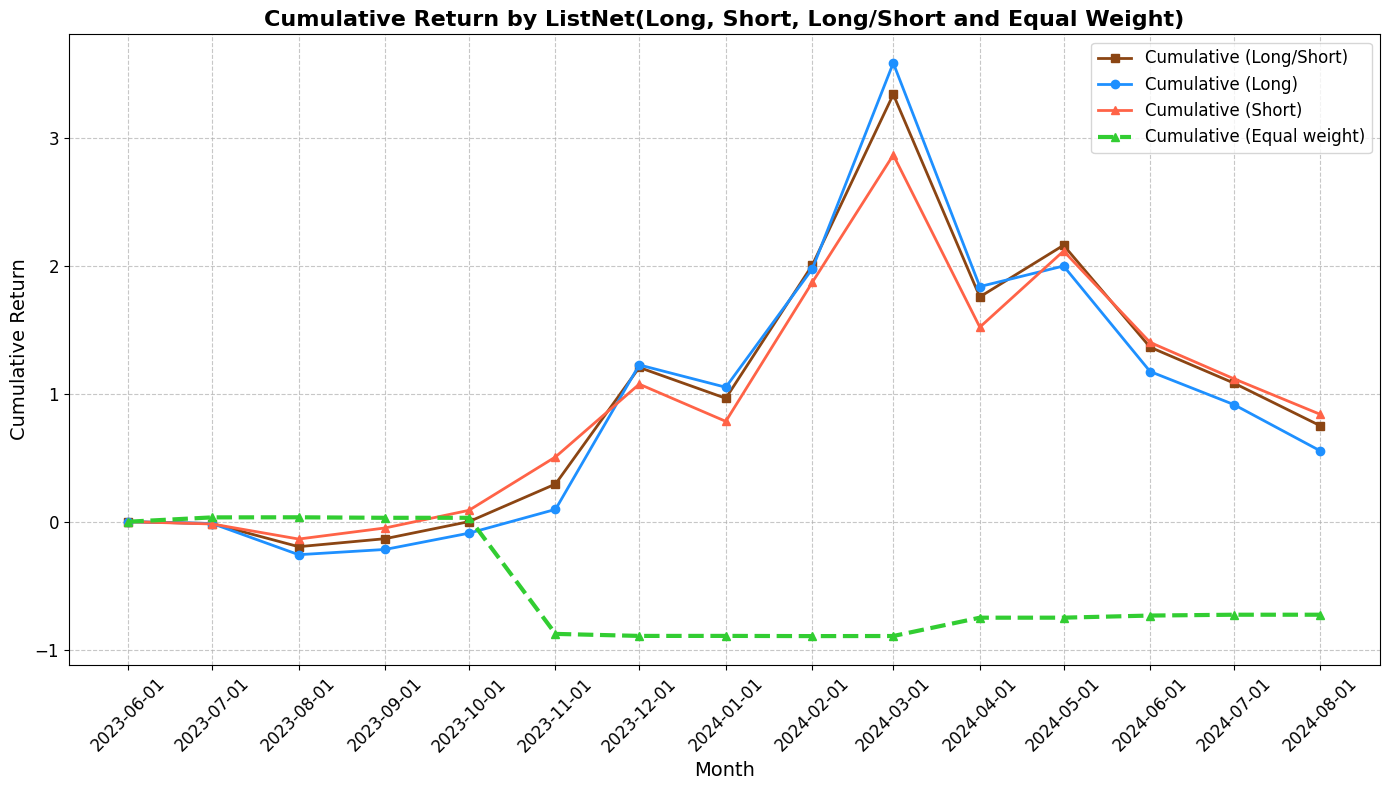

In [ ]:
# Giả sử bạn đã có DataFrame Cumulative với cột 'Month' và 'Cumulative'
listnet_rank = pd.read_csv('profit_CR/ListNet_rank.csv')
data2 = listnet_rank[listnet_rank['Month']>= '2023-06']
# data2['Month'] = data2['Month'].dt.to_period('M')
Cumulative =data2.copy()
Cumulative_long_short =Cumulative.copy()
Cumulative_long_short= Cumulative_long_short[Cumulative_long_short['PredictedRank'] != 0 ]
Cumulative_long_short['Month'] = pd.to_datetime(Cumulative_long_short['Month'])
# Cumulative_long_short['profit']= Cumulative_long_short['PredictedRank'] *Cumulative_long_short['Returns']
Cumulative_long_short['profit']= Cumulative_long_short['Returns']
Cumulative_long_short['symbol_count'] = Cumulative_long_short.groupby('Month')['Symbol'].transform('nunique')

Cumulative_long_short = Cumulative_long_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long_short['profit_t'] = Cumulative_long_short['profit'] / Cumulative_long_short['symbol_count']
Cumulative_long_short['Cumulative'] = (1 + Cumulative_long_short['profit_t']).cumprod() - 1

### long  

Cumulative_long =Cumulative[Cumulative['PredictedRank'] == 1 ].copy()


Cumulative_long['Month'] = pd.to_datetime(Cumulative_long['Month'])
# Cumulative_long['profit']= Cumulative_long['PredictedRank'] *Cumulative_long['Returns']

Cumulative_long['profit']= Cumulative_long['Returns']
Cumulative_long['symbol_count'] = Cumulative_long.groupby('Month')['Symbol'].transform('nunique')

Cumulative_long = Cumulative_long.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_long['profit_t'] = Cumulative_long['profit'] / Cumulative_long['symbol_count']
Cumulative_long['Cumulative'] = (1 + Cumulative_long['profit_t']).cumprod() - 1
## short



Cumulative_short =Cumulative[Cumulative['PredictedRank'] == -1 ].copy()


Cumulative_short['Month'] = pd.to_datetime(Cumulative_short['Month'])
# Cumulative_short['profit']= Cumulative_short['PredictedRank'] *Cumulative_short['Returns']
Cumulative_short['profit']= Cumulative_short['Returns']
Cumulative_short['symbol_count'] = Cumulative_short.groupby('Month')['Symbol'].transform('nunique')

Cumulative_short = Cumulative_short.groupby('Month').agg({
    'profit': 'sum',
    'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
}).reset_index()
Cumulative_short['profit_t'] = Cumulative_short['profit'] / Cumulative_short['symbol_count']
Cumulative_short['Cumulative'] = (1 + Cumulative_short['profit_t']).cumprod() - 1


### equal_weight
Cumulative_equal_weight = pd.read_csv('profit_CR/EW_RF.csv')
Cumulative_equal_weight['Month'] = pd.to_datetime(Cumulative_equal_weight['Month'])


Cumulative_long_short["Cumulative"].iloc[0] = 0
Cumulative_long["Cumulative"].iloc[0] = 0
Cumulative_short["Cumulative"].iloc[0] = 0
Cumulative_equal_weight["Cumulative"].iloc[0] = 0

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tăng kích thước biểu đồ

# Vẽ Cumulative_long_short
plt.plot(Cumulative_long_short['Month'], Cumulative_long_short['Cumulative'], marker='s', linestyle='-', color='#8B4513', linewidth=2, label='Cumulative (Long/Short)')

# Vẽ Cumulative_long
plt.plot(Cumulative_long['Month'], Cumulative_long['Cumulative'], marker='o', linestyle='-', color='#1E90FF', linewidth=2, label='Cumulative (Long)')

# Vẽ Cumulative_short
plt.plot(Cumulative_short['Month'], Cumulative_short['Cumulative'], marker='^', linestyle='-', color='#FF6347', linewidth=2, label='Cumulative (Short)')

# Vẽ Equal weight với thay đổi nét và màu
plt.plot(Cumulative_equal_weight['Month'], Cumulative_equal_weight['Cumulative'], marker='^', linestyle='--', color='#32CD32', linewidth=3, label='Cumulative (Equal weight)')

# Thêm tiêu đề và nhãn với kích thước font lớn hơn
plt.title('Cumulative Return by ListNet(Long, Short, Long/Short and Equal Weight)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# Tùy chỉnh trục x và hiển thị nhãn trục x là tháng với khoảng cách hợp lý
plt.xticks(pd.date_range(start=Cumulative['Month'].min(), end=Cumulative['Month'].max(), freq='MS'), rotation=45, fontsize=12)

# Tăng cỡ chữ cho nhãn trục y và hiển thị các số liệu dễ đọc hơn
plt.yticks(fontsize=12)

# Hiển thị lưới và legend với font chữ dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Điều chỉnh khoảng cách giữa các điểm trên đồ thị để rõ ràng hơn
plt.tight_layout()

# Lưu và hiển thị biểu đồ
plt.savefig(f'Profit_CR/CR_ListNet.png', dpi=300, bbox_inches='tight')
plt.show()

#### **So sánh các phương thức với mô hình xếp hạng** 

In [ ]:
pr_lambda = pd.read_csv('profit_CR/lambda.csv')
pr_MACD = pd.read_csv('profit_CR/MACD.csv')
pr_rand = pd.read_csv('profit_CR/Randomforest_rank.csv')
pr_return = pd.read_csv('profit_CR/return.csv')
pr_listnet = pd.read_csv('profit_CR/ListNet_rank.csv')

pr_listnet['Profit'] = pr_listnet['PredictedRank'] * pr_listnet['Returns']
pr_lambda['Profit'] = pr_lambda['predict_rank'] * pr_lambda['raw_return']
pr_MACD['Profit'] = pr_MACD['weight'] * pr_MACD['raw_return']
pr_rand['Profit'] = pr_rand['PredictedRank'] * pr_rand['Returns']
pr_return['Profit'] = pr_return['weight'] * pr_return['raw_return']

pr_listnet.columns = pr_listnet.columns.str.lower()
pr_rand.columns = pr_rand.columns.str.lower()
pr_return.columns = pr_return.columns.str.lower()
pr_MACD.columns = pr_MACD.columns.str.lower()
pr_lambda.columns = pr_lambda.columns.str.lower()
def calculate_monthly_profit(dataframe):
    # Tính tổng profit theo tháng và sắp xếp
    grouped_df = dataframe
    grouped_df['symbol_count'] = grouped_df.groupby('month')['symbol'].transform('nunique')
    grouped_df = grouped_df.groupby('month').agg({
        'profit': 'sum',
        'symbol_count': 'first'  # Lấy số lượng symbol (đã tính ở trên)
    }).reset_index()
    grouped_df = grouped_df.sort_values(by='month', ascending=True).reset_index(drop=True)
    grouped_df['profit_t'] = grouped_df['profit'] / grouped_df['symbol_count']
    return grouped_df

# Áp dụng hàm cho từng DataFrame
pr_rand_grouped = calculate_monthly_profit(pr_rand)
pr_return_grouped = calculate_monthly_profit(pr_return)
pr_MACD_grouped = calculate_monthly_profit(pr_MACD)
pr_lambda_grouped = calculate_monthly_profit(pr_lambda)
pr_listnet_grouped = calculate_monthly_profit(pr_listnet)
pr_listnet_grouped = pr_listnet_grouped[pr_listnet_grouped['month']>= '2023-06']
pr_rand_grouped = pr_rand_grouped[pr_rand_grouped['month']>= '2023-06']

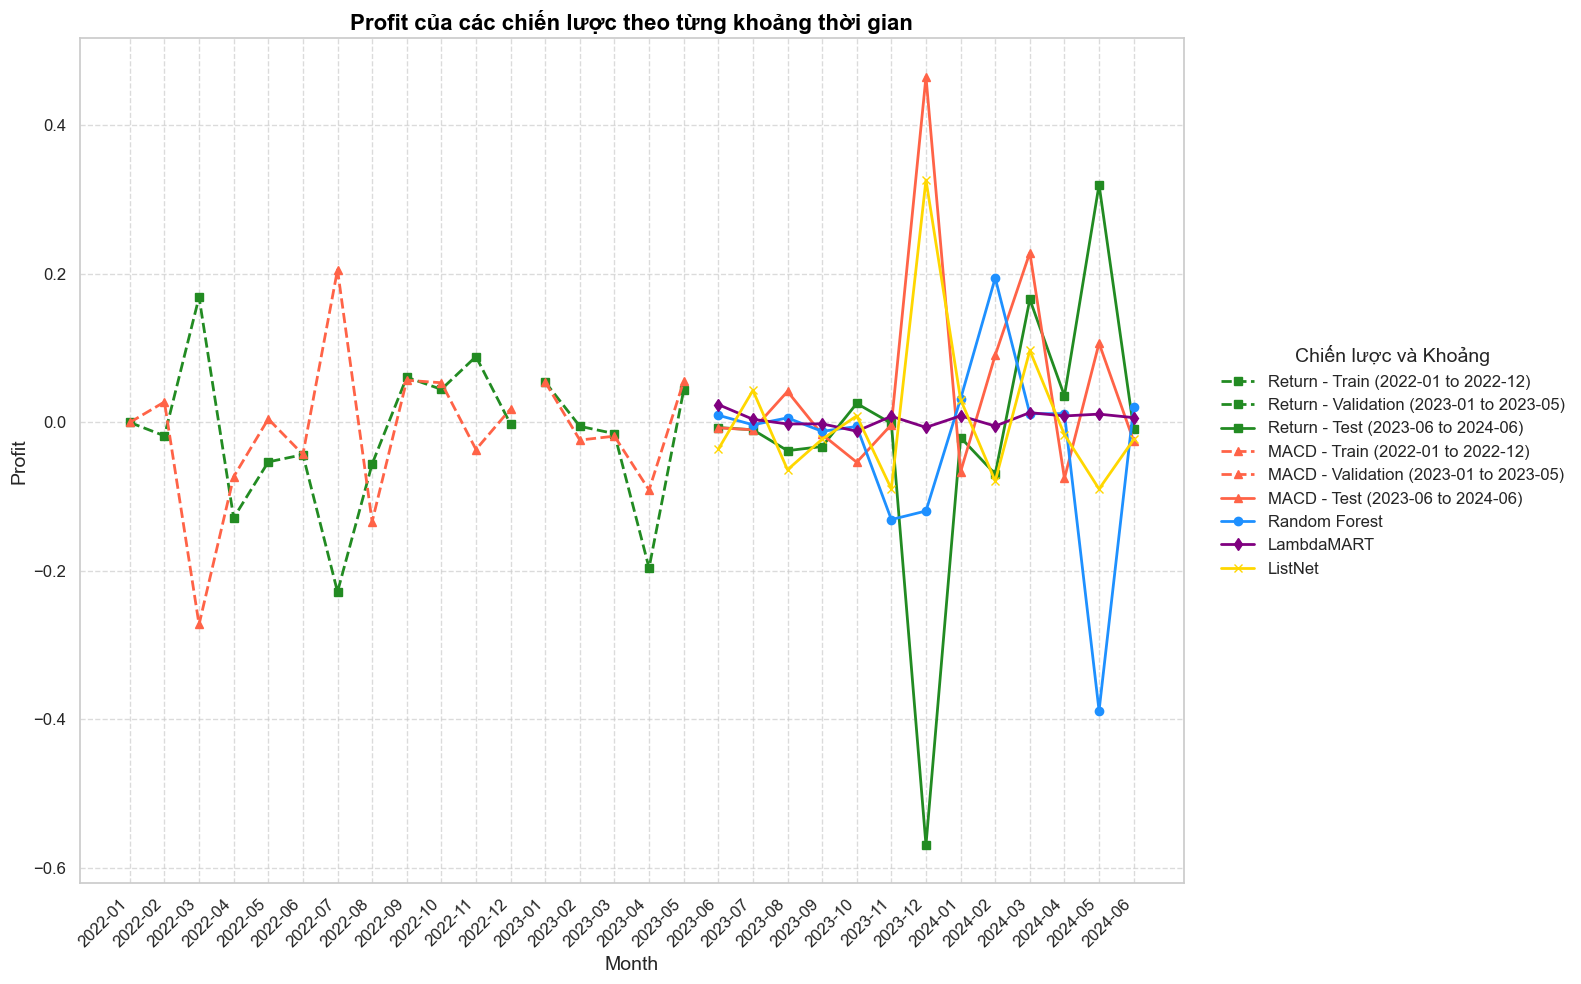

In [ ]:
# Cài đặt style
sns.set(style="whitegrid")

# Tạo biểu đồ mới với kích thước lớn
plt.figure(figsize=(16, 10))

# Chia các khoảng thời gian và định nghĩa đường nét
time_ranges = {
    'Train (2022-01 to 2022-12)': ('2022-01', '2022-12', '--'),
    'Validation (2023-01 to 2023-05)': ('2023-01', '2023-05', '--'),
    'Test (2023-06 to 2024-06)': ('2023-06', '2024-06', '-'),
}

# Danh sách các chiến lược cần vẽ
strategies = [
    ('Return', pr_return_grouped, 'forestgreen', 's', True),  # Chỉ vẽ chú thích khoảng thời gian
    ('MACD', pr_MACD_grouped, 'tomato', '^', True),           # Chỉ vẽ chú thích khoảng thời gian
    ('Random Forest', pr_rand_grouped, 'dodgerblue', 'o', False),  # Không vẽ chú thích khoảng thời gian
    ('LambdaMART', pr_lambda_grouped, 'purple', 'd', False),   
     ('ListNet', pr_listnet_grouped, 'gold', 'x', False) # Không vẽ chú thích khoảng thời gian
]

# Vẽ từng chiến lược với từng khoảng thời gian
for strategy_name, df, color, marker, use_time_legend in strategies:
    for range_name, (start, end, linestyle) in time_ranges.items():
        # Lọc dữ liệu theo khoảng thời gian
        filtered_df = df[(df['month'] >= start) & (df['month'] <= end)]
        
        # Thêm chú thích khoảng thời gian chỉ cho Return và MACD
        label = f'{strategy_name} - {range_name}' if use_time_legend else strategy_name
        
        # Vẽ biểu đồ
        plt.plot(
            filtered_df['month'],
            filtered_df['profit_t'],
            label=label if linestyle == '-' or use_time_legend else "",  # Giảm chú thích lặp lại
            color=color,
            linewidth=2,
            marker=marker,
            markersize=6,
            linestyle=linestyle,
        )

# Thêm tiêu đề và nhãn
plt.title('Profit của các chiến lược theo từng khoảng thời gian', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Profit', fontsize=14)

# Tùy chỉnh legend: đặt bên ngoài biểu đồ
plt.legend(
    title='Chiến lược và Khoảng', 
    loc='center left', 
    bbox_to_anchor=(1.02, 0.5),  # Đặt chú thích bên phải biểu đồ
    fontsize=12, 
    title_fontsize=14, 
    frameon=False  # Loại bỏ khung chú thích
)

# Thêm lưới cho biểu đồ
plt.grid(True, linestyle='--', alpha=0.7)

# Xoay nhãn trên trục x và tùy chỉnh kích thước font chữ
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Đảm bảo bố cục biểu đồ gọn gàng
plt.tight_layout()
plt.savefig(f'Profit_CR/Profit_month.png', dpi=300, bbox_inches='tight')
# Hiển thị biểu đồ
plt.show()


### **Thống kê**

In [45]:

dfl = pd.read_csv("data/processed/processed_data_long_short_train.csv")
df2 = pd.read_csv("data/processed/processed_data_only_short_train.csv")
df3 = pd.read_csv("data/processed/processed_data_only_long_train.csv")
df4 = pd.read_csv("data/processed/processed_equal_weights_data_train.csv")

# Thêm cột 'Strategy' cho từng chiến lược
dfl['Strategy'] = 'Long-Short'
df2['Strategy'] = 'Only Short'
df3['Strategy'] = 'Only Long'
df4['Strategy'] = 'Equal Weights'

# Kết hợp các dữ liệu lại
combined_df = pd.concat([dfl, df2, df3, df4])

# Tiến hành kiểm định ANOVA
anova_results = []

for period in ['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']:
    # Lấy dữ liệu lợi nhuận cho từng chiến lược
    long_short_returns = dfl[period]
    only_short_returns = df2[period]
    only_long_returns = df3[period]
    equal_weights_returns = df4[period]

    # Kiểm tra nếu có đủ dữ liệu để thực hiện kiểm định ANOVA
    if len(long_short_returns) > 1 and len(only_short_returns) > 1 and len(only_long_returns) > 1 and len(equal_weights_returns) > 1:
        f_stat, p_value = stats.f_oneway(long_short_returns, only_short_returns, only_long_returns, equal_weights_returns)
        
        # Lưu kết quả ANOVA và chiến lược vào bảng
        anova_results.append({
            'Period': period,
            'Strategy': 'Long-Short',  # Thêm chiến lược vào bảng kết quả
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significance': 'Significant' if p_value < 0.05 else 'Not Significant'
        })
        
        anova_results.append({
            'Period': period,
            'Strategy': 'Only Short',  # Thêm chiến lược vào bảng kết quả
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significance': 'Significant' if p_value < 0.05 else 'Not Significant'
        })
        
        anova_results.append({
            'Period': period,
            'Strategy': 'Only Long',  # Thêm chiến lược vào bảng kết quả
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significance': 'Significant' if p_value < 0.05 else 'Not Significant'
        })
        
        anova_results.append({
            'Period': period,
            'Strategy': 'Equal Weights',  # Thêm chiến lược vào bảng kết quả
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significance': 'Significant' if p_value < 0.05 else 'Not Significant'
        })
    else:
        # Nếu không đủ dữ liệu, trả về 'N/A'
        anova_results.append({
            'Period': period,
            'Strategy': 'Insufficient Data',
            'F-statistic': 'N/A',
            'P-value': 'N/A',
            'Significance': 'Insufficient Data'
        })

# Chuyển kết quả thành DataFrame
anova_df = pd.DataFrame(anova_results)

# Hiển thị kết quả
print(anova_df)


             Period       Strategy  F-statistic       P-value Significance
0    return_3_month     Long-Short    22.435764  3.111694e-14  Significant
1    return_3_month     Only Short    22.435764  3.111694e-14  Significant
2    return_3_month      Only Long    22.435764  3.111694e-14  Significant
3    return_3_month  Equal Weights    22.435764  3.111694e-14  Significant
4    return_6_month     Long-Short    41.699398  5.880058e-26  Significant
5    return_6_month     Only Short    41.699398  5.880058e-26  Significant
6    return_6_month      Only Long    41.699398  5.880058e-26  Significant
7    return_6_month  Equal Weights    41.699398  5.880058e-26  Significant
8    return_9_month     Long-Short    52.228031  3.181147e-32  Significant
9    return_9_month     Only Short    52.228031  3.181147e-32  Significant
10   return_9_month      Only Long    52.228031  3.181147e-32  Significant
11   return_9_month  Equal Weights    52.228031  3.181147e-32  Significant
12  return_12_month     L

**Nhận xét về Kết quả Kiểm định F-statistic và P-value**

- Tất cả các chiến lược giao dịch qua các khoảng thời gian 3 tháng, 6 tháng, 9 tháng, và 12 tháng đều có giá trị **F-statistic** cao và **P-value** rất nhỏ (gần như bằng 0), cho thấy kết quả kiểm định có ý nghĩa thống kê (**Significant**) với mức độ tin cậy cao.
  
- **Chiến lược Long-Short** cho từng khung thời gian đều có giá trị **F-statistic** lần lượt là 22.435764 (3 tháng), 41.699398 (6 tháng), 52.228031 (9 tháng), và 53.645831 (12 tháng). Giá trị F-statistic tăng dần khi kéo dài khung thời gian, cho thấy sự tăng cường hiệu quả khi mở rộng khoảng thời gian giao dịch.

- Các chiến lược **Only Long**, **Only Short**, và **Equal Weights** đều có giá trị kiểm định tương tự nhau trong từng khung thời gian, với kết quả nhất quán cho thấy rằng chúng đều có ý nghĩa thống kê.

- **Chiến lược giao dịch 12 tháng** có F-statistic lớn nhất (53.645831), phản ánh mức độ phân biệt mạnh mẽ nhất giữa các nhóm lợi nhuận, và cũng thể hiện hiệu quả tốt hơn khi so sánh với các khung thời gian ngắn hơn.

**Kết luận**

Kết quả kiểm định F-statistic và P-value cho thấy sự khác biệt có ý nghĩa giữa các chiến lược giao dịch trong mỗi khung thời gian. Các chiến lược này đều cho thấy tính ổn định và hiệu suất mạnh mẽ với mức độ tin cậy cao, đặc biệt khi áp dụng cho chiến lược Long-Short và các khung thời gian dài hơn.


c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


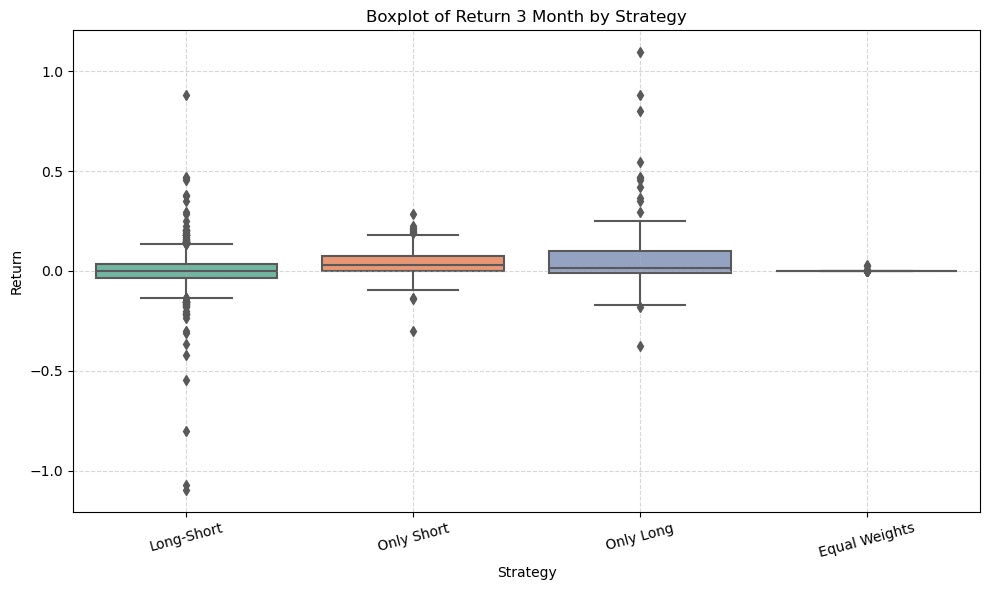

c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


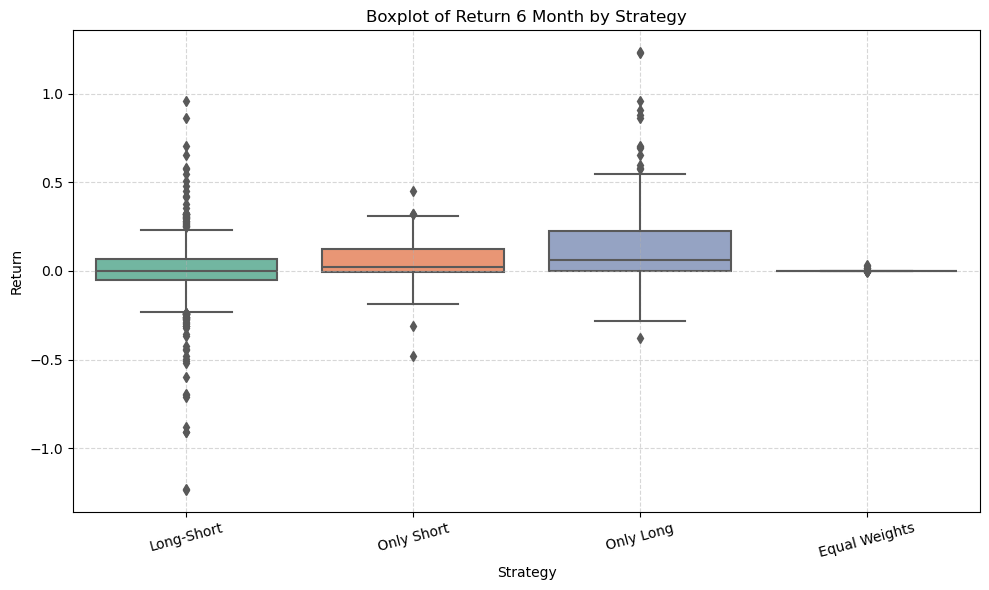

c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


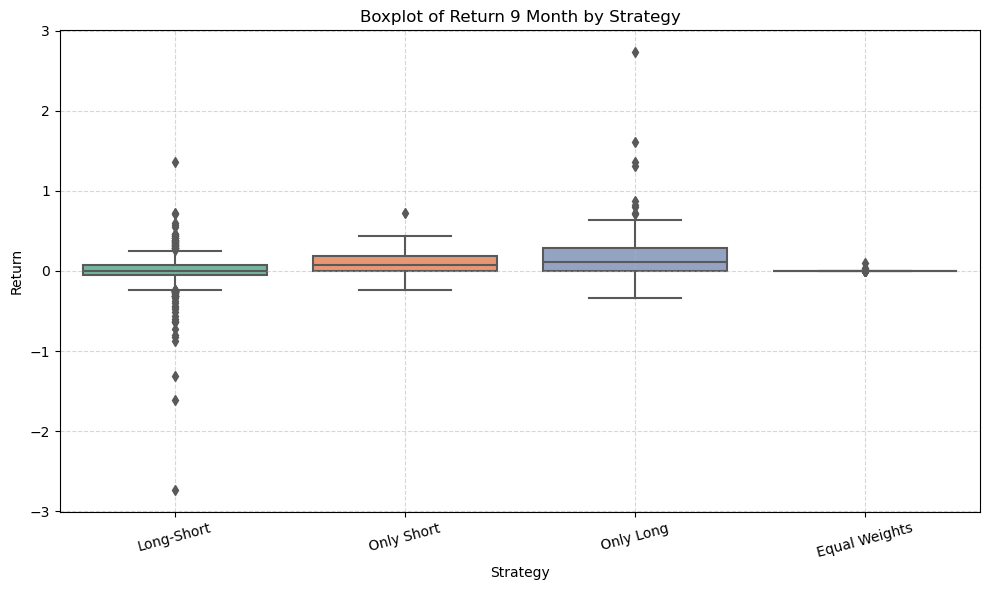

c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


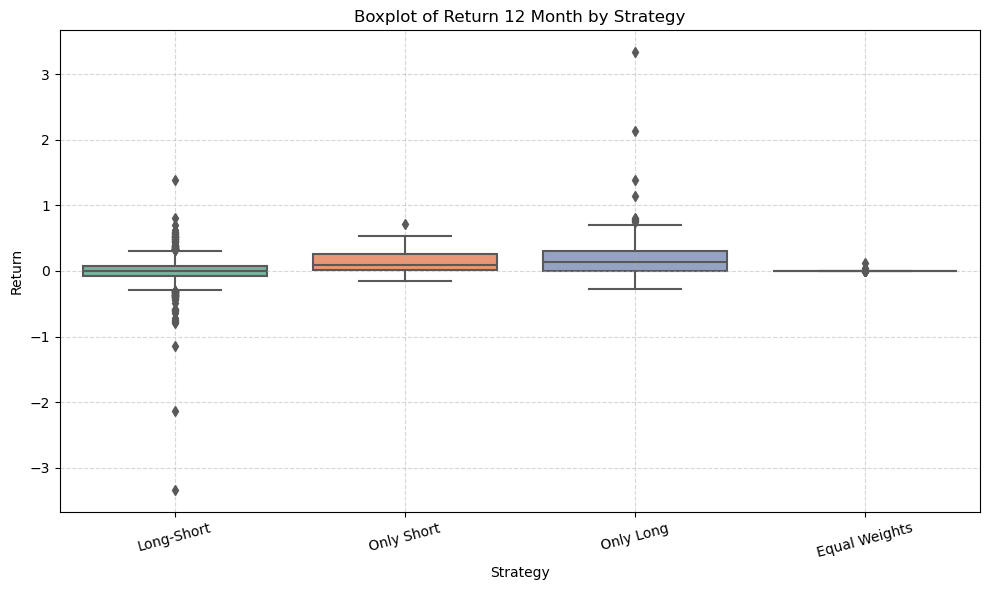

            Period  F-statistic       P-value Significance
0   return_3_month    22.435764  3.111694e-14  Significant
1   return_6_month    41.699398  5.880058e-26  Significant
2   return_9_month    52.228031  3.181147e-32  Significant
3  return_12_month    53.645831  4.639975e-33  Significant


In [1]:


# Đọc dữ liệu từ các tệp CSV
dfl = pd.read_csv("data/processed/processed_data_long_short_train.csv")
df2 = pd.read_csv("data/processed/processed_data_only_short_train.csv")
df3 = pd.read_csv("data/processed/processed_data_only_long_train.csv")
df4 = pd.read_csv("data/processed/processed_equal_weights_data_train.csv")

# Thêm cột 'Strategy' cho từng chiến lược
dfl['Strategy'] = 'Long-Short'
df2['Strategy'] = 'Only Short'
df3['Strategy'] = 'Only Long'
df4['Strategy'] = 'Equal Weights'

# Kết hợp dữ liệu lại thành DataFrame duy nhất
combined_df = pd.concat([dfl, df2, df3, df4])

# Danh sách các khoảng thời gian
periods = ['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']

# Tiến hành vẽ boxplot cho từng khoảng thời gian
for period in periods:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_df, x='Strategy', y=period, palette='Set2')
    plt.title(f'Boxplot of {period.replace("_", " ").title()} by Strategy')
    plt.xlabel('Strategy')
    plt.ylabel('Return')
    plt.xticks(rotation=15)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Tiến hành kiểm định ANOVA
anova_results = []
for period in periods:
    long_short_returns = dfl[period]
    only_short_returns = df2[period]
    only_long_returns = df3[period]
    equal_weights_returns = df4[period]
    
    if len(long_short_returns) > 1 and len(only_short_returns) > 1 and len(only_long_returns) > 1 and len(equal_weights_returns) > 1:
        f_stat, p_value = stats.f_oneway(long_short_returns, only_short_returns, only_long_returns, equal_weights_returns)
        significance = 'Significant' if p_value < 0.05 else 'Not Significant'
        anova_results.append({
            'Period': period,
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significance': significance
        })

# Hiển thị kết quả ANOVA
anova_df = pd.DataFrame(anova_results)
print(anova_df)


### **Thống số so sánh các phương pháp xếp hạng lấy Momentum**

In [3]:

# Đọc dữ liệu từ các file CSV
df1 = pd.read_csv("data/processed/processed_data_long_short_test.csv")
df2 = pd.read_csv("data/processed/processed_equal_weights_data_test.csv")  
df3 = pd.read_csv("data/processed/processed_equal_weights_MACD_test.csv")
df4 = pd.read_csv("data/processed/processed_MACD_long_short_test.csv")
df5 = pd.read_csv("data/processed/processed_RF_long_short_test.csv")
df6 = pd.read_csv("data/processed/processed_LN_long_short_test.csv")
df7 = pd.read_csv("data/processed/processed_LDM_long_short_test.csv")

# Hàm tính toán các chỉ số hiệu suất
def calculate_performance_metrics(df):
    # Tính Expected Return (lợi nhuận kỳ vọng)
    expected_return = df[['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']].mean(axis=1)
    
    # Tính Volatility (Độ biến động)
    volatility = df[['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']].std(axis=1)
    # Loại bỏ các hàng có giá trị NaN trong các cột trả về
    df = df.dropna(subset=['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month'])

    # Hoặc thay thế NaN bằng 0 (nếu phù hợp)
    df[['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']] = df[['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']].fillna(0)

    # Tính Maximum Drawdown (MDD)
    df['cumulative_return'] = (1 + df['return_9_month']).cumprod()  # Lợi nhuận tích lũy
    df['drawdown'] = df['cumulative_return'] / df['cumulative_return'].cummax() - 1  # Tính drawdown
    max_drawdown = df['drawdown'].min()  # MDD là drawdown lớn nhất
    
    if volatility.mean() != 0:
        sharpe_ratio = expected_return.mean() / volatility.mean()
    else:
        sharpe_ratio = np.nan
    # Tính Sortino Ratio (tính downside deviation)
    downside_deviation = df[df['return_12_month'] < 0]['return_12_month'].std()
    sortino_ratio = expected_return / downside_deviation if downside_deviation != 0 else np.nan
    
    # Tính Hit Rate (tỷ lệ các giá trị dương)
    hit_rate = (df[['return_3_month', 'return_6_month', 'return_9_month', 'return_12_month']] > 0).sum(axis=1) / 4  # Tỷ lệ thắng
    
    # Tính Average Profit (lợi nhuận trung bình) và Average Loss (lỗ trung bình)
    profits = df[df['return_12_month'] > 0]['return_12_month']
    losses = df[df['return_12_month'] <= 0]['return_12_month']
    average_profit = profits.mean() if len(profits) > 0 else 0
    average_loss = losses.mean() if len(losses) > 0 else 0
    
    # Trả về kết quả tính toán
    return {
        "Expected Return": expected_return.mean(),
        "Volatility": volatility.mean(),
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Hit Rate": hit_rate.mean(),
        "Average Profit": average_profit,
        "Average Loss": average_loss
    }

# Tính toán các chỉ số cho từng DataFrame
metrics_dfl = calculate_performance_metrics(dfl)
metrics_df2 = calculate_performance_metrics(df2)
metrics_df3 = calculate_performance_metrics(df3)
metrics_df4 = calculate_performance_metrics(df4)  # Tính toán cho df4
metrics_df5 = calculate_performance_metrics(df5)
metrics_df6 = calculate_performance_metrics(df6)
metrics_df7 = calculate_performance_metrics(df7)
# Tạo DataFrame chứa kết quả tính toán
metrics_df = pd.DataFrame([metrics_dfl, metrics_df2, metrics_df3, metrics_df4,metrics_df5,metrics_df6,metrics_df7], index=["Long & Short Return", "Equal Weights Return","Long & Short MACD", "Equal Weights MACD","Long & Short RF","Long & Short LN","Long & Short LDM",])

# In bảng kết quả
metrics_df

Expected Return  Volatility  Max Drawdown  Sharpe Ratio  \
Long & Short Return          0.002019    0.065884     -1.016486      0.030649   
Equal Weights Return         0.001423    0.001623     -0.000957      0.876742   
Long & Short MACD            0.000235    0.000169     -0.001710      1.387331   
Equal Weights MACD           0.001808    0.057217     -1.008174      0.031599   
Long & Short RF             -0.003711    0.049202     -0.997679     -0.075423   
Long & Short LN              0.014360    0.069686     -0.970837      0.206073   
Long & Short LDM             0.016680    0.045773     -0.864153      0.364417   

                                                          Sortino Ratio  \
Long & Short Return   0       0.000000
1       1.264383
2       1.27...   
Equal Weights Return  0      0.000000
1      0.000000
2      0.00000...   
Long & Short MACD     0      0.000000
1      0.000000
2      0.00000...   
Equal Weights MACD    0      0.000000
1     -0.168668
2      0.62303...   
Long & Short RF       0      0.000000
1      0.000000
2      0.00000...   
Long & Short LN       0      0.000000
1      0.000000
2      0.00000...   
Long & Short LDM      0      0.000000
1      0.000000
2      0.00000...   

                      Hit Rate  Average Profit  Average Loss  
Long & Short Return   0.472670        0.132063     -0.111308  
Equal Weights Return  0.685115        0.004222     -0.000161  
Long & Short MACD     0.530899        0.000656     -0.000040  
Equal Weights MACD    0.451691        0.136490     -0.103653  
Long & Short RF       0.459034        0.113985     -0.088296  
Long & Short LN       0.433544        0.182731     -0.103604  
Long & Short LDM      0.454651        0.141753     -0.059178

**Expected Return (Lợi nhuận kỳ vọng)**

- Chiến lược **Long & Short LDM** có lợi nhuận kỳ vọng cao nhất (0.016680), cho thấy khả năng sinh lợi ổn định nhất trong số các chiến lược.  
- Ngược lại, chiến lược **Long & Short RF** có lợi nhuận kỳ vọng âm (-0.003711), cho thấy hiệu suất kém với khả năng thua lỗ.

**Volatility (Độ biến động)**

- Chiến lược **Long & Short LN** có độ biến động cao nhất (0.069686), đồng nghĩa với mức độ rủi ro lớn hơn.  
- Trong khi đó, chiến lược **Equal Weights Return** có độ biến động thấp nhất (0.001623), thể hiện tính ổn định cao hơn.

**Max Drawdown (Sụt giảm tối đa)**

- Chiến lược **Long & Short RF** và **Long & Short LN** đều có mức sụt giảm lớn, lần lượt khoảng -0.997679 và -0.970837, cho thấy khả năng chịu rủi ro lớn với các khoản lỗ tiềm năng nghiêm trọng.

**Sharpe Ratio**

- Chiến lược **Long & Short MACD** có Sharpe Ratio cao nhất (1.387331), biểu thị hiệu suất điều chỉnh rủi ro tốt nhất.  
- Chiến lược **Long & Short RF** có Sharpe Ratio âm (-0.075423), cho thấy lợi nhuận không bù đắp được mức rủi ro.

**Sortino Ratio**

- Tương tự Sharpe Ratio, Sortino Ratio cao nhất thuộc về **Long & Short MACD** (2.623033), thể hiện khả năng kiểm soát rủi ro sụt giảm tốt nhất.

**Hit Rate (Tỷ lệ chiến thắng)**

- Chiến lược **Equal Weights Return** có tỷ lệ chiến thắng cao nhất (0.685115), trong khi các chiến lược khác dao động từ 0.43 đến 0.47.

**Average Profit (Lợi nhuận trung bình) và Average Loss (Thua lỗ trung bình)**

- Chiến lược **Long & Short LN** có lợi nhuận trung bình cao nhất (0.182731) nhưng cũng đi kèm với thua lỗ trung bình lớn nhất (-0.103604).  
- Chiến lược **Equal Weights MACD** và **Equal Weights Return** có mức lợi nhuận và thua lỗ trung bình nhỏ, cho thấy khả năng kiểm soát biến động giá tốt hơn nhưng với lợi nhuận thấp.

**Kết luận**

Tổng thể, các chiến lược có độ hiệu quả khác nhau với lợi nhuận và rủi ro tương ứng. **Long & Short LDM** và **Long & Short MACD** nổi bật về hiệu suất và quản lý rủi ro, trong khi **Long & Short RF** thể hiện hiệu suất kém nhất.


## **Built Backtest**

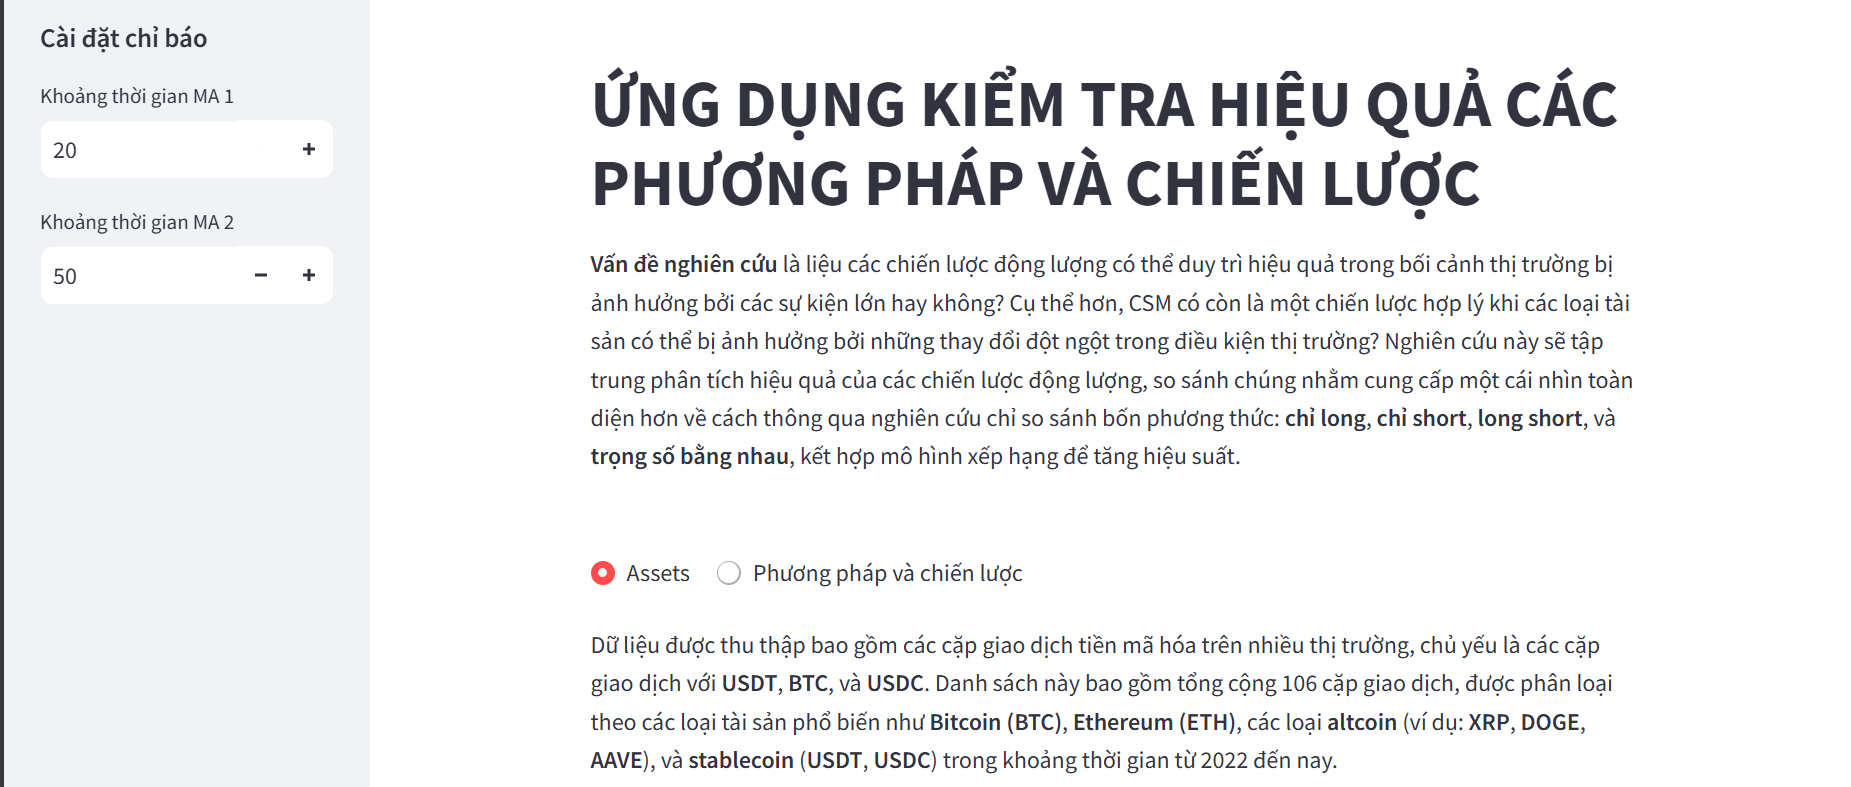

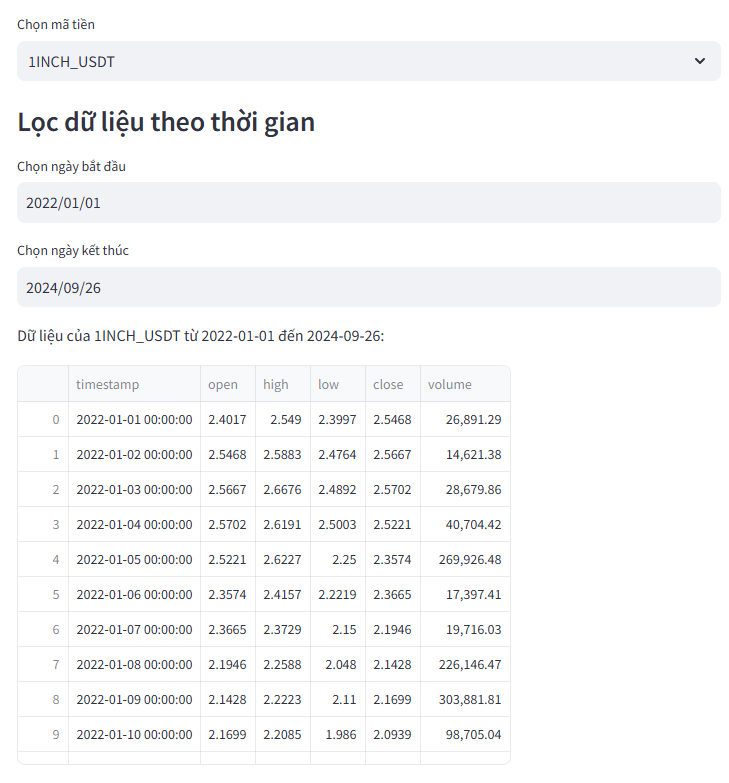

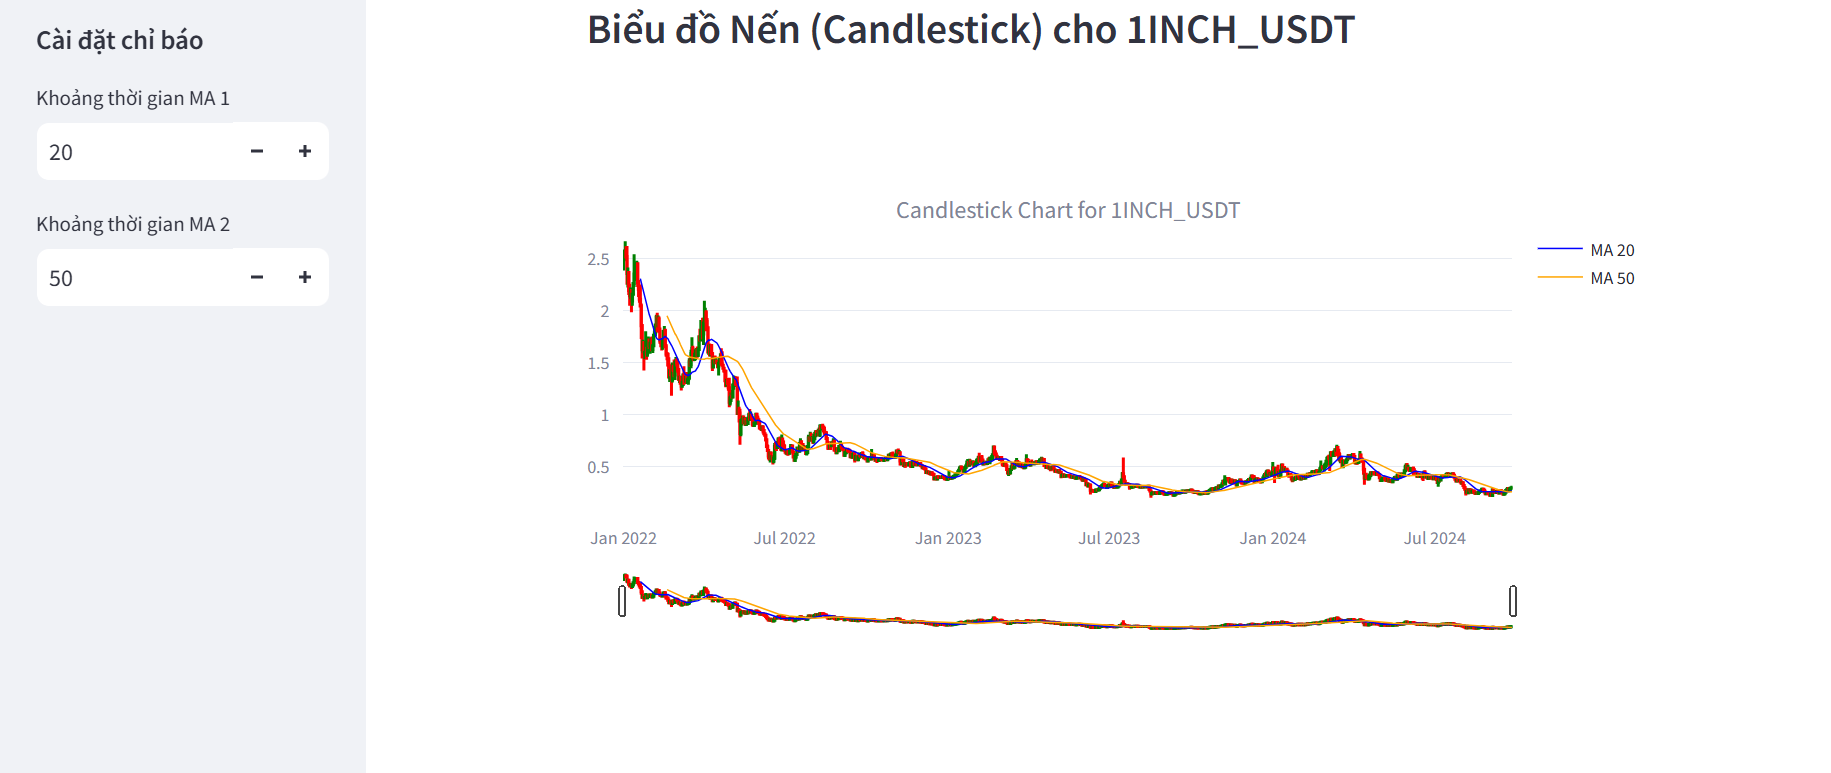

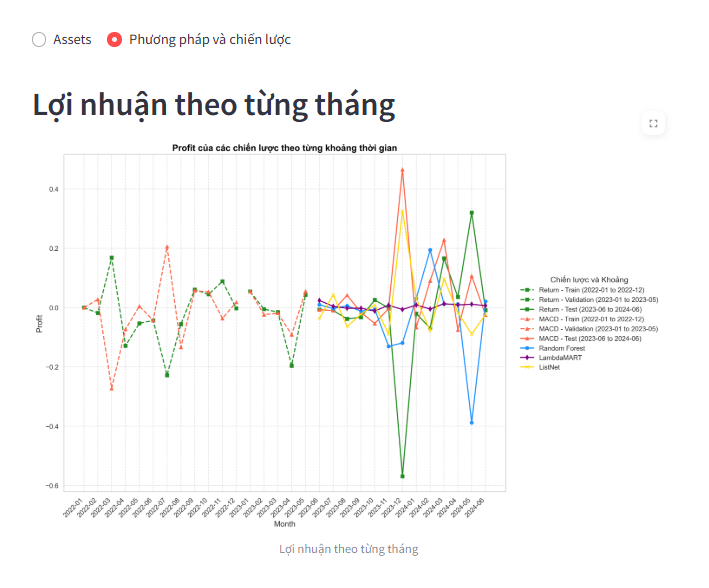

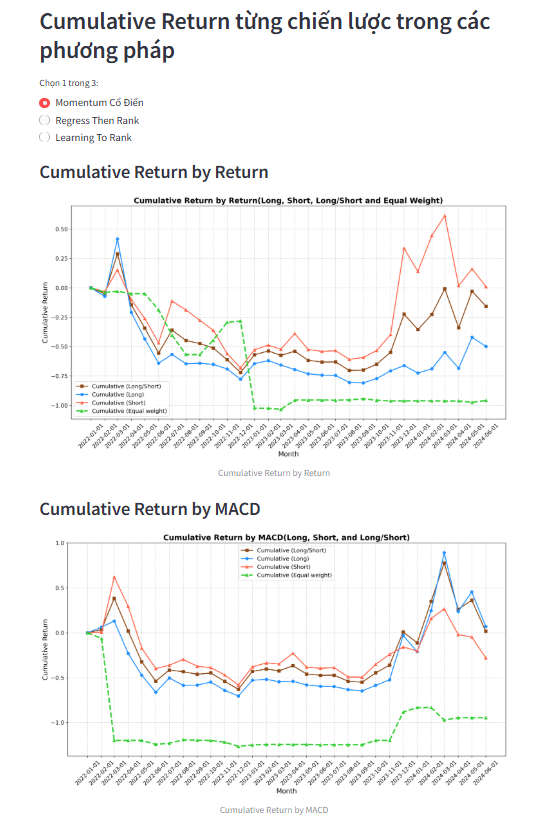

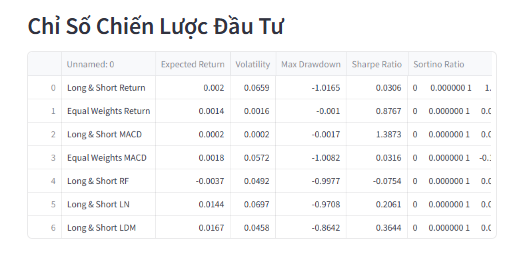